# 프로젝트: 다음에 볼 영화 예측하기
## 루브릭
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.


Movielens 1M Dataset을 기반으로 진행한다.

# 1. 데이터 불러오기

In [800]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [801]:
import os
from pathlib import Path

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/')
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

train 파일 확인

In [802]:
f = open(train_path, 'r')
line = f.readline()
print(line)
f.close()

1::1193::5::978300760



In [803]:
# data load하는 함수
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [804]:
train_data = load_data(train_path, None)
train_data.sort_values(['UserId', 'Time'], inplace=True)
train_data.head()

UserId  ItemId  Rating       Time
31       1    3186       4  978300019
22       1    1270       5  978300055
27       1    1721       4  978300055
37       1    1022       5  978300055
24       1    2340       3  978300103

In [805]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


* Session Id가 아닌 UserId를 사용
* Rating 정보가 있어서 선호하는 영화로 추천하는데 도움이 될 것 같다.
* Time은 UTC time인데 int형이므로 datetime으로 바꿔줘야 한다.

In [806]:
train_data["Time"] = train_data["Time"].apply(lambda x: dt.datetime.fromtimestamp(x, dt.timezone.utc))
train_data.head()

UserId  ItemId  Rating                      Time
31       1    3186       4 2000-12-31 22:00:19+00:00
22       1    1270       5 2000-12-31 22:00:55+00:00
27       1    1721       4 2000-12-31 22:00:55+00:00
37       1    1022       5 2000-12-31 22:00:55+00:00
24       1    2340       3 2000-12-31 22:01:43+00:00

In [807]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype              
---  ------  --------------    -----              
 0   UserId  1000209 non-null  int32              
 1   ItemId  1000209 non-null  int32              
 2   Rating  1000209 non-null  int32              
 3   Time    1000209 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 26.7 MB


# 2. 데이터 전처리

In [808]:
print(f'데이터 총 개수: {len(train_data)}')

데이터 총 개수: 1000209


<AxesSubplot:>

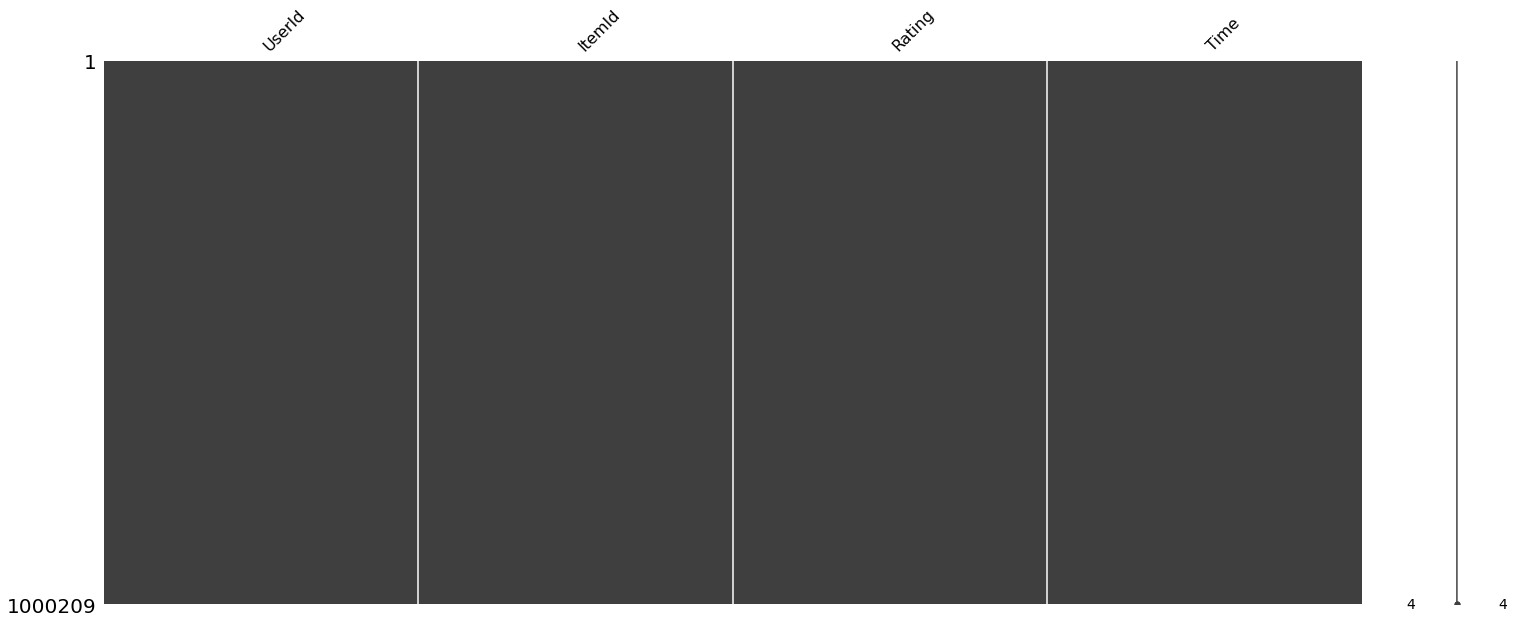

In [809]:
import missingno as msno
msno.matrix(train_data)

결측값은 발견되지 않았다.

In [810]:
print(f"유저수: {train_data['UserId'].nunique()}")
print(f"영화수: {train_data['ItemId'].nunique()}")

유저수: 6040
영화수: 3706


In [811]:
print(f"Rating 종류: {train_data['Rating'].unique()}")

Rating 종류: [4 5 3 2 1]


## Session Length
UserId를 Session Id로 정의하고 진행할 예정이다.    
한 유저가 몇개의 영화 데이터를 가지고 있는지 확인해본다.

In [812]:
group_by_user = train_data.groupby('UserId').size()

In [813]:
group_by_user.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [814]:
group_by_user.quantile(0.999)

1343.181000000005

보통 한 사람이 평가를 준 영화 수는 165개이다.    
상위 25%로 많이 준 사람은 208개인데 한 사람이 최대로 준 영화 편 수가 2314이다.    
99.9%의 사용자는 1343개의 영화를 평가했는데 이는 최대치인 2314과 많이 차이나는 것을 알 수 있다.

In [815]:
long_session = group_by_user[group_by_user==2314].index[0]
train_data[train_data['UserId']==long_session]

UserId  ItemId  Rating                      Time
696969    4169    1268       5 2000-08-03 20:09:52+00:00
697168    4169    2617       4 2000-08-03 20:09:52+00:00
697185    4169    2628       4 2000-08-03 20:09:52+00:00
697219    4169    2653       4 2000-08-03 20:09:52+00:00
697275    4169     423       3 2000-08-03 20:09:52+00:00
...        ...     ...     ...                       ...
697882    4169    3754       2 2002-06-15 20:52:27+00:00
695702    4169    1413       3 2002-06-15 21:03:51+00:00
697358    4169     494       4 2002-06-15 21:16:00+00:00
695945    4169    1804       2 2002-06-15 21:16:23+00:00
696446    4169    1548       3 2002-06-15 21:25:37+00:00

[2314 rows x 4 columns]

짧은 간격으로 영화 리뷰를 남기고 있는 것을 알 수 있다.    
매크로일 수도 있고, 리뷰를 한꺼번에 몰아서 남기는 것일 수 있다.    
하지만 같은 시간에 같은 사람이 같은 영화에 평점을 주는 것은 매크로로 의심해볼 수 있으므로 이 경우는 삭제해주려고 한다.

In [816]:
group_duplicate=train_data.groupby(['UserId','ItemId', 'Time']).size().to_frame().reset_index()
group_duplicate.rename(columns={0:'Size'}, inplace=True)
group_duplicate.head()

UserId  ItemId                      Time  Size
0       1       1 2001-01-06 23:37:48+00:00     1
1       1      48 2001-01-06 23:39:11+00:00     1
2       1     150 2000-12-31 22:29:37+00:00     1
3       1     260 2000-12-31 22:12:40+00:00     1
4       1     527 2001-01-06 23:36:35+00:00     1

In [817]:
duplicate_len = len(group_duplicate.loc[group_duplicate['Size']>1, 'UserId'].unique())
print(f'{duplicate_len}명')
print(f'{duplicate_len / train_data["UserId"].nunique() * 100}%')

0명
0.0%


다행이 UserId, ItemId, Time이 모두 같은 매크로로 의심되는 데이터는 안보인다.

### 세션길이 기준 하위 99.9% 분포 누적합

In [818]:
length_count = group_by_user.groupby(group_by_user).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

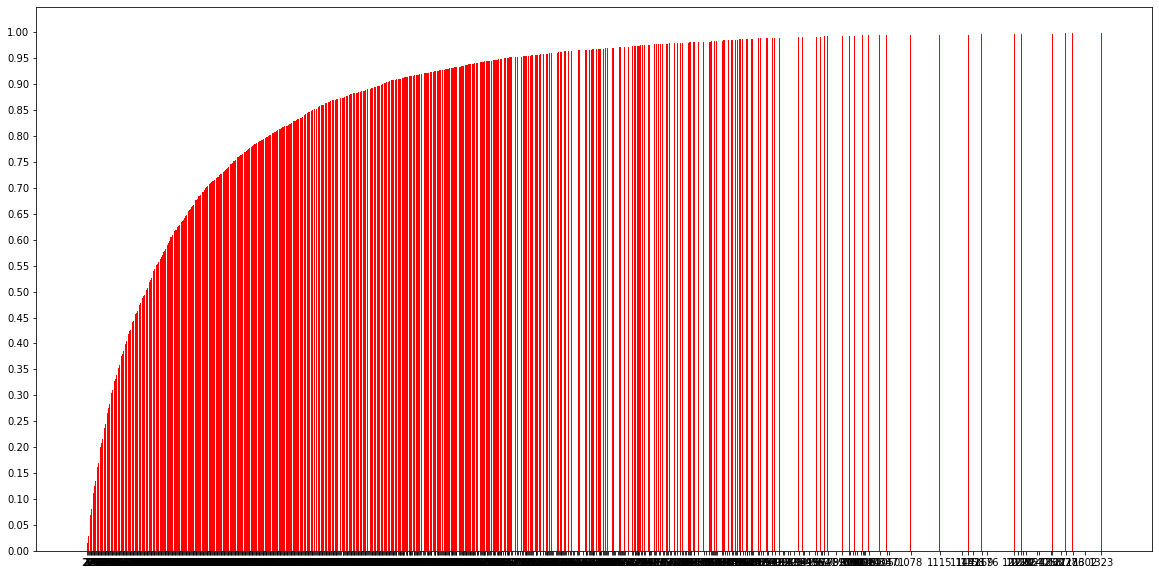

In [819]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
#plt.title('Cumsum Percentage Until 0.999')
plt.show()

## Session Time

In [820]:
oldest, latest = train_data['Time'].min(), train_data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32+00:00
2003-02-28 17:49:50+00:00


이 데이터셋은 대략 2년이 넘는 데이터를 가지고 있다.    
하지만 사용자들의 소비패턴은 금방 변하기 때문에 최근 데이터를 학습하는 것이 좋다.    

3달치, 6달치 데이터 중 어느 기간이 성능이 좋아지는지 확인하는 것도 좋을 듯 하다.

In [821]:
def get_data_before_month(data, month):
    latest = data['Time'].max()
    month_ago = latest - dt.timedelta(month*30)
    data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
    print(f'length:{len(data)}')
    oldest, latest = data['Time'].min(), data['Time'].max()
    print(f'oldest: {oldest}') 
    print(f'latest: {latest}')
    return data

In [822]:
data_3 = get_data_before_month(train_data, 3)

length:4616
oldest: 2002-11-30 20:24:52+00:00
latest: 2003-02-28 17:49:50+00:00


## Data Cleansing
사용자가 최소 1개 이상 클릭했을 때의 다음을 예측하는 것이기 때문에 길이가 1인 세션은 삭제한다.    
너무 적게 클릭된 아이템은 이상한 것일 가능성이 있으므로 삭제한다.

In [823]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [824]:
print(f'before:{len(data_3)}')
data_3 = cleanse_recursive(data_3, shortest=2, least_click=5)
len(data_3)

before:4616


1606

## Train/Valid/Test split

In [825]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()    
    session_in_train = data.loc[data['Time'] < final_time - dt.timedelta(n_days)]
    session_in_test = data.loc[data['Time'] >= final_time - dt.timedelta(n_days)]
    return session_in_train, session_in_test

In [826]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t User Id: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min().strftime("%Y-%m-%d %H:%M:%S.%f")}\n'
          f'\t Last Time : {data["Time"].max().strftime("%Y-%m-%d %H:%M:%S.%f")}\n')

In [827]:
# 현재 3개월 데이터에 대해서 테스트하고 있다.
tr, test = split_by_date(data_3, n_days=10)
tr, val = split_by_date(tr, n_days=10)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 1321
	 User Id: 132
	 Items: 231
	 First Time : 2002-12-01 04:17:00.000000
	 Last Time : 2003-02-08 15:14:46.000000

* valid Set Stats Info
	 Events: 121
	 User Id: 24
	 Items: 96
	 First Time : 2003-02-08 22:46:24.000000
	 Last Time : 2003-02-18 17:36:46.000000

* test Set Stats Info
	 Events: 164
	 User Id: 27
	 Items: 117
	 First Time : 2003-02-18 23:13:57.000000
	 Last Time : 2003-02-28 17:45:20.000000



In [828]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
def indexing(df):
    id2idx = {item_id : index for index, item_id in enumerate(df['ItemId'].unique())}
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr)
val = indexing(val)
test = indexing(test)

In [829]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_3month.pkl')
val.to_pickle(save_path / 'valid_3month.pkl')
test.to_pickle(save_path / 'test_3month.pkl')

# 3. Data Pipeline

## SessionDataset

In [830]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [831]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

UserId  ItemId  Rating                      Time  item_idx
5364      36    3786       4 2002-12-22 08:08:41+00:00         0
5280      36    3174       4 2002-12-22 08:11:25+00:00         1
5222      36     296       5 2002-12-22 08:16:59+00:00         2
5062      36    1266       5 2002-12-22 08:18:29+00:00         3
5076      36     595       4 2002-12-22 08:18:29+00:00         4
5180      36    3639       4 2002-12-22 08:18:45+00:00         5
8704      59    2997       4 2003-01-07 18:02:48+00:00         6
8797      59    3408       4 2003-01-07 18:04:52+00:00         7
8808      59    2712       3 2003-01-07 18:04:52+00:00         8
8798      59    2396       4 2003-01-07 18:07:15+00:00         9

In [832]:
tr_dataset.df

UserId  ItemId  Rating                      Time  item_idx
5364        36    3786       4 2002-12-22 08:08:41+00:00         0
5280        36    3174       4 2002-12-22 08:11:25+00:00         1
5222        36     296       5 2002-12-22 08:16:59+00:00         2
5062        36    1266       5 2002-12-22 08:18:29+00:00         3
5076        36     595       4 2002-12-22 08:18:29+00:00         4
...        ...     ...     ...                       ...       ...
974523    5878    1291       5 2003-01-28 20:08:13+00:00       211
974184    5878    2076       1 2003-01-28 20:11:04+00:00       168
974310    5878    2115       5 2003-01-28 20:14:44+00:00       210
984167    5948    1283       5 2003-01-20 13:10:49+00:00        33
984206    5948    1304       5 2003-01-20 13:14:16+00:00        30

[1321 rows x 5 columns]

In [833]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131])

In [834]:
tr_dataset.get_click_offsets()

array([   0,    6,   41,   92,   99,  127,  129,  170,  172,  174,  177,
        180,  185,  197,  199,  292,  296,  305,  314,  318,  324,  326,
        329,  332,  334,  338,  340,  348,  357,  359,  363,  364,  373,
        375,  382,  386,  394,  398,  416,  419,  438,  440,  442,  444,
        447,  449,  454,  464,  465,  467,  470,  482,  491,  494,  510,
        512,  519,  538,  542,  544,  575,  583,  589,  590,  592,  605,
        621,  629,  643,  645,  651,  654,  662,  664,  666,  672,  674,
        683,  685,  739,  740,  743,  758,  763,  767,  773,  777,  787,
        797,  804,  810,  825,  827,  833,  837,  842,  846,  849,  851,
        854,  857,  915,  919,  922,  929,  935,  940,  952,  958,  969,
        999, 1002, 1006, 1011, 1029, 1034, 1037, 1135, 1152, 1167, 1181,
       1186, 1190, 1195, 1211, 1215, 1220, 1222, 1229, 1250, 1252, 1319,
       1321], dtype=int32)

## SessionDataLoader

In [835]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [836]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

In [837]:
iter_ex = iter(tr_data_loader)

In [838]:
for i in range(5):
    inputs, labels, mask =  next(iter_ex)
    print(f'Model Input Item Idx are : {inputs}')
    print(f'Label Item Idx are : {"":5} {labels}')
    print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  6 40 59]
Label Item Idx are :       [ 1  7 41 64]
Previous Masked Input Idx are []
Model Input Item Idx are : [ 1  7 41 64]
Label Item Idx are :       [2 8 6 5]
Previous Masked Input Idx are []
Model Input Item Idx are : [2 8 6 5]
Label Item Idx are :       [ 3  9 42 69]
Previous Masked Input Idx are []
Model Input Item Idx are : [ 3  9 42 69]
Label Item Idx are :       [ 4 10 43 80]
Previous Masked Input Idx are []
Model Input Item Idx are : [ 4 10 43 80]
Label Item Idx are :       [ 5 11  0 31]
Previous Masked Input Idx are []


# 4. Modeling
## Evaluation Metric
Session Based Recommendation Task에서는 recall과 precision 개념을 확장한 recall@k, Mean Average Precision@k 지표등을 사용한다.    
또 추천에서는 몇 번째로 맞추느냐도 중요하기 때문에 순서에 민감한 지표인 MRR, NDCG도 사용한다.    

Average Precision때문에 대개는 P@K보다는 R@K을 많이 사용하는 듯 하다.- https://jyoondev.tistory.com/130

In [839]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [840]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [841]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [842]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=8, hsz=50, drop_rate=0.2, lr=0.001, epochs=20, k=10)

In [843]:
model = create_model(args)

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_49 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_49 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [844]:
def train_model(model, args, display_flg=True):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask) 

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k, display_flg) 

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
    
    return val_recall, val_mrr


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU') 
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask: 
        hidden_states[elt, :] = 0  
    gru_layer.reset_states(states=hidden_states)

def display_metrics(recall, mrr):
    plt.figure(figsize=(8,5))
    plt.plot(recall, color='red', label='recall')
    plt.plot(mrr, label='mrr')
    plt.legend()
    plt.show()
    
def get_metrics(data, model, args, k: int, display_flg=True): 
                                            
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])

        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    if display_flg==True:     
        display_metrics(recall_list, mrr_list)
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

Evaluation:  17%|█▋        | 2/12 [00:00<00:03,  3.31it/s]


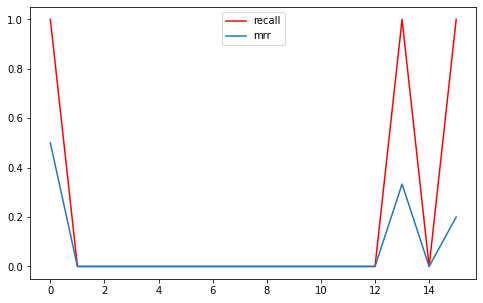

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.39]    

	 - Recall@10 epoch 1: 0.187500
	 - MRR@10    epoch 1: 0.064583



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.06it/s]


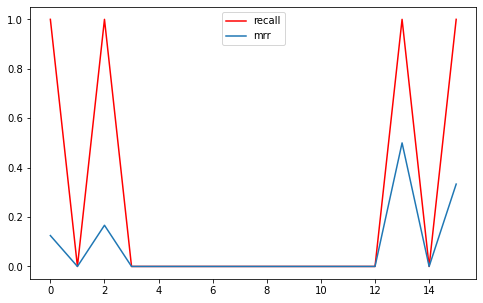

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.25]    

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.070312



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.47it/s]


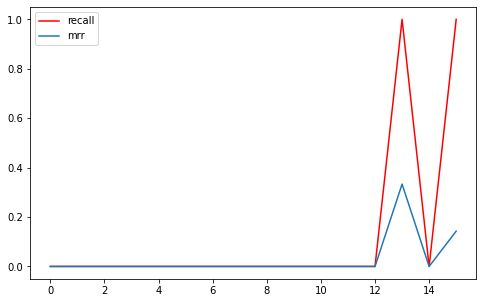

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.15]    

	 - Recall@10 epoch 3: 0.125000
	 - MRR@10    epoch 3: 0.029762



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.88it/s]


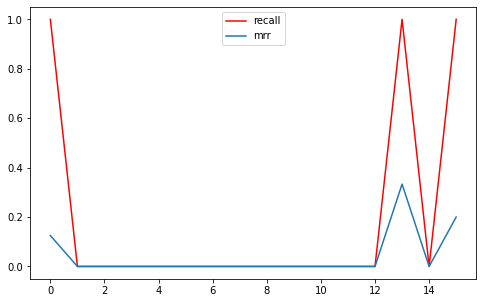

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.07]    

	 - Recall@10 epoch 4: 0.187500
	 - MRR@10    epoch 4: 0.041146



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.37it/s]


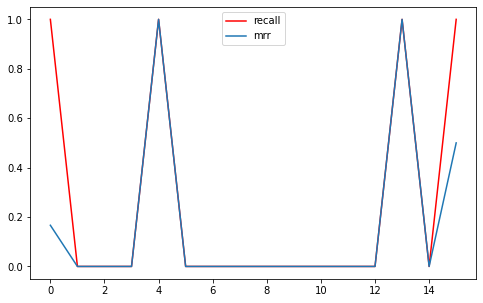

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.03]    

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.166667



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.89it/s]


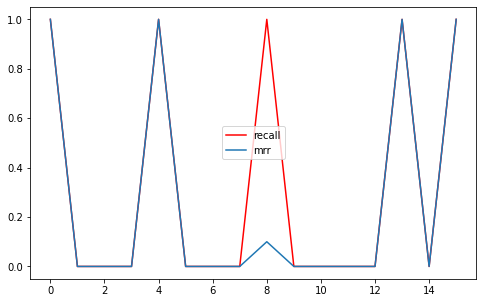

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.99]    

	 - Recall@10 epoch 6: 0.312500
	 - MRR@10    epoch 6: 0.256250



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.27it/s]


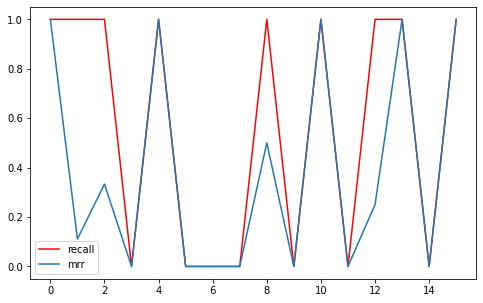

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.86]

	 - Recall@10 epoch 7: 0.562500
	 - MRR@10    epoch 7: 0.387153



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.51it/s]


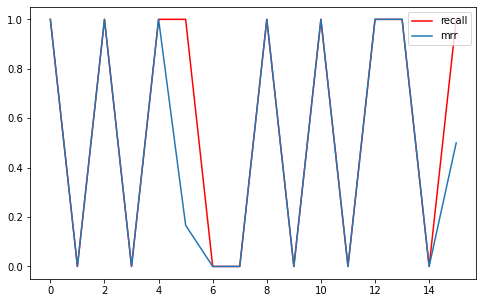

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.54] 

	 - Recall@10 epoch 8: 0.562500
	 - MRR@10    epoch 8: 0.479167



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 22.22it/s]


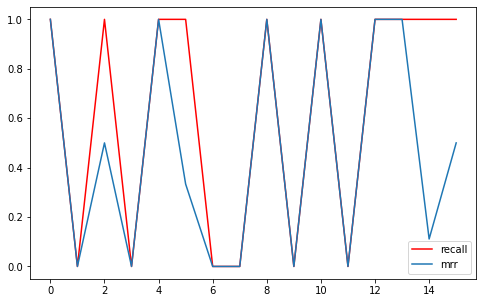

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.51] 

	 - Recall@10 epoch 9: 0.625000
	 - MRR@10    epoch 9: 0.465278



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 22.97it/s]


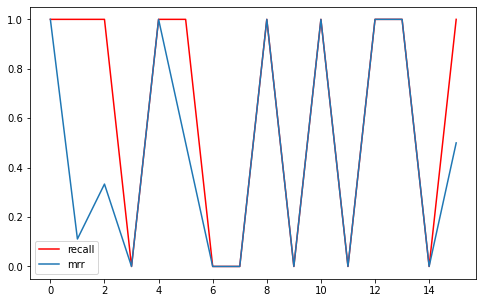

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.38] 

	 - Recall@10 epoch 10: 0.625000
	 - MRR@10    epoch 10: 0.465278



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.85it/s]


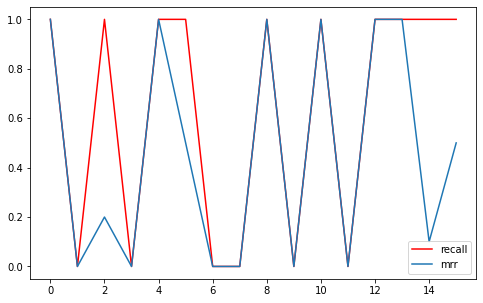

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.22]

	 - Recall@10 epoch 11: 0.625000
	 - MRR@10    epoch 11: 0.456250



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.79it/s]


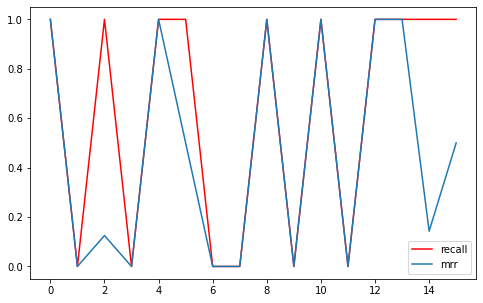

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.89]

	 - Recall@10 epoch 12: 0.625000
	 - MRR@10    epoch 12: 0.454241



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.65it/s]


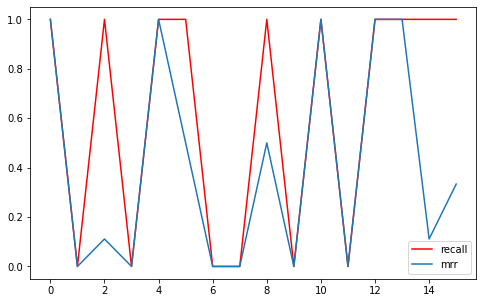

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.8] 

	 - Recall@10 epoch 13: 0.625000
	 - MRR@10    epoch 13: 0.409722



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.83it/s]


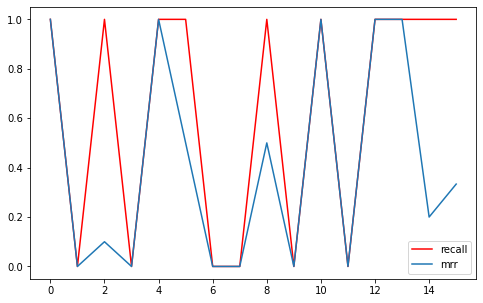

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.57] 

	 - Recall@10 epoch 14: 0.625000
	 - MRR@10    epoch 14: 0.414583



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.35it/s]


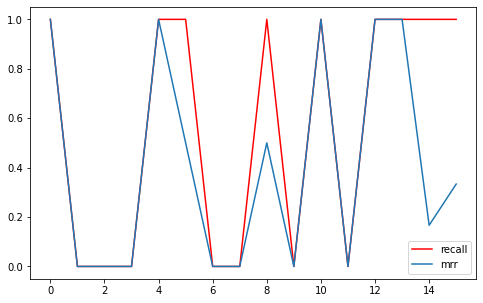

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.58]  

	 - Recall@10 epoch 15: 0.562500
	 - MRR@10    epoch 15: 0.406250



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.22it/s]


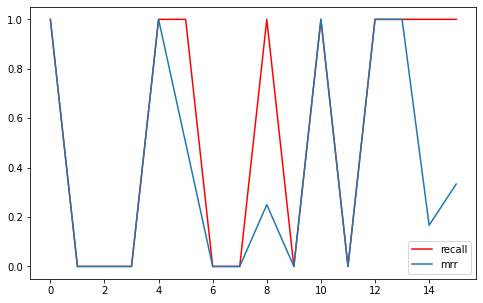

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.23]  

	 - Recall@10 epoch 16: 0.562500
	 - MRR@10    epoch 16: 0.390625



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.13it/s]


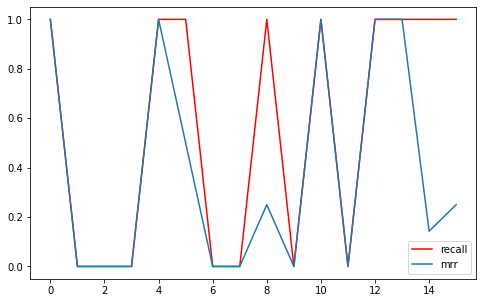

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.02]

	 - Recall@10 epoch 17: 0.562500
	 - MRR@10    epoch 17: 0.383929



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.10it/s]


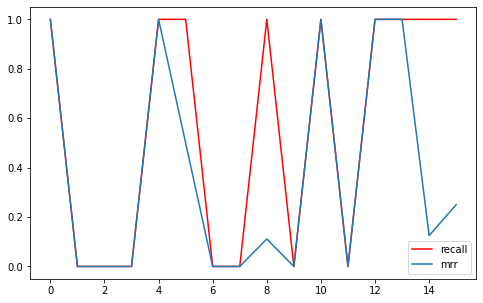

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.91]

	 - Recall@10 epoch 18: 0.562500
	 - MRR@10    epoch 18: 0.374132



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.63it/s]


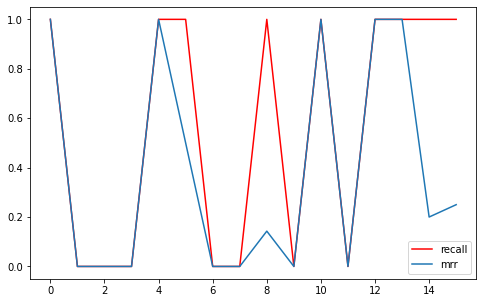

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.04]

	 - Recall@10 epoch 19: 0.562500
	 - MRR@10    epoch 19: 0.380804



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.50it/s]


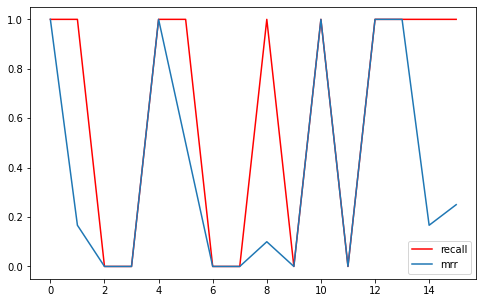

	 - Recall@10 epoch 20: 0.625000
	 - MRR@10    epoch 20: 0.386458



(0.625, 0.38645833333333335)

In [845]:
train_model(model, args)

## Inference

Evaluation:  47%|████▋     | 8/17 [00:00<00:00, 16.37it/s]


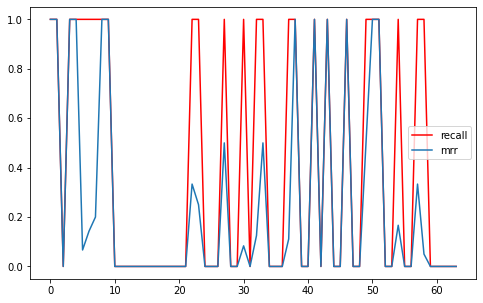

	 - Recall@10: 0.406250
	 - MRR@10: 0.240036



In [846]:
test_summary_metrix = {'recall':[], 'mrr':[]}
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    test_summary_metrix['recall'].append(test_recall)
    test_summary_metrix['mrr'].append(test_mrr)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

## 6개월치 데이터를 사용했을 때

In [847]:
data_6 = get_data_before_month(train_data, 6)
data_6 = cleanse_recursive(data_6, shortest=2, least_click=5)

length:8823
oldest: 2002-09-01 19:41:39+00:00
latest: 2003-02-28 17:49:50+00:00


In [848]:
tr, test = split_by_date(data_6, n_days=30)
tr, val = split_by_date(tr, n_days=30)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 3387
	 User Id: 232
	 Items: 665
	 First Time : 2002-09-01 19:44:55.000000
	 Last Time : 2002-12-30 16:48:39.000000

* valid Set Stats Info
	 Events: 1130
	 User Id: 115
	 Items: 554
	 First Time : 2002-12-30 18:21:02.000000
	 Last Time : 2003-01-29 17:00:13.000000

* test Set Stats Info
	 Events: 945
	 User Id: 83
	 Items: 501
	 First Time : 2003-01-29 19:36:56.000000
	 Last Time : 2003-02-28 17:45:20.000000



In [849]:
tr = indexing(tr)
val = indexing(val)
test = indexing(test)

In [850]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_6month.pkl')
val.to_pickle(save_path / 'valid_6month.pkl')
test.to_pickle(save_path / 'test_6month.pkl')

In [851]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

UserId  ItemId  Rating                      Time  item_idx
5200      36    2269       5 2002-12-22 08:05:50+00:00         0
5364      36    3786       4 2002-12-22 08:08:41+00:00         1
5262      36    2369       4 2002-12-22 08:09:24+00:00         2
5280      36    3174       4 2002-12-22 08:11:25+00:00         3
5222      36     296       5 2002-12-22 08:16:59+00:00         4
5104      36     247       4 2002-12-22 08:17:48+00:00         5
5062      36    1266       5 2002-12-22 08:18:29+00:00         6
5076      36     595       4 2002-12-22 08:18:29+00:00         7
5126      36    1295       4 2002-12-22 08:18:29+00:00         8
5180      36    3639       4 2002-12-22 08:18:45+00:00         9

In [852]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

UserId  ItemId  Rating                      Time  item_idx
5200       36    2269       5 2002-12-22 08:05:50+00:00         0
5364       36    3786       4 2002-12-22 08:08:41+00:00         1
5262       36    2369       4 2002-12-22 08:09:24+00:00         2
5280       36    3174       4 2002-12-22 08:11:25+00:00         3
5222       36     296       5 2002-12-22 08:16:59+00:00         4
5104       36     247       4 2002-12-22 08:17:48+00:00         5
5062       36    1266       5 2002-12-22 08:18:29+00:00         6
5076       36     595       4 2002-12-22 08:18:29+00:00         7
5126       36    1295       4 2002-12-22 08:18:29+00:00         8
5180       36    3639       4 2002-12-22 08:18:45+00:00         9
9676       65    2194       5 2002-09-29 21:33:17+00:00        10
9686       65     953       5 2002-12-28 15:41:08+00:00        11
13187     102    2858       3 2002-12-07 14:58:39+00:00        12
13171     102    2683       1 2002-12-07 14:59:06+00:00        13
13091     102    2997       3 2002-12-07 14:59:31+00:00        14

Train:   0%|          | 0/394 [00:00<?, ?it/s]

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(8, 1, 665)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        107550    
_________________________________________________________________
dropout_50 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_50 (Dense)             (8, 665)                  33915     
Total params: 141,465
Trainable params: 141,465
Non-trainable params: 0
_________________________________________________________________


Evaluation:  58%|█████▊    | 73/126 [00:04<00:02, 17.73it/s]


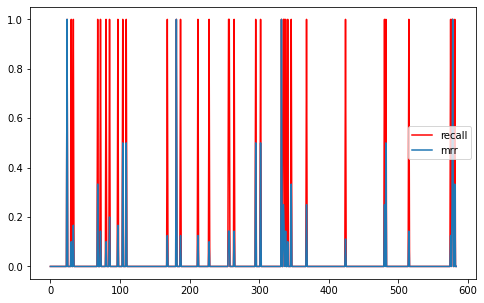

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=6.32]    

	 - Recall@10 epoch 1: 0.059932
	 - MRR@10    epoch 1: 0.018881



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.81it/s]


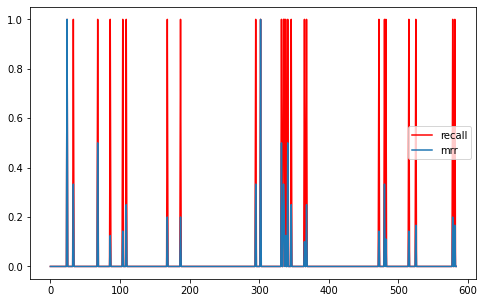

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=6.14]    

	 - Recall@10 epoch 2: 0.042808
	 - MRR@10    epoch 2: 0.013025



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.67it/s]


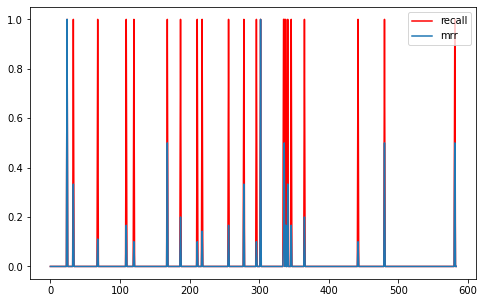

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=6.07]    

	 - Recall@10 epoch 3: 0.037671
	 - MRR@10    epoch 3: 0.011679



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.51it/s]


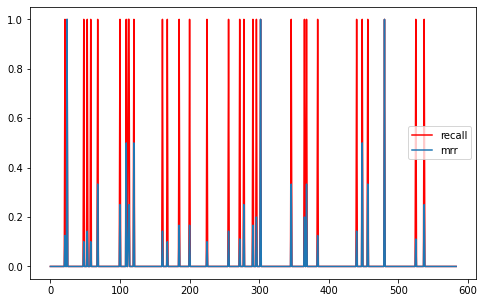

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=5.92]    

	 - Recall@10 epoch 4: 0.054795
	 - MRR@10    epoch 4: 0.015904



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.79it/s]


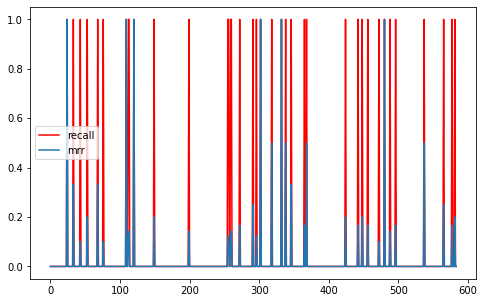

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=5.81]    

	 - Recall@10 epoch 5: 0.065068
	 - MRR@10    epoch 5: 0.022237



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.68it/s]


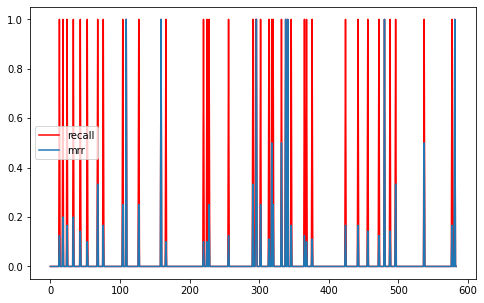

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=5.78]    

	 - Recall@10 epoch 6: 0.070205
	 - MRR@10    epoch 6: 0.023917



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.73it/s]


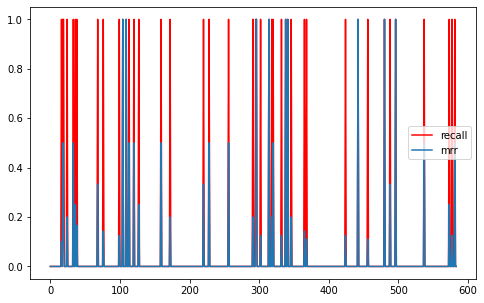

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=5.82]    

	 - Recall@10 epoch 7: 0.073630
	 - MRR@10    epoch 7: 0.031608



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.94it/s]


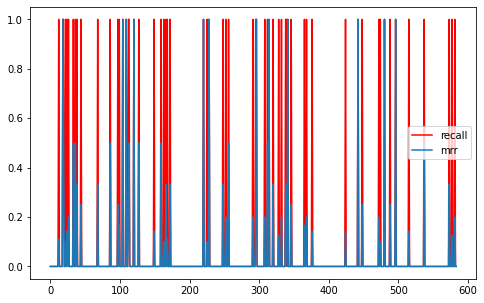

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0, train_loss=5.49]    

	 - Recall@10 epoch 8: 0.104452
	 - MRR@10    epoch 8: 0.042814



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 18.95it/s]


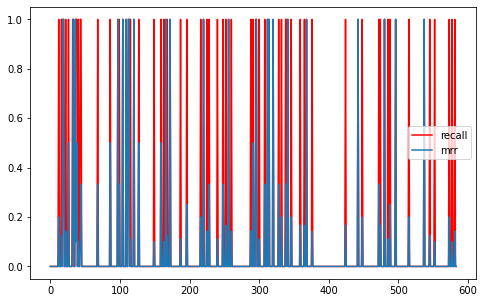

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.97] 

	 - Recall@10 epoch 9: 0.131849
	 - MRR@10    epoch 9: 0.061666



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.04it/s]


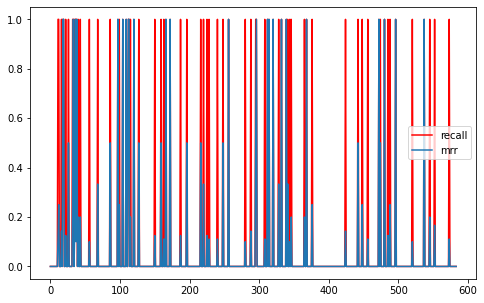

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.76] 

	 - Recall@10 epoch 10: 0.125000
	 - MRR@10    epoch 10: 0.062798



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.30it/s]


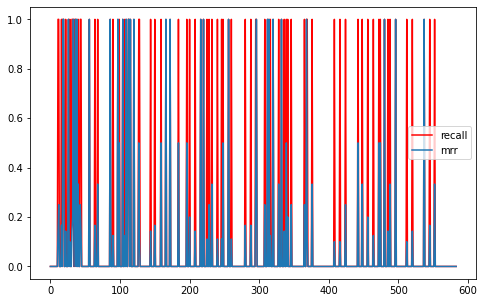

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.95]

	 - Recall@10 epoch 11: 0.152397
	 - MRR@10    epoch 11: 0.075175



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.25it/s]


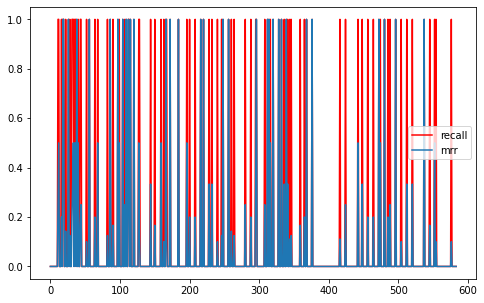

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.31]

	 - Recall@10 epoch 12: 0.164384
	 - MRR@10    epoch 12: 0.084260



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.38it/s]


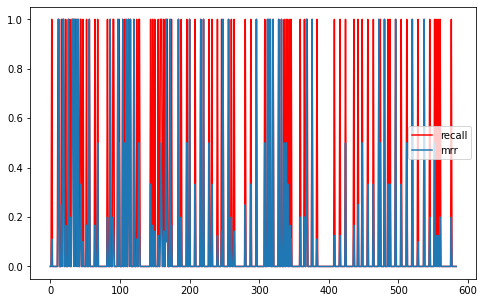

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.01] 

	 - Recall@10 epoch 13: 0.193493
	 - MRR@10    epoch 13: 0.100336



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.66it/s]


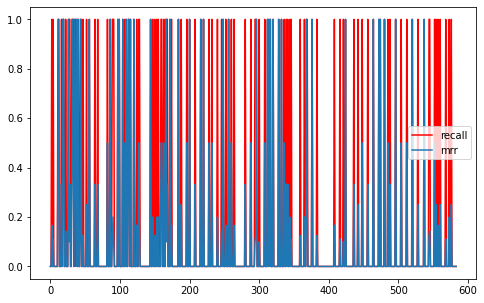

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.82] 

	 - Recall@10 epoch 14: 0.212329
	 - MRR@10    epoch 14: 0.114227



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.68it/s]


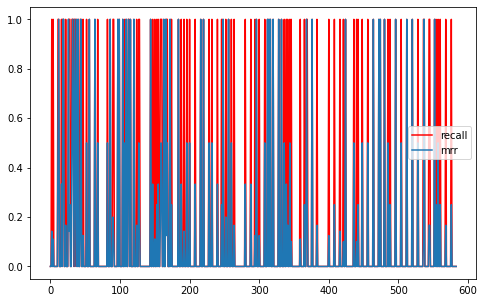

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.63]  

	 - Recall@10 epoch 15: 0.215753
	 - MRR@10    epoch 15: 0.121817



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.46it/s]


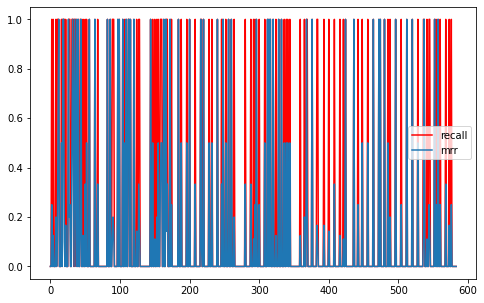

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.79] 

	 - Recall@10 epoch 16: 0.231164
	 - MRR@10    epoch 16: 0.133550



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.72it/s]


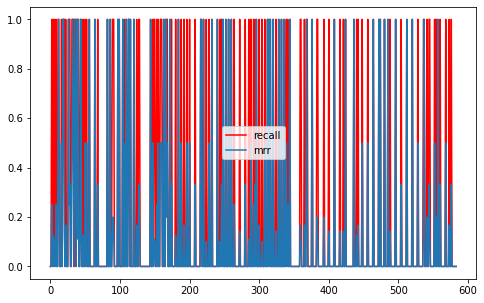

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.55] 

	 - Recall@10 epoch 17: 0.250000
	 - MRR@10    epoch 17: 0.142282



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.97it/s]


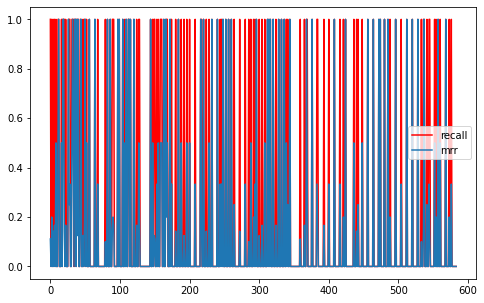

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.375, train_loss=3]   

	 - Recall@10 epoch 18: 0.255137
	 - MRR@10    epoch 18: 0.149845



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.88it/s]


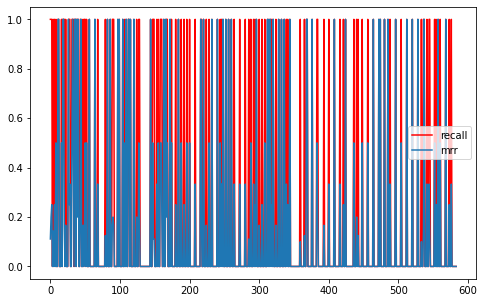

Train:   0%|          | 0/394 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.61]  

	 - Recall@10 epoch 19: 0.258562
	 - MRR@10    epoch 19: 0.153562



Evaluation:  58%|█████▊    | 73/126 [00:03<00:02, 19.88it/s]


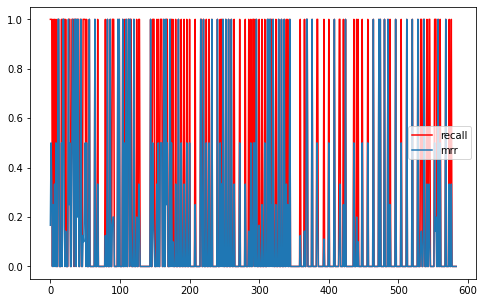

	 - Recall@10 epoch 20: 0.270548
	 - MRR@10    epoch 20: 0.159266



(0.2705479452054795, 0.159265601217656)

In [853]:
args = Args(tr, val, test, batch_size=8, hsz=50, drop_rate=0.2, lr=0.001, epochs=20, k=10)
model = create_model(args)
train_model(model, args)

Evaluation:  64%|██████▍   | 69/107 [00:04<00:02, 15.16it/s]


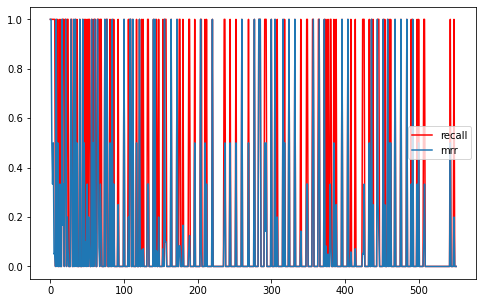

	 - Recall@10: 0.253623
	 - MRR@10: 0.138396



In [854]:
test_model(model, args, test)

## 1개월치 데이터를 사용했을 때

In [855]:
data_1 = get_data_before_month(train_data, 1)
data_1 = cleanse_recursive(data_1, shortest=2, least_click=5)

length:1551
oldest: 2003-01-29 19:36:56+00:00
latest: 2003-02-28 17:49:50+00:00


In [856]:
tr, test = split_by_date(data_1, n_days=5)
tr, val = split_by_date(tr, n_days=5)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 19
	 User Id: 4
	 Items: 7
	 First Time : 2003-02-01 02:39:15.000000
	 Last Time : 2003-02-10 18:22:34.000000

* valid Set Stats Info
	 Events: 9
	 User Id: 2
	 Items: 6
	 First Time : 2003-02-16 23:59:49.000000
	 Last Time : 2003-02-21 21:22:26.000000

* test Set Stats Info
	 Events: 7
	 User Id: 3
	 Items: 5
	 First Time : 2003-02-24 17:02:07.000000
	 Last Time : 2003-02-27 18:15:10.000000



In [857]:
tr = indexing(tr)
val = indexing(val)
test = indexing(test)

In [858]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_1month.pkl')
val.to_pickle(save_path / 'valid_1month.pkl')
test.to_pickle(save_path / 'test_1month.pkl')

In [859]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

UserId  ItemId  Rating                      Time  item_idx
58836     398    2028       4 2003-02-06 21:03:45+00:00         0
58784     398    2762       5 2003-02-06 21:09:13+00:00         1
58730     398    2628       3 2003-02-06 21:18:16+00:00         2
58837     398    3697       2 2003-02-06 21:21:04+00:00         3
58645     398    1196       4 2003-02-06 21:39:01+00:00         4
62105     419    2424       4 2003-02-10 18:10:24+00:00         5
62170     419    2028       5 2003-02-10 18:13:21+00:00         0
62078     419    1196       5 2003-02-10 18:15:20+00:00         4
62145     419    2762       5 2003-02-10 18:22:08+00:00         1
62071     419    3793       4 2003-02-10 18:22:34+00:00         6

In [860]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=1)
tr_dataset.df.head(15)

UserId  ItemId  Rating                      Time  item_idx
58836      398    2028       4 2003-02-06 21:03:45+00:00         0
58784      398    2762       5 2003-02-06 21:09:13+00:00         1
58730      398    2628       3 2003-02-06 21:18:16+00:00         2
58837      398    3697       2 2003-02-06 21:21:04+00:00         3
58645      398    1196       4 2003-02-06 21:39:01+00:00         4
62105      419    2424       4 2003-02-10 18:10:24+00:00         5
62170      419    2028       5 2003-02-10 18:13:21+00:00         0
62078      419    1196       5 2003-02-10 18:15:20+00:00         4
62145      419    2762       5 2003-02-10 18:22:08+00:00         1
62071      419    3793       4 2003-02-10 18:22:34+00:00         6
489201    3012    3697       3 2003-02-01 02:39:15+00:00         3
489371    3012    2028       4 2003-02-01 02:40:47+00:00         0
489325    3012    2762       4 2003-02-01 02:40:48+00:00         1
489149    3012    2628       2 2003-02-01 02:43:23+00:00         2
489074    3012    3793       3 2003-02-01 02:46:18+00:00         6

Train:   0%|          | 0/15 [00:00<?, ?it/s]

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(1, 1, 7)]               0         
_________________________________________________________________
GRU (GRU)                    [(1, 50), (1, 50)]        8850      
_________________________________________________________________
dropout_51 (Dropout)         (1, 50)                   0         
_________________________________________________________________
dense_51 (Dense)             (1, 7)                    357       
Total params: 9,207
Trainable params: 9,207
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


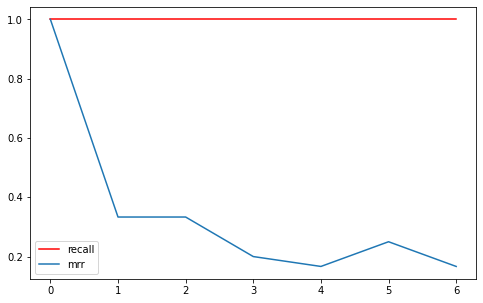

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 1: 1.000000
	 - MRR@10    epoch 1: 0.350000



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 33.61it/s]


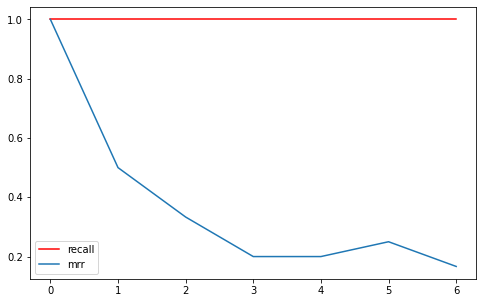

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 2: 1.000000
	 - MRR@10    epoch 2: 0.378571



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 35.02it/s]


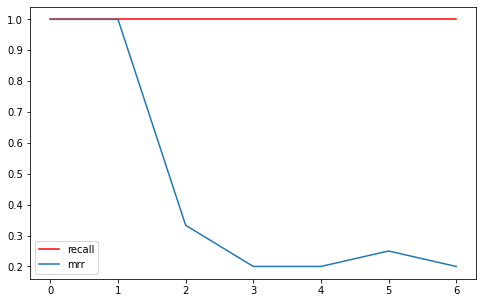

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 3: 1.000000
	 - MRR@10    epoch 3: 0.454762



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.75it/s]


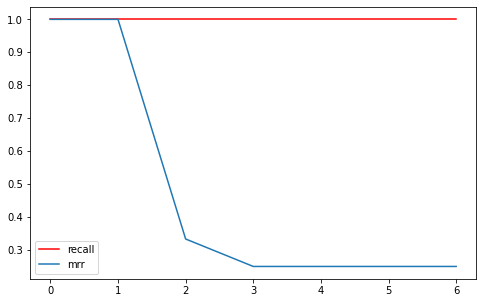

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 4: 1.000000
	 - MRR@10    epoch 4: 0.476190



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.89it/s]


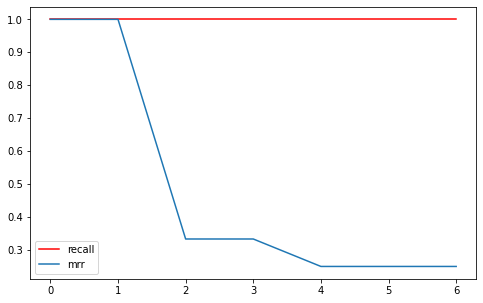

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 5: 1.000000
	 - MRR@10    epoch 5: 0.488095



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 33.35it/s]


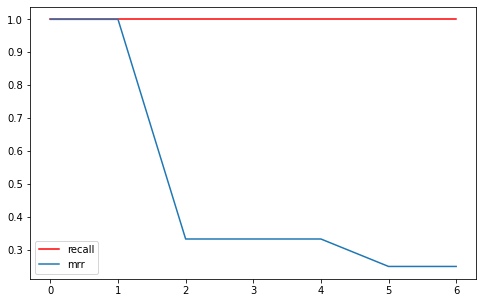

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 6: 1.000000
	 - MRR@10    epoch 6: 0.500000



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.76it/s]


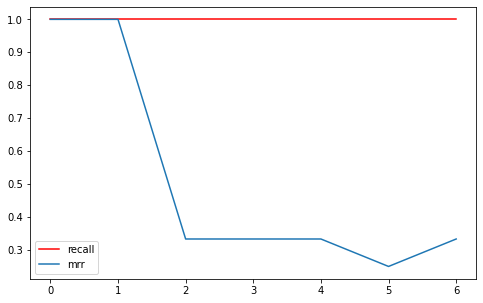

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 7: 1.000000
	 - MRR@10    epoch 7: 0.511905



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.74it/s]


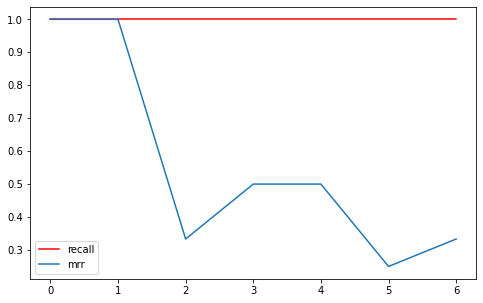

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 8: 1.000000
	 - MRR@10    epoch 8: 0.559524



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 33.73it/s]


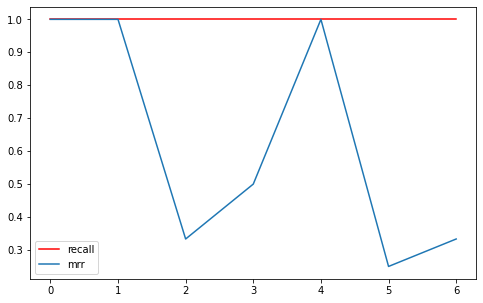

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 9: 1.000000
	 - MRR@10    epoch 9: 0.630952



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.38it/s]


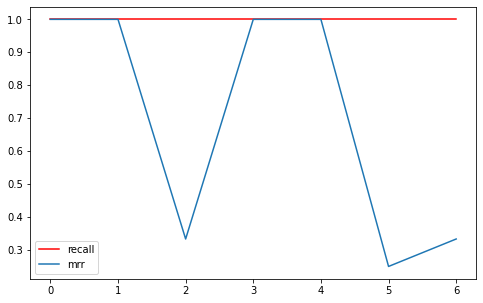

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 10: 1.000000
	 - MRR@10    epoch 10: 0.702381



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.45it/s]


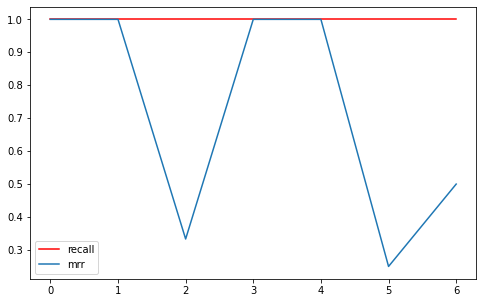

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 11: 1.000000
	 - MRR@10    epoch 11: 0.726190



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.15it/s]


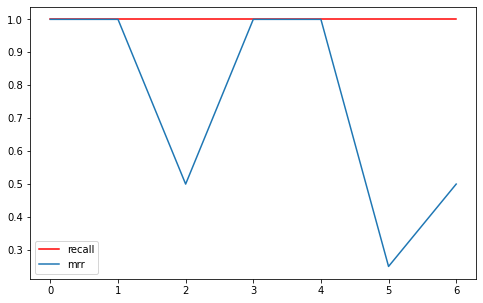

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 12: 1.000000
	 - MRR@10    epoch 12: 0.750000



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 33.43it/s]


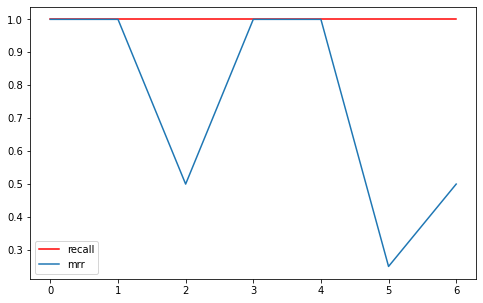

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 13: 1.000000
	 - MRR@10    epoch 13: 0.750000



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.96it/s]


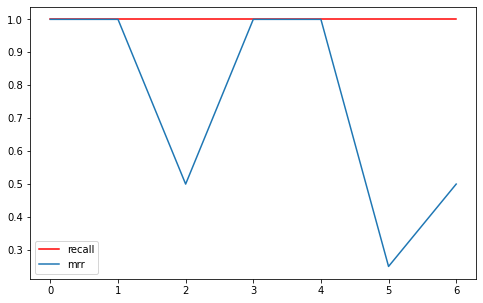

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 14: 1.000000
	 - MRR@10    epoch 14: 0.750000



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.75it/s]


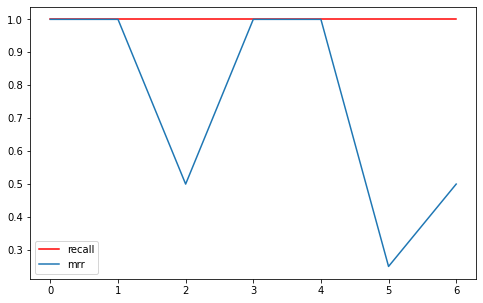

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 15: 1.000000
	 - MRR@10    epoch 15: 0.750000



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 33.83it/s]


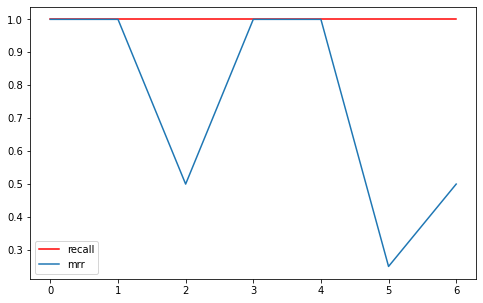

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 16: 1.000000
	 - MRR@10    epoch 16: 0.750000



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.17it/s]


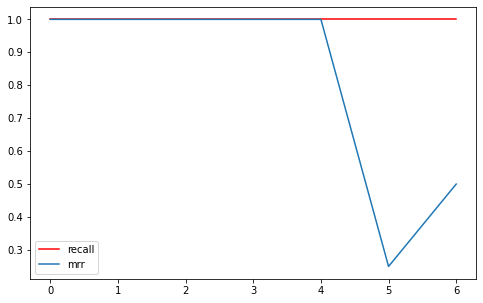

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 17: 1.000000
	 - MRR@10    epoch 17: 0.821429



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.67it/s]


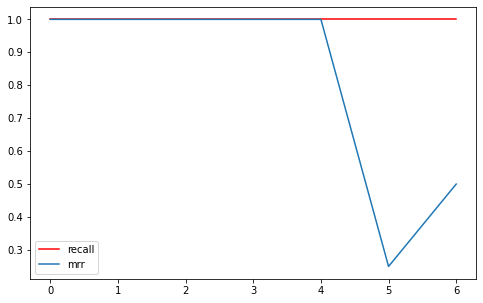

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 18: 1.000000
	 - MRR@10    epoch 18: 0.821429



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.74it/s]


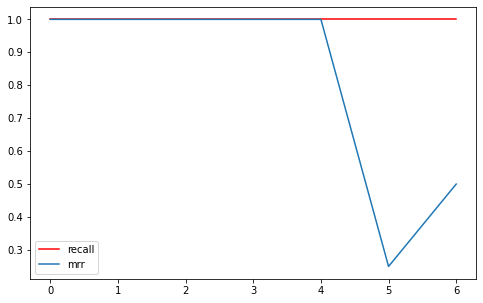

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@10 epoch 19: 1.000000
	 - MRR@10    epoch 19: 0.821429



Evaluation: 100%|██████████| 7/7 [00:00<00:00, 34.77it/s]


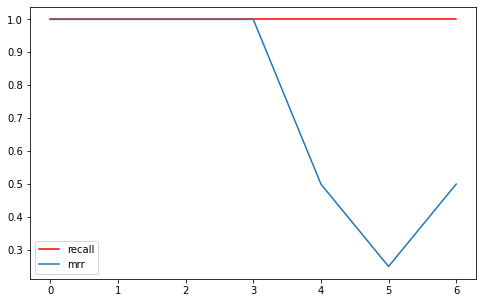

	 - Recall@10 epoch 20: 1.000000
	 - MRR@10    epoch 20: 0.750000



(1.0, 0.75)

In [861]:
args = Args(tr, val, test, batch_size=1, hsz=50, drop_rate=0.2, lr=0.001, epochs=20, k=10)
model = create_model(args)
train_model(model, args)

Evaluation: 100%|██████████| 4/4 [00:00<00:00, 33.70it/s]


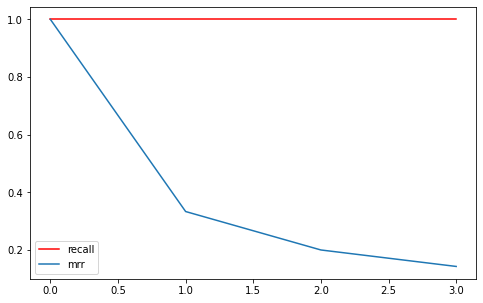

	 - Recall@10: 1.000000
	 - MRR@10: 0.419048



In [862]:
test_model(model, args, test)

## 12개월치 데이터를 사용했을 때

In [863]:
data_12 = get_data_before_month(train_data, 12)
data_12 = cleanse_recursive(data_12, shortest=2, least_click=5)

length:21093
oldest: 2002-03-05 18:25:38+00:00
latest: 2003-02-28 17:49:50+00:00


In [864]:
tr, test = split_by_date(data_12, n_days=30)
tr, val = split_by_date(tr, n_days=60)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 14018
	 User Id: 414
	 Items: 1504
	 First Time : 2002-03-05 18:25:38.000000
	 Last Time : 2002-11-30 13:47:32.000000

* valid Set Stats Info
	 Events: 2668
	 User Id: 192
	 Items: 1141
	 First Time : 2002-11-30 20:24:52.000000
	 Last Time : 2003-01-29 17:00:13.000000

* test Set Stats Info
	 Events: 1356
	 User Id: 95
	 Items: 828
	 First Time : 2003-01-29 19:36:56.000000
	 Last Time : 2003-02-28 17:49:50.000000



In [865]:
tr = indexing(tr)
val = indexing(val)
test = indexing(test)

In [866]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_1month.pkl')
val.to_pickle(save_path / 'valid_1month.pkl')
test.to_pickle(save_path / 'test_1month.pkl')

In [867]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

UserId  ItemId  Rating                      Time  item_idx
5170      36    1387       5 2002-03-12 03:46:59+00:00         0
5267      36    1201       4 2002-03-12 03:46:59+00:00         1
5122      36    1291       5 2002-03-12 03:47:16+00:00         2
5123      36    2167       5 2002-03-12 03:48:25+00:00         3
5290      36    2951       4 2002-03-12 03:48:25+00:00         4
5359      36    2115       5 2002-03-12 03:48:25+00:00         5
5073      36    1912       5 2002-03-12 03:48:44+00:00         6
5113      36    2662       3 2002-03-12 03:48:44+00:00         7
5366      36    2985       4 2002-03-12 03:49:01+00:00         8
5145      36     198       5 2002-03-12 03:49:48+00:00         9

In [868]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

UserId  ItemId  Rating                      Time  item_idx
5170      36    1387       5 2002-03-12 03:46:59+00:00         0
5267      36    1201       4 2002-03-12 03:46:59+00:00         1
5122      36    1291       5 2002-03-12 03:47:16+00:00         2
5123      36    2167       5 2002-03-12 03:48:25+00:00         3
5290      36    2951       4 2002-03-12 03:48:25+00:00         4
5359      36    2115       5 2002-03-12 03:48:25+00:00         5
5073      36    1912       5 2002-03-12 03:48:44+00:00         6
5113      36    2662       3 2002-03-12 03:48:44+00:00         7
5366      36    2985       4 2002-03-12 03:49:01+00:00         8
5145      36     198       5 2002-03-12 03:49:48+00:00         9
5296      36    1147       4 2002-03-12 03:51:51+00:00        10
5034      36     581       4 2002-03-12 03:52:07+00:00        11
5060      36    1191       4 2002-03-12 03:54:09+00:00        12
5025      36    3359       5 2002-03-12 03:58:05+00:00        13
5325      36     553       4 2002-03-12 04:00:26+00:00        14

Train:   0%|          | 0/212 [00:00<?, ?it/s]

Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(64, 1, 1504)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      233400    
_________________________________________________________________
dropout_52 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_52 (Dense)             (64, 1504)                76704     
Total params: 310,104
Trainable params: 310,104
Non-trainable params: 0
_________________________________________________________________


Evaluation:  34%|███▍      | 13/38 [00:03<00:06,  3.93it/s]


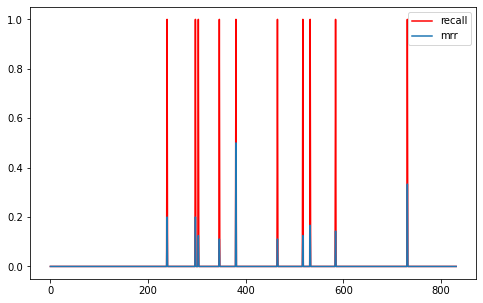

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=7.15]     

	 - Recall@10 epoch 1: 0.012019
	 - MRR@10    epoch 1: 0.002422



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.32it/s]


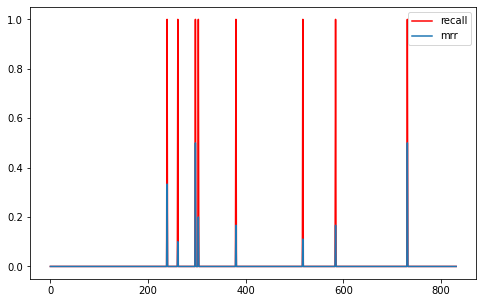

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=7.07]     

	 - Recall@10 epoch 2: 0.009615
	 - MRR@10    epoch 2: 0.002497



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.29it/s]


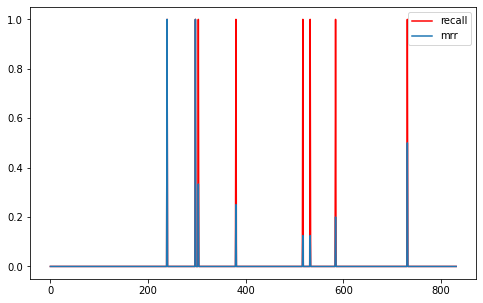

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=7.05]     

	 - Recall@10 epoch 3: 0.009615
	 - MRR@10    epoch 3: 0.004247



Evaluation:  34%|███▍      | 13/38 [00:02<00:05,  4.35it/s]


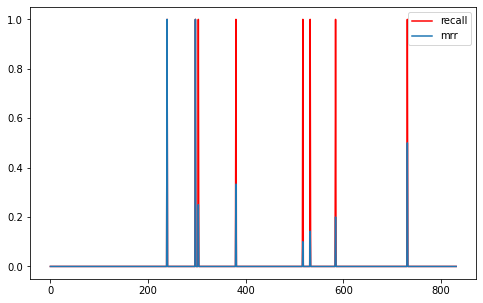

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=7.04]     

	 - Recall@10 epoch 4: 0.009615
	 - MRR@10    epoch 4: 0.004238



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.32it/s]


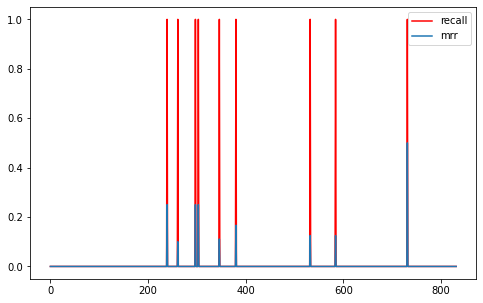

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=7.05]     

	 - Recall@10 epoch 5: 0.010817
	 - MRR@10    epoch 5: 0.002257



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.29it/s]


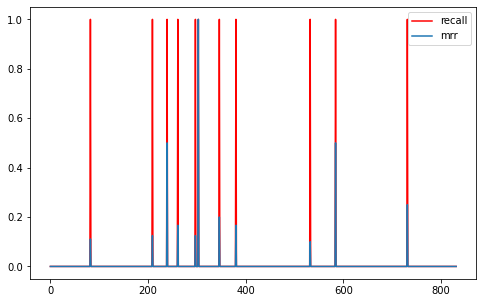

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=7.02]     

	 - Recall@10 epoch 6: 0.013221
	 - MRR@10    epoch 6: 0.003900



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.32it/s]


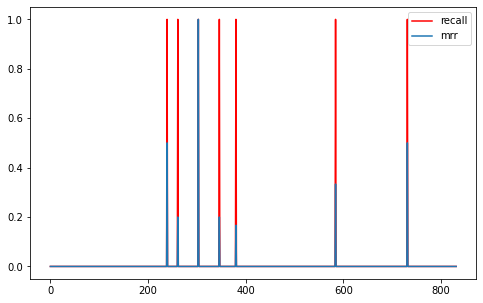

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=6.98]     

	 - Recall@10 epoch 7: 0.008413
	 - MRR@10    epoch 7: 0.003486



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.28it/s]


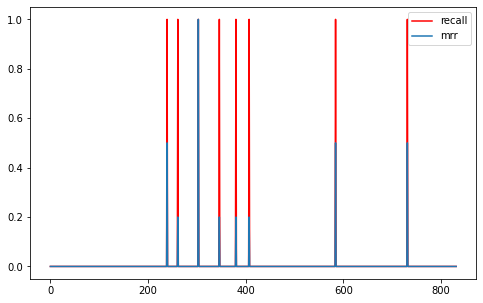

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=6.94]     

	 - Recall@10 epoch 8: 0.009615
	 - MRR@10    epoch 8: 0.003966



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.25it/s]


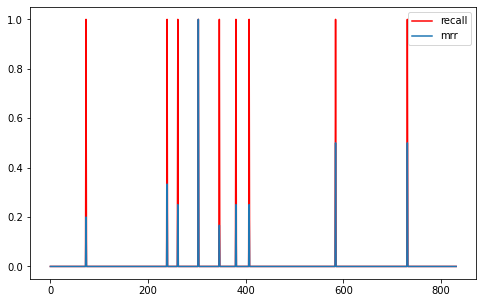

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=6.9]      

	 - Recall@10 epoch 9: 0.010817
	 - MRR@10    epoch 9: 0.004147



Evaluation:  34%|███▍      | 13/38 [00:02<00:05,  4.37it/s]


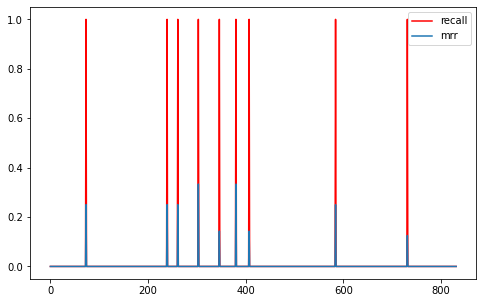

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0, train_loss=6.8]      

	 - Recall@10 epoch 10: 0.010817
	 - MRR@10    epoch 10: 0.002497



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.32it/s]


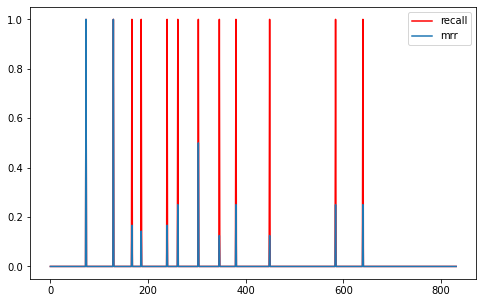

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.77]

	 - Recall@10 epoch 11: 0.014423
	 - MRR@10    epoch 11: 0.005080



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.33it/s]


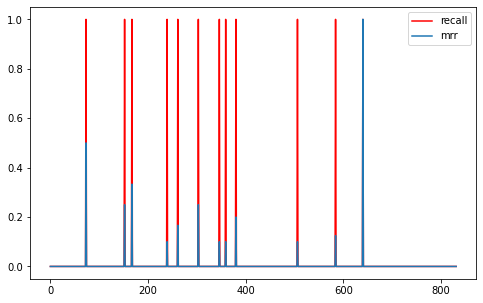

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.43]

	 - Recall@10 epoch 12: 0.014423
	 - MRR@10    epoch 12: 0.003876



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.32it/s]


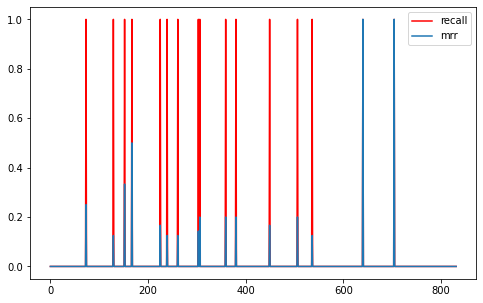

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.59]

	 - Recall@10 epoch 13: 0.019231
	 - MRR@10    epoch 13: 0.005841



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.33it/s]


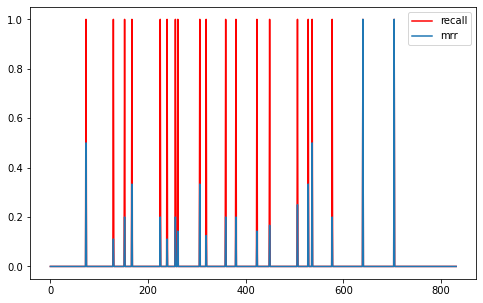

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.38]

	 - Recall@10 epoch 14: 0.024038
	 - MRR@10    epoch 14: 0.007512



Evaluation:  34%|███▍      | 13/38 [00:03<00:05,  4.33it/s]


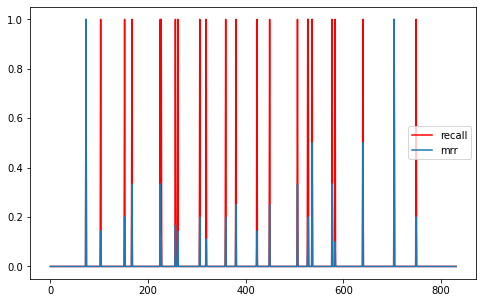

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.4] 

	 - Recall@10 epoch 15: 0.027644
	 - MRR@10    epoch 15: 0.008264



Evaluation:  34%|███▍      | 13/38 [00:02<00:05,  4.39it/s]


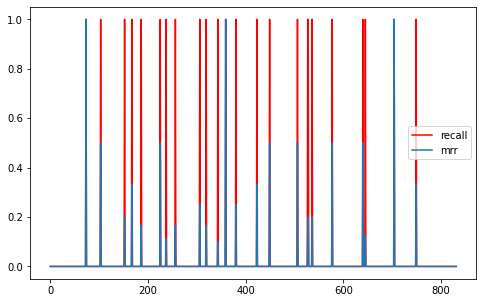

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.25]

	 - Recall@10 epoch 16: 0.028846
	 - MRR@10    epoch 16: 0.010891



Evaluation:  34%|███▍      | 13/38 [00:02<00:05,  4.39it/s]


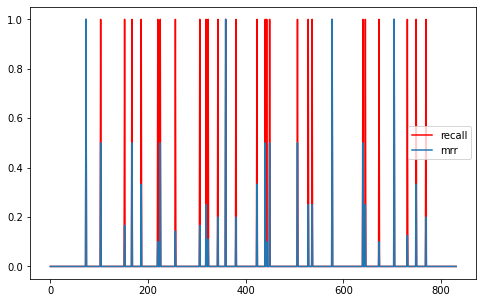

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.141, train_loss=5.93] 

	 - Recall@10 epoch 17: 0.034856
	 - MRR@10    epoch 17: 0.013356



Evaluation:  34%|███▍      | 13/38 [00:02<00:05,  4.42it/s]


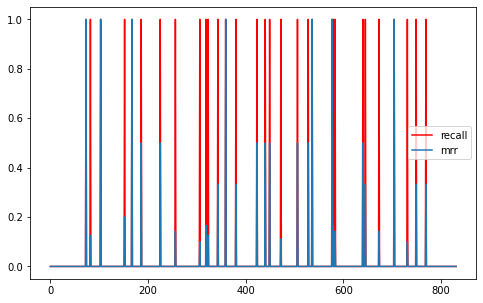

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.93]

	 - Recall@10 epoch 18: 0.037260
	 - MRR@10    epoch 18: 0.017055



Evaluation:  34%|███▍      | 13/38 [00:02<00:05,  4.40it/s]


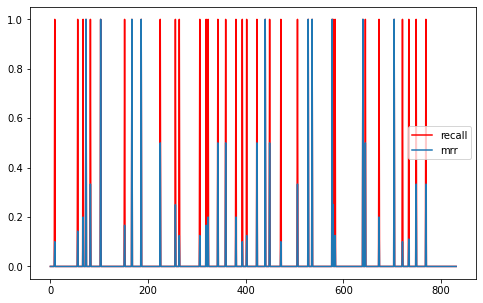

Train:   0%|          | 0/212 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.86]

	 - Recall@10 epoch 19: 0.045673
	 - MRR@10    epoch 19: 0.020578



Evaluation:  34%|███▍      | 13/38 [00:02<00:05,  4.35it/s]


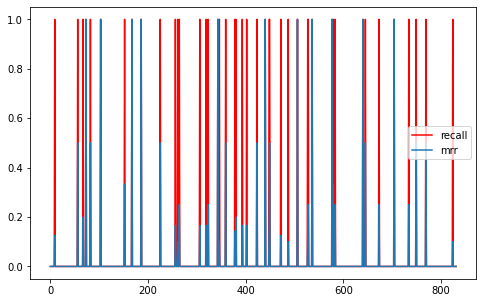

	 - Recall@10 epoch 20: 0.052885
	 - MRR@10    epoch 20: 0.024003



(0.052884615384615384, 0.024003166971916973)

In [869]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.2, lr=0.001, epochs=20, k=10)
model = create_model(args)
train_model(model, args)

Evaluation:   5%|▌         | 1/19 [00:00<00:06,  2.75it/s]


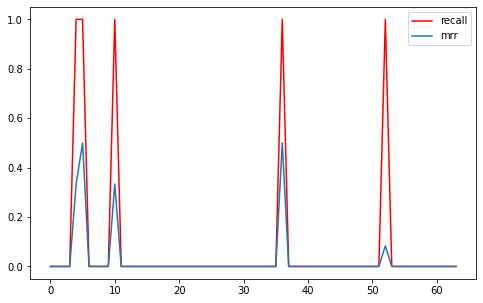

	 - Recall@10: 0.078125
	 - MRR@10: 0.027344



In [870]:
test_model(model, args, test)

## Summarize

In [871]:
pd.DataFrame(test_summary_metrix, index=[3,6,1,12]) # index는 month

recall       mrr
3   0.406250  0.240036
6   0.253623  0.138396
1   1.000000  0.419048
12  0.078125  0.027344

가장 최근 데이터인 1개월치 데이터의 recall과 mrr값이 가장 높고, 그 다음은 3개월 데이터가, 그 다음은 6개월 데이터가 순으로 높았다. 
하지만 1개월치 데이터를 보면 valid와 test 데이터 양이 현저하게 적은 것을 볼 수 있다. 아무리 평가지표가 높게 나왔어도 적은 데이터 수로 좋은 모델이라고 평가를 내리기는 힘들 것 같다.    
반대로 12개월 데이터를 가지고 테스트를 했을 때는 점수가 현저히 낮은 것을 볼 수 있다. 이를 통해서 추천 시스템의 경우 기간을 선정하는 것이 성능을 좌우한다는 것을 알았다.

## 하이퍼파라미터 변경해서 테스트
제일 적절한 기간이라고 생각하는 3개월데이터를 하지고 하이퍼파라미터를 조정해서 테스트를 해보도록 하자.

In [872]:
save_path = data_path / 'processed'
train_3 = pd.read_pickle(save_path / 'train_3month.pkl')
valid_3 = pd.read_pickle(save_path / 'valid_3month.pkl')
test_3 = pd.read_pickle(save_path / 'test_3month.pkl')

In [873]:
stats_info(train_3, 'train')
stats_info(valid_3, 'valid')
stats_info(test_3, 'test')

* train Set Stats Info
	 Events: 1321
	 User Id: 132
	 Items: 231
	 First Time : 2002-12-01 04:17:00.000000
	 Last Time : 2003-02-08 15:14:46.000000

* valid Set Stats Info
	 Events: 121
	 User Id: 24
	 Items: 96
	 First Time : 2003-02-08 22:46:24.000000
	 Last Time : 2003-02-18 17:36:46.000000

* test Set Stats Info
	 Events: 164
	 User Id: 27
	 Items: 117
	 First Time : 2003-02-18 23:13:57.000000
	 Last Time : 2003-02-28 17:45:20.000000



In [874]:
tr_dataset = SessionDataset(train_3)
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

#### epochs과 learning_rate 변경

In [877]:
args_list = []
for epoch in range(10,110,10):
    for learning_rate in [0.001, 0.05, 0.1]:
        args = Args(train_3, valid_3, test_3, batch_size=8, hsz=50, drop_rate=0.2, lr=learning_rate, epochs=epoch, k=10)
        args_list.append(args)

In [879]:
arg_dic={}
for arg in args_list:
    print(f'epoch: {arg.epochs}, learning_rate: {arg.lr}')
    model = create_model(arg)
    recall, mrr = train_model(model, arg, display_flg=False)
    
    print(f'recall: {recall}, mrr: {mrr}')
    
    arg_dic[arg] = [recall, mrr]

epoch: 10, learning_rate: 0.001


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_78 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_78 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.34]

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.111979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.13]

	 - Recall@10 epoch 2: 0.312500
	 - MRR@10    epoch 2: 0.152778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.13]

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.067708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5]       

	 - Recall@10 epoch 4: 0.250000
	 - MRR@10    epoch 4: 0.052331



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.94]

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.070312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.82]

	 - Recall@10 epoch 6: 0.312500
	 - MRR@10    epoch 6: 0.143229



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.7] 

	 - Recall@10 epoch 7: 0.375000
	 - MRR@10    epoch 7: 0.200694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.78]    

	 - Recall@10 epoch 8: 0.375000
	 - MRR@10    epoch 8: 0.241319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.28] 

	 - Recall@10 epoch 9: 0.500000
	 - MRR@10    epoch 9: 0.298611



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 10: 0.562500
	 - MRR@10    epoch 10: 0.341667

recall: 0.5625, mrr: 0.3416666666666667
epoch: 10, learning_rate: 0.05
Model: "model_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_79 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_79 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.28]    

	 - Recall@10 epoch 1: 0.125000
	 - MRR@10    epoch 1: 0.014757



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.44]

	 - Recall@10 epoch 2: 0.125000
	 - MRR@10    epoch 2: 0.040179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.17]    

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.022123



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.54]    

	 - Recall@10 epoch 4: 0.312500
	 - MRR@10    epoch 4: 0.097396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.34]

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.171429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.35]    

	 - Recall@10 epoch 6: 0.437500
	 - MRR@10    epoch 6: 0.179688



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.67]

	 - Recall@10 epoch 7: 0.437500
	 - MRR@10    epoch 7: 0.122396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.67]    

	 - Recall@10 epoch 8: 0.500000
	 - MRR@10    epoch 8: 0.141840



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.59]

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.135417



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 10: 0.437500
	 - MRR@10    epoch 10: 0.136706

recall: 0.4375, mrr: 0.1367063492063492
epoch: 10, learning_rate: 0.1
Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_80 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_80 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.83]    

	 - Recall@10 epoch 1: 0.187500
	 - MRR@10    epoch 1: 0.087054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.83]    

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.041146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10]      

	 - Recall@10 epoch 3: 0.125000
	 - MRR@10    epoch 3: 0.041667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.9]

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.040179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.6]    

	 - Recall@10 epoch 5: 0.187500
	 - MRR@10    epoch 5: 0.031498



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.87]

	 - Recall@10 epoch 6: 0.062500
	 - MRR@10    epoch 6: 0.012500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11]      

	 - Recall@10 epoch 7: 0.187500
	 - MRR@10    epoch 7: 0.072917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.6]

	 - Recall@10 epoch 8: 0.250000
	 - MRR@10    epoch 8: 0.114583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.6]    

	 - Recall@10 epoch 9: 0.062500
	 - MRR@10    epoch 9: 0.020833



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 10: 0.062500
	 - MRR@10    epoch 10: 0.031250

recall: 0.0625, mrr: 0.03125
epoch: 20, learning_rate: 0.001
Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_81 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_81 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.4]     

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.130208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.3]     

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.109375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.36]    

	 - Recall@10 epoch 3: 0.312500
	 - MRR@10    epoch 3: 0.087153



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.1]     

	 - Recall@10 epoch 4: 0.250000
	 - MRR@10    epoch 4: 0.083333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.04] 

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.194444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.95]

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.162500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.66] 

	 - Recall@10 epoch 7: 0.250000
	 - MRR@10    epoch 7: 0.162500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.79] 

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.234375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.3] 

	 - Recall@10 epoch 9: 0.437500
	 - MRR@10    epoch 9: 0.252778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.27]

	 - Recall@10 epoch 10: 0.375000
	 - MRR@10    epoch 10: 0.293750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.22]

	 - Recall@10 epoch 11: 0.375000
	 - MRR@10    epoch 11: 0.343750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.51]

	 - Recall@10 epoch 12: 0.437500
	 - MRR@10    epoch 12: 0.351562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.84] 

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.351562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.4] 

	 - Recall@10 epoch 14: 0.500000
	 - MRR@10    epoch 14: 0.391741



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.11]

	 - Recall@10 epoch 15: 0.500000
	 - MRR@10    epoch 15: 0.364063



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.87]  

	 - Recall@10 epoch 16: 0.500000
	 - MRR@10    epoch 16: 0.363194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.54]

	 - Recall@10 epoch 17: 0.500000
	 - MRR@10    epoch 17: 0.368750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.42]

	 - Recall@10 epoch 18: 0.500000
	 - MRR@10    epoch 18: 0.371875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.32]

	 - Recall@10 epoch 19: 0.562500
	 - MRR@10    epoch 19: 0.375248



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.28it/s]


	 - Recall@10 epoch 20: 0.500000
	 - MRR@10    epoch 20: 0.335417

recall: 0.5, mrr: 0.3354166666666667
epoch: 20, learning_rate: 0.05


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_82 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_82 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.33]    

	 - Recall@10 epoch 1: 0.062500
	 - MRR@10    epoch 1: 0.006250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.1]     

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.044866



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.85] 

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.053819



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.77]    

	 - Recall@10 epoch 4: 0.312500
	 - MRR@10    epoch 4: 0.062128



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.93]

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.122991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.57]    

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.092882



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.7] 

	 - Recall@10 epoch 7: 0.250000
	 - MRR@10    epoch 7: 0.101190



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.46]

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.084375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.4]    

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.044866



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.64]

	 - Recall@10 epoch 10: 0.437500
	 - MRR@10    epoch 10: 0.091667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.84]

	 - Recall@10 epoch 11: 0.312500
	 - MRR@10    epoch 11: 0.147569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.92]

	 - Recall@10 epoch 12: 0.312500
	 - MRR@10    epoch 12: 0.069940



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.81]    

	 - Recall@10 epoch 13: 0.375000
	 - MRR@10    epoch 13: 0.143750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.23]

	 - Recall@10 epoch 14: 0.375000
	 - MRR@10    epoch 14: 0.093998



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.21]    

	 - Recall@10 epoch 15: 0.500000
	 - MRR@10    epoch 15: 0.333333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.48]

	 - Recall@10 epoch 16: 0.437500
	 - MRR@10    epoch 16: 0.151290



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.39]  

	 - Recall@10 epoch 17: 0.437500
	 - MRR@10    epoch 17: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.37]  

	 - Recall@10 epoch 18: 0.375000
	 - MRR@10    epoch 18: 0.197917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.91]

	 - Recall@10 epoch 19: 0.375000
	 - MRR@10    epoch 19: 0.236979



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 20: 0.500000
	 - MRR@10    epoch 20: 0.172569

recall: 0.5, mrr: 0.17256944444444444
epoch: 20, learning_rate: 0.1
Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_83 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_83 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.77]

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.045833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.49]    

	 - Recall@10 epoch 2: 0.187500
	 - MRR@10    epoch 2: 0.048958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.1]    

	 - Recall@10 epoch 3: 0.125000
	 - MRR@10    epoch 3: 0.013194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.56]    

	 - Recall@10 epoch 4: 0.062500
	 - MRR@10    epoch 4: 0.012500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.04]

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.101190



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.3]    

	 - Recall@10 epoch 6: 0.062500
	 - MRR@10    epoch 6: 0.010417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.6]    

	 - Recall@10 epoch 7: 0.125000
	 - MRR@10    epoch 7: 0.015873



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.5]    

	 - Recall@10 epoch 8: 0.062500
	 - MRR@10    epoch 8: 0.020833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.01] 

	 - Recall@10 epoch 9: 0.062500
	 - MRR@10    epoch 9: 0.010417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.6]    

	 - Recall@10 epoch 10: 0.187500
	 - MRR@10    epoch 10: 0.106250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=17.4]    

	 - Recall@10 epoch 11: 0.125000
	 - MRR@10    epoch 11: 0.041667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.1]    

	 - Recall@10 epoch 12: 0.312500
	 - MRR@10    epoch 12: 0.129167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.9]    

	 - Recall@10 epoch 13: 0.312500
	 - MRR@10    epoch 13: 0.115625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.57] 

	 - Recall@10 epoch 14: 0.187500
	 - MRR@10    epoch 14: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=14.4]

	 - Recall@10 epoch 15: 0.250000
	 - MRR@10    epoch 15: 0.064236



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.4]    

	 - Recall@10 epoch 16: 0.312500
	 - MRR@10    epoch 16: 0.130456



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.96]

	 - Recall@10 epoch 17: 0.312500
	 - MRR@10    epoch 17: 0.168403



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.98] 

	 - Recall@10 epoch 18: 0.437500
	 - MRR@10    epoch 18: 0.155208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.3]    

	 - Recall@10 epoch 19: 0.250000
	 - MRR@10    epoch 19: 0.067956



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.44it/s]


	 - Recall@10 epoch 20: 0.312500
	 - MRR@10    epoch 20: 0.122396

recall: 0.3125, mrr: 0.12239583333333333
epoch: 30, learning_rate: 0.001
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_84 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_84 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.36]    

	 - Recall@10 epoch 1: 0.312500
	 - MRR@10    epoch 1: 0.173958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.31]    

	 - Recall@10 epoch 2: 0.312500
	 - MRR@10    epoch 2: 0.090625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.13]    

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.050595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.32]    

	 - Recall@10 epoch 4: 0.250000
	 - MRR@10    epoch 4: 0.051562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.26]    

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.093750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.86]

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.177083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.64]

	 - Recall@10 epoch 7: 0.312500
	 - MRR@10    epoch 7: 0.216146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.58] 

	 - Recall@10 epoch 8: 0.500000
	 - MRR@10    epoch 8: 0.273065



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.62]

	 - Recall@10 epoch 9: 0.562500
	 - MRR@10    epoch 9: 0.411012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.31]

	 - Recall@10 epoch 10: 0.562500
	 - MRR@10    epoch 10: 0.463542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.2] 

	 - Recall@10 epoch 11: 0.562500
	 - MRR@10    epoch 11: 0.473958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.99] 

	 - Recall@10 epoch 12: 0.562500
	 - MRR@10    epoch 12: 0.463542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.67] 

	 - Recall@10 epoch 13: 0.562500
	 - MRR@10    epoch 13: 0.437500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.38]

	 - Recall@10 epoch 14: 0.562500
	 - MRR@10    epoch 14: 0.421875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.29]  

	 - Recall@10 epoch 15: 0.562500
	 - MRR@10    epoch 15: 0.423958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.9]   

	 - Recall@10 epoch 16: 0.562500
	 - MRR@10    epoch 16: 0.375595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.14]  

	 - Recall@10 epoch 17: 0.500000
	 - MRR@10    epoch 17: 0.380208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.31]  

	 - Recall@10 epoch 18: 0.500000
	 - MRR@10    epoch 18: 0.373512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.96]

	 - Recall@10 epoch 19: 0.500000
	 - MRR@10    epoch 19: 0.338542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.66]

	 - Recall@10 epoch 20: 0.500000
	 - MRR@10    epoch 20: 0.335938



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.66]

	 - Recall@10 epoch 21: 0.500000
	 - MRR@10    epoch 21: 0.340625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.22]  

	 - Recall@10 epoch 22: 0.500000
	 - MRR@10    epoch 22: 0.368750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.97] 

	 - Recall@10 epoch 23: 0.500000
	 - MRR@10    epoch 23: 0.328125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.68]  

	 - Recall@10 epoch 24: 0.500000
	 - MRR@10    epoch 24: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.98]

	 - Recall@10 epoch 25: 0.500000
	 - MRR@10    epoch 25: 0.296875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.97]

	 - Recall@10 epoch 26: 0.500000
	 - MRR@10    epoch 26: 0.288542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.88]  

	 - Recall@10 epoch 27: 0.500000
	 - MRR@10    epoch 27: 0.267708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.34] 

	 - Recall@10 epoch 28: 0.500000
	 - MRR@10    epoch 28: 0.262500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.85]

	 - Recall@10 epoch 29: 0.500000
	 - MRR@10    epoch 29: 0.257887



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.21it/s]


	 - Recall@10 epoch 30: 0.500000
	 - MRR@10    epoch 30: 0.257887

recall: 0.5, mrr: 0.2578869047619048
epoch: 30, learning_rate: 0.05
Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_85 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_85 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.3]     

	 - Recall@10 epoch 1: 0.187500
	 - MRR@10    epoch 1: 0.102679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.43]    

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.56] 

	 - Recall@10 epoch 3: 0.312500
	 - MRR@10    epoch 3: 0.046602



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.97]    

	 - Recall@10 epoch 4: 0.187500
	 - MRR@10    epoch 4: 0.032986



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.86] 

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.227679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.41]

	 - Recall@10 epoch 6: 0.187500
	 - MRR@10    epoch 6: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.14]

	 - Recall@10 epoch 7: 0.500000
	 - MRR@10    epoch 7: 0.159896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.45] 

	 - Recall@10 epoch 8: 0.125000
	 - MRR@10    epoch 8: 0.041667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.31] 

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.153125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.98]  

	 - Recall@10 epoch 10: 0.250000
	 - MRR@10    epoch 10: 0.095833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.17]

	 - Recall@10 epoch 11: 0.312500
	 - MRR@10    epoch 11: 0.097470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.15] 

	 - Recall@10 epoch 12: 0.437500
	 - MRR@10    epoch 12: 0.215179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.6] 

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.253646



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.5] 

	 - Recall@10 epoch 14: 0.375000
	 - MRR@10    epoch 14: 0.143824



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.97]

	 - Recall@10 epoch 15: 0.250000
	 - MRR@10    epoch 15: 0.152778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.88]  

	 - Recall@10 epoch 16: 0.187500
	 - MRR@10    epoch 16: 0.085069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.29]

	 - Recall@10 epoch 17: 0.375000
	 - MRR@10    epoch 17: 0.114583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.2]   

	 - Recall@10 epoch 18: 0.250000
	 - MRR@10    epoch 18: 0.064732



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.12]  

	 - Recall@10 epoch 19: 0.250000
	 - MRR@10    epoch 19: 0.147917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.91]

	 - Recall@10 epoch 20: 0.375000
	 - MRR@10    epoch 20: 0.163170



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.88]  

	 - Recall@10 epoch 21: 0.562500
	 - MRR@10    epoch 21: 0.208929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.41] 

	 - Recall@10 epoch 22: 0.312500
	 - MRR@10    epoch 22: 0.149554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.35] 

	 - Recall@10 epoch 23: 0.437500
	 - MRR@10    epoch 23: 0.146429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.17]

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.075769



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.8]  

	 - Recall@10 epoch 25: 0.250000
	 - MRR@10    epoch 25: 0.095486



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.42]

	 - Recall@10 epoch 26: 0.500000
	 - MRR@10    epoch 26: 0.286706



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.91]  

	 - Recall@10 epoch 27: 0.500000
	 - MRR@10    epoch 27: 0.247024



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.62]  

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.126562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.63]

	 - Recall@10 epoch 29: 0.250000
	 - MRR@10    epoch 29: 0.042708



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 30: 0.375000
	 - MRR@10    epoch 30: 0.105903

recall: 0.375, mrr: 0.10590277777777778
epoch: 30, learning_rate: 0.1
Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_86 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_86 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.14]    

	 - Recall@10 epoch 1: 0.187500
	 - MRR@10    epoch 1: 0.029514



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.1]    

	 - Recall@10 epoch 2: 0.000000
	 - MRR@10    epoch 2: 0.000000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.2]

	 - Recall@10 epoch 3: 0.125000
	 - MRR@10    epoch 3: 0.068750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.7]    

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.1]    

	 - Recall@10 epoch 5: 0.062500
	 - MRR@10    epoch 5: 0.007812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.1]

	 - Recall@10 epoch 6: 0.187500
	 - MRR@10    epoch 6: 0.087054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=16.9]    

	 - Recall@10 epoch 7: 0.187500
	 - MRR@10    epoch 7: 0.132812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.44]

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.127604



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.8]    

	 - Recall@10 epoch 9: 0.062500
	 - MRR@10    epoch 9: 0.010417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.2]    

	 - Recall@10 epoch 10: 0.187500
	 - MRR@10    epoch 10: 0.078125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.34]    

	 - Recall@10 epoch 11: 0.187500
	 - MRR@10    epoch 11: 0.037500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=18.9]    

	 - Recall@10 epoch 12: 0.250000
	 - MRR@10    epoch 12: 0.088790



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.5]

	 - Recall@10 epoch 13: 0.125000
	 - MRR@10    epoch 13: 0.038194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.9] 

	 - Recall@10 epoch 14: 0.187500
	 - MRR@10    epoch 14: 0.052679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.9]    

	 - Recall@10 epoch 15: 0.250000
	 - MRR@10    epoch 15: 0.075521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.4]

	 - Recall@10 epoch 16: 0.187500
	 - MRR@10    epoch 16: 0.081845



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=19.3]    

	 - Recall@10 epoch 17: 0.250000
	 - MRR@10    epoch 17: 0.094345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=17.1] 

	 - Recall@10 epoch 18: 0.187500
	 - MRR@10    epoch 18: 0.090625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.2] 

	 - Recall@10 epoch 19: 0.250000
	 - MRR@10    epoch 19: 0.052083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.5]    

	 - Recall@10 epoch 20: 0.125000
	 - MRR@10    epoch 20: 0.125000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.97]

	 - Recall@10 epoch 21: 0.125000
	 - MRR@10    epoch 21: 0.019444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.7]    

	 - Recall@10 epoch 22: 0.250000
	 - MRR@10    epoch 22: 0.095833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.4]    

	 - Recall@10 epoch 23: 0.375000
	 - MRR@10    epoch 23: 0.236979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.68] 

	 - Recall@10 epoch 24: 0.187500
	 - MRR@10    epoch 24: 0.090278



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10.4]

	 - Recall@10 epoch 25: 0.375000
	 - MRR@10    epoch 25: 0.171429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.09] 

	 - Recall@10 epoch 26: 0.250000
	 - MRR@10    epoch 26: 0.037326



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.5] 

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.210417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=16.6]

	 - Recall@10 epoch 28: 0.312500
	 - MRR@10    epoch 28: 0.234375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.7] 

	 - Recall@10 epoch 29: 0.250000
	 - MRR@10    epoch 29: 0.116667



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 30: 0.312500
	 - MRR@10    epoch 30: 0.101562

recall: 0.3125, mrr: 0.1015625
epoch: 40, learning_rate: 0.001
Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_87 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_87 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.4]     

	 - Recall@10 epoch 1: 0.312500
	 - MRR@10    epoch 1: 0.088790



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.29]    

	 - Recall@10 epoch 2: 0.312500
	 - MRR@10    epoch 2: 0.164062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.2]     

	 - Recall@10 epoch 3: 0.125000
	 - MRR@10    epoch 3: 0.125000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.17]    

	 - Recall@10 epoch 4: 0.187500
	 - MRR@10    epoch 4: 0.104167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.05]    

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.164062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.94]

	 - Recall@10 epoch 6: 0.375000
	 - MRR@10    epoch 6: 0.222222



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.83]

	 - Recall@10 epoch 7: 0.437500
	 - MRR@10    epoch 7: 0.223958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.72]    

	 - Recall@10 epoch 8: 0.375000
	 - MRR@10    epoch 8: 0.260417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.71]

	 - Recall@10 epoch 9: 0.562500
	 - MRR@10    epoch 9: 0.300521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.49]

	 - Recall@10 epoch 10: 0.562500
	 - MRR@10    epoch 10: 0.269593



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.12] 

	 - Recall@10 epoch 11: 0.437500
	 - MRR@10    epoch 11: 0.298958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.59]    

	 - Recall@10 epoch 12: 0.437500
	 - MRR@10    epoch 12: 0.300595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.92]

	 - Recall@10 epoch 13: 0.375000
	 - MRR@10    epoch 13: 0.302083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.65]

	 - Recall@10 epoch 14: 0.500000
	 - MRR@10    epoch 14: 0.307812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.54]

	 - Recall@10 epoch 15: 0.562500
	 - MRR@10    epoch 15: 0.318924



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.31]

	 - Recall@10 epoch 16: 0.562500
	 - MRR@10    epoch 16: 0.330357



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.39]  

	 - Recall@10 epoch 17: 0.562500
	 - MRR@10    epoch 17: 0.335417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.03]  

	 - Recall@10 epoch 18: 0.625000
	 - MRR@10    epoch 18: 0.348586



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.24] 

	 - Recall@10 epoch 19: 0.625000
	 - MRR@10    epoch 19: 0.357366



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.65]

	 - Recall@10 epoch 20: 0.625000
	 - MRR@10    epoch 20: 0.357366



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.56]  

	 - Recall@10 epoch 21: 0.625000
	 - MRR@10    epoch 21: 0.357812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.5] 

	 - Recall@10 epoch 22: 0.625000
	 - MRR@10    epoch 22: 0.391741



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.5] 

	 - Recall@10 epoch 23: 0.625000
	 - MRR@10    epoch 23: 0.328373



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.1] 

	 - Recall@10 epoch 24: 0.625000
	 - MRR@10    epoch 24: 0.369792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.25]  

	 - Recall@10 epoch 25: 0.625000
	 - MRR@10    epoch 25: 0.368750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.19]  

	 - Recall@10 epoch 26: 0.625000
	 - MRR@10    epoch 26: 0.377083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.09]  

	 - Recall@10 epoch 27: 0.625000
	 - MRR@10    epoch 27: 0.373958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.82]

	 - Recall@10 epoch 28: 0.625000
	 - MRR@10    epoch 28: 0.359375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.72]  

	 - Recall@10 epoch 29: 0.625000
	 - MRR@10    epoch 29: 0.359375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.9]   

	 - Recall@10 epoch 30: 0.625000
	 - MRR@10    epoch 30: 0.340625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.69]

	 - Recall@10 epoch 31: 0.625000
	 - MRR@10    epoch 31: 0.332292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.2]  

	 - Recall@10 epoch 32: 0.625000
	 - MRR@10    epoch 32: 0.321875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.86]  

	 - Recall@10 epoch 33: 0.625000
	 - MRR@10    epoch 33: 0.333333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.55] 

	 - Recall@10 epoch 34: 0.625000
	 - MRR@10    epoch 34: 0.325000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.6] 

	 - Recall@10 epoch 35: 0.625000
	 - MRR@10    epoch 35: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.42] 

	 - Recall@10 epoch 36: 0.625000
	 - MRR@10    epoch 36: 0.274554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.31]  

	 - Recall@10 epoch 37: 0.625000
	 - MRR@10    epoch 37: 0.258929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.02] 

	 - Recall@10 epoch 38: 0.625000
	 - MRR@10    epoch 38: 0.267857



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.13] 

	 - Recall@10 epoch 39: 0.625000
	 - MRR@10    epoch 39: 0.256944



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 40: 0.625000
	 - MRR@10    epoch 40: 0.243924

recall: 0.625, mrr: 0.2439236111111111
epoch: 40, learning_rate: 0.05
Model: "model_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_90 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_88 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_88 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.7]     

	 - Recall@10 epoch 1: 0.312500
	 - MRR@10    epoch 1: 0.050942



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.13]

	 - Recall@10 epoch 2: 0.125000
	 - MRR@10    epoch 2: 0.037500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.58]    

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.106250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.78] 

	 - Recall@10 epoch 4: 0.250000
	 - MRR@10    epoch 4: 0.108333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.6] 

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.097470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.74]

	 - Recall@10 epoch 6: 0.437500
	 - MRR@10    epoch 6: 0.088790



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.94]    

	 - Recall@10 epoch 7: 0.375000
	 - MRR@10    epoch 7: 0.109896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.35]

	 - Recall@10 epoch 8: 0.375000
	 - MRR@10    epoch 8: 0.139062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.86] 

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.135417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.82]

	 - Recall@10 epoch 10: 0.375000
	 - MRR@10    epoch 10: 0.177679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.93]    

	 - Recall@10 epoch 11: 0.562500
	 - MRR@10    epoch 11: 0.219792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.89]  

	 - Recall@10 epoch 12: 0.250000
	 - MRR@10    epoch 12: 0.065104



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.24]

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.138616



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.54]

	 - Recall@10 epoch 14: 0.437500
	 - MRR@10    epoch 14: 0.201736



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.46]

	 - Recall@10 epoch 15: 0.625000
	 - MRR@10    epoch 15: 0.163542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.95] 

	 - Recall@10 epoch 16: 0.562500
	 - MRR@10    epoch 16: 0.205357



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.96]

	 - Recall@10 epoch 17: 0.312500
	 - MRR@10    epoch 17: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.41]

	 - Recall@10 epoch 18: 0.437500
	 - MRR@10    epoch 18: 0.211607



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.2]  

	 - Recall@10 epoch 19: 0.312500
	 - MRR@10    epoch 19: 0.195312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.31]

	 - Recall@10 epoch 20: 0.312500
	 - MRR@10    epoch 20: 0.066667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.56]

	 - Recall@10 epoch 21: 0.375000
	 - MRR@10    epoch 21: 0.103125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.74]

	 - Recall@10 epoch 22: 0.500000
	 - MRR@10    epoch 22: 0.213542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.52] 

	 - Recall@10 epoch 23: 0.562500
	 - MRR@10    epoch 23: 0.202604



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.21] 

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.162500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5]     

	 - Recall@10 epoch 25: 0.312500
	 - MRR@10    epoch 25: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.18]

	 - Recall@10 epoch 26: 0.437500
	 - MRR@10    epoch 26: 0.197470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.22]  

	 - Recall@10 epoch 27: 0.375000
	 - MRR@10    epoch 27: 0.180804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.18] 

	 - Recall@10 epoch 28: 0.437500
	 - MRR@10    epoch 28: 0.244792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.99]

	 - Recall@10 epoch 29: 0.562500
	 - MRR@10    epoch 29: 0.280208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.17] 

	 - Recall@10 epoch 30: 0.437500
	 - MRR@10    epoch 30: 0.156845



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.49]  

	 - Recall@10 epoch 31: 0.250000
	 - MRR@10    epoch 31: 0.168750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.52]

	 - Recall@10 epoch 32: 0.437500
	 - MRR@10    epoch 32: 0.184375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.43]

	 - Recall@10 epoch 33: 0.437500
	 - MRR@10    epoch 33: 0.145312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.22] 

	 - Recall@10 epoch 34: 0.562500
	 - MRR@10    epoch 34: 0.285069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.47] 

	 - Recall@10 epoch 35: 0.437500
	 - MRR@10    epoch 35: 0.214583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.59]

	 - Recall@10 epoch 36: 0.500000
	 - MRR@10    epoch 36: 0.231399



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.63]

	 - Recall@10 epoch 37: 0.437500
	 - MRR@10    epoch 37: 0.267708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.06]  

	 - Recall@10 epoch 38: 0.625000
	 - MRR@10    epoch 38: 0.292708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.84]

	 - Recall@10 epoch 39: 0.437500
	 - MRR@10    epoch 39: 0.308333



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.96it/s]


	 - Recall@10 epoch 40: 0.375000
	 - MRR@10    epoch 40: 0.161632

recall: 0.375, mrr: 0.16163194444444445
epoch: 40, learning_rate: 0.1
Model: "model_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_89 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_89 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.89]    

	 - Recall@10 epoch 1: 0.125000
	 - MRR@10    epoch 1: 0.083333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.83]    

	 - Recall@10 epoch 2: 0.062500
	 - MRR@10    epoch 2: 0.006250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.4]     

	 - Recall@10 epoch 3: 0.000000
	 - MRR@10    epoch 3: 0.000000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.8]    

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.039062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10]      

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.127679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.5]    

	 - Recall@10 epoch 6: 0.187500
	 - MRR@10    epoch 6: 0.083929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.9]    

	 - Recall@10 epoch 7: 0.312500
	 - MRR@10    epoch 7: 0.173611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.23]    

	 - Recall@10 epoch 8: 0.250000
	 - MRR@10    epoch 8: 0.094345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.3]    

	 - Recall@10 epoch 9: 0.375000
	 - MRR@10    epoch 9: 0.162674



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.48]    

	 - Recall@10 epoch 10: 0.375000
	 - MRR@10    epoch 10: 0.175074



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.51]    

	 - Recall@10 epoch 11: 0.437500
	 - MRR@10    epoch 11: 0.122644



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=14.3]

	 - Recall@10 epoch 12: 0.437500
	 - MRR@10    epoch 12: 0.173611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.6]

	 - Recall@10 epoch 13: 0.312500
	 - MRR@10    epoch 13: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.55] 

	 - Recall@10 epoch 14: 0.312500
	 - MRR@10    epoch 14: 0.093924



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.3]    

	 - Recall@10 epoch 15: 0.312500
	 - MRR@10    epoch 15: 0.260417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.45] 

	 - Recall@10 epoch 16: 0.250000
	 - MRR@10    epoch 16: 0.060491



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=15.3] 

	 - Recall@10 epoch 17: 0.250000
	 - MRR@10    epoch 17: 0.059524



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.65]

	 - Recall@10 epoch 18: 0.312500
	 - MRR@10    epoch 18: 0.071875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=16.8]    

	 - Recall@10 epoch 19: 0.437500
	 - MRR@10    epoch 19: 0.146181



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.15] 

	 - Recall@10 epoch 20: 0.375000
	 - MRR@10    epoch 20: 0.172123



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.2]

	 - Recall@10 epoch 21: 0.312500
	 - MRR@10    epoch 21: 0.114137



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.11] 

	 - Recall@10 epoch 22: 0.375000
	 - MRR@10    epoch 22: 0.257812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.28]

	 - Recall@10 epoch 23: 0.500000
	 - MRR@10    epoch 23: 0.194345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.94]

	 - Recall@10 epoch 24: 0.437500
	 - MRR@10    epoch 24: 0.225074



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.91] 

	 - Recall@10 epoch 25: 0.250000
	 - MRR@10    epoch 25: 0.161458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11]   

	 - Recall@10 epoch 26: 0.125000
	 - MRR@10    epoch 26: 0.038194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.2]    

	 - Recall@10 epoch 27: 0.312500
	 - MRR@10    epoch 27: 0.115699



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.1]

	 - Recall@10 epoch 28: 0.312500
	 - MRR@10    epoch 28: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=11.9]

	 - Recall@10 epoch 29: 0.250000
	 - MRR@10    epoch 29: 0.100000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.9] 

	 - Recall@10 epoch 30: 0.375000
	 - MRR@10    epoch 30: 0.182292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=14]   

	 - Recall@10 epoch 31: 0.375000
	 - MRR@10    epoch 31: 0.078869



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.7] 

	 - Recall@10 epoch 32: 0.250000
	 - MRR@10    epoch 32: 0.144345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.1] 

	 - Recall@10 epoch 33: 0.437500
	 - MRR@10    epoch 33: 0.250694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.13]

	 - Recall@10 epoch 34: 0.250000
	 - MRR@10    epoch 34: 0.196429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.42] 

	 - Recall@10 epoch 35: 0.375000
	 - MRR@10    epoch 35: 0.172917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.6]    

	 - Recall@10 epoch 36: 0.312500
	 - MRR@10    epoch 36: 0.115699



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.25]

	 - Recall@10 epoch 37: 0.250000
	 - MRR@10    epoch 37: 0.108333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=11.3]  

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.182540



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.1] 

	 - Recall@10 epoch 39: 0.312500
	 - MRR@10    epoch 39: 0.226562



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 40: 0.312500
	 - MRR@10    epoch 40: 0.100694

recall: 0.3125, mrr: 0.10069444444444445
epoch: 50, learning_rate: 0.001
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_90 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_90 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.36]

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.150000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.24]    

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.081250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.06]    

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.052679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.09]    

	 - Recall@10 epoch 4: 0.187500
	 - MRR@10    epoch 4: 0.059375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.95]    

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.090278



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.94]

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.85]

	 - Recall@10 epoch 7: 0.500000
	 - MRR@10    epoch 7: 0.290179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.75]

	 - Recall@10 epoch 8: 0.500000
	 - MRR@10    epoch 8: 0.333333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.49]

	 - Recall@10 epoch 9: 0.625000
	 - MRR@10    epoch 9: 0.380208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.19]

	 - Recall@10 epoch 10: 0.625000
	 - MRR@10    epoch 10: 0.368750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.15]

	 - Recall@10 epoch 11: 0.625000
	 - MRR@10    epoch 11: 0.377083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.86] 

	 - Recall@10 epoch 12: 0.625000
	 - MRR@10    epoch 12: 0.348958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.67] 

	 - Recall@10 epoch 13: 0.625000
	 - MRR@10    epoch 13: 0.323958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.43]

	 - Recall@10 epoch 14: 0.500000
	 - MRR@10    epoch 14: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.32]

	 - Recall@10 epoch 15: 0.500000
	 - MRR@10    epoch 15: 0.291667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.09]

	 - Recall@10 epoch 16: 0.500000
	 - MRR@10    epoch 16: 0.270833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.06]

	 - Recall@10 epoch 17: 0.562500
	 - MRR@10    epoch 17: 0.276637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.49]  

	 - Recall@10 epoch 18: 0.562500
	 - MRR@10    epoch 18: 0.288690



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.49]

	 - Recall@10 epoch 19: 0.562500
	 - MRR@10    epoch 19: 0.269965



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.45] 

	 - Recall@10 epoch 20: 0.500000
	 - MRR@10    epoch 20: 0.238095



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.17]  

	 - Recall@10 epoch 21: 0.500000
	 - MRR@10    epoch 21: 0.270833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.25]

	 - Recall@10 epoch 22: 0.500000
	 - MRR@10    epoch 22: 0.278125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.33]

	 - Recall@10 epoch 23: 0.500000
	 - MRR@10    epoch 23: 0.264732



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.69]

	 - Recall@10 epoch 24: 0.500000
	 - MRR@10    epoch 24: 0.270313



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.79]

	 - Recall@10 epoch 25: 0.500000
	 - MRR@10    epoch 25: 0.279861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.85]

	 - Recall@10 epoch 26: 0.500000
	 - MRR@10    epoch 26: 0.309028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.75] 

	 - Recall@10 epoch 27: 0.500000
	 - MRR@10    epoch 27: 0.309028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.71] 

	 - Recall@10 epoch 28: 0.500000
	 - MRR@10    epoch 28: 0.311111



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.86]

	 - Recall@10 epoch 29: 0.437500
	 - MRR@10    epoch 29: 0.300595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.47]

	 - Recall@10 epoch 30: 0.437500
	 - MRR@10    epoch 30: 0.302083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.24]   

	 - Recall@10 epoch 31: 0.437500
	 - MRR@10    epoch 31: 0.299479



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.31]  

	 - Recall@10 epoch 32: 0.437500
	 - MRR@10    epoch 32: 0.309896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.34]  

	 - Recall@10 epoch 33: 0.437500
	 - MRR@10    epoch 33: 0.311012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=1.23]    

	 - Recall@10 epoch 34: 0.437500
	 - MRR@10    epoch 34: 0.311012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=1.37]     

	 - Recall@10 epoch 35: 0.437500
	 - MRR@10    epoch 35: 0.311012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.2]   

	 - Recall@10 epoch 36: 0.437500
	 - MRR@10    epoch 36: 0.311012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.23] 

	 - Recall@10 epoch 37: 0.437500
	 - MRR@10    epoch 37: 0.309896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.991]

	 - Recall@10 epoch 38: 0.437500
	 - MRR@10    epoch 38: 0.277778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.994]

	 - Recall@10 epoch 39: 0.437500
	 - MRR@10    epoch 39: 0.293403



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.16] 

	 - Recall@10 epoch 40: 0.437500
	 - MRR@10    epoch 40: 0.252604



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.948]

	 - Recall@10 epoch 41: 0.437500
	 - MRR@10    epoch 41: 0.200521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.01] 

	 - Recall@10 epoch 42: 0.437500
	 - MRR@10    epoch 42: 0.204861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.843]

	 - Recall@10 epoch 43: 0.437500
	 - MRR@10    epoch 43: 0.236979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.987] 

	 - Recall@10 epoch 44: 0.375000
	 - MRR@10    epoch 44: 0.223958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.919] 

	 - Recall@10 epoch 45: 0.437500
	 - MRR@10    epoch 45: 0.227083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.884] 

	 - Recall@10 epoch 46: 0.375000
	 - MRR@10    epoch 46: 0.192708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.88]  

	 - Recall@10 epoch 47: 0.375000
	 - MRR@10    epoch 47: 0.208333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.83]  

	 - Recall@10 epoch 48: 0.375000
	 - MRR@10    epoch 48: 0.208333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.766]

	 - Recall@10 epoch 49: 0.375000
	 - MRR@10    epoch 49: 0.236458



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.67it/s]


	 - Recall@10 epoch 50: 0.375000
	 - MRR@10    epoch 50: 0.208333

recall: 0.375, mrr: 0.20833333333333331
epoch: 50, learning_rate: 0.05
Model: "model_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_91 (Dropout)         (8, 50)                   0         
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s]

dense_91 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.66]    

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.050595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.25]    

	 - Recall@10 epoch 2: 0.187500
	 - MRR@10    epoch 2: 0.054167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.28]

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.079861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.83]    

	 - Recall@10 epoch 4: 0.312500
	 - MRR@10    epoch 4: 0.067436



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.83]    

	 - Recall@10 epoch 5: 0.187500
	 - MRR@10    epoch 5: 0.039583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.03]    

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.144345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.83]    

	 - Recall@10 epoch 7: 0.250000
	 - MRR@10    epoch 7: 0.047470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.1]  

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.055208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.66]    

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.061632



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.11]

	 - Recall@10 epoch 10: 0.062500
	 - MRR@10    epoch 10: 0.062500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.35] 

	 - Recall@10 epoch 11: 0.187500
	 - MRR@10    epoch 11: 0.100000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.21] 

	 - Recall@10 epoch 12: 0.375000
	 - MRR@10    epoch 12: 0.277083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.5]    

	 - Recall@10 epoch 13: 0.187500
	 - MRR@10    epoch 13: 0.085938



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.34] 

	 - Recall@10 epoch 14: 0.437500
	 - MRR@10    epoch 14: 0.218130



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.61]

	 - Recall@10 epoch 15: 0.437500
	 - MRR@10    epoch 15: 0.132440



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.47]

	 - Recall@10 epoch 16: 0.437500
	 - MRR@10    epoch 16: 0.293750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.45] 

	 - Recall@10 epoch 17: 0.250000
	 - MRR@10    epoch 17: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.48] 

	 - Recall@10 epoch 18: 0.375000
	 - MRR@10    epoch 18: 0.119271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.77] 

	 - Recall@10 epoch 19: 0.312500
	 - MRR@10    epoch 19: 0.095486



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.79]  

	 - Recall@10 epoch 20: 0.250000
	 - MRR@10    epoch 20: 0.064583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.88]

	 - Recall@10 epoch 21: 0.375000
	 - MRR@10    epoch 21: 0.217262



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.35]

	 - Recall@10 epoch 22: 0.250000
	 - MRR@10    epoch 22: 0.100694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.43]  

	 - Recall@10 epoch 23: 0.312500
	 - MRR@10    epoch 23: 0.184375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.67]

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.115179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.8]   

	 - Recall@10 epoch 25: 0.375000
	 - MRR@10    epoch 25: 0.126637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.59]  

	 - Recall@10 epoch 26: 0.375000
	 - MRR@10    epoch 26: 0.158854



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.9] 

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.138269



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.74]

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.187500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.53]

	 - Recall@10 epoch 29: 0.375000
	 - MRR@10    epoch 29: 0.144444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.77] 

	 - Recall@10 epoch 30: 0.250000
	 - MRR@10    epoch 30: 0.054315



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.2] 

	 - Recall@10 epoch 31: 0.312500
	 - MRR@10    epoch 31: 0.173611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.21]  

	 - Recall@10 epoch 32: 0.375000
	 - MRR@10    epoch 32: 0.169519



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.31]  

	 - Recall@10 epoch 33: 0.125000
	 - MRR@10    epoch 33: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.49]  

	 - Recall@10 epoch 34: 0.437500
	 - MRR@10    epoch 34: 0.251042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.75] 

	 - Recall@10 epoch 35: 0.312500
	 - MRR@10    epoch 35: 0.203125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.1]  

	 - Recall@10 epoch 36: 0.375000
	 - MRR@10    epoch 36: 0.174554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.93]

	 - Recall@10 epoch 37: 0.250000
	 - MRR@10    epoch 37: 0.092262



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.32]  

	 - Recall@10 epoch 38: 0.312500
	 - MRR@10    epoch 38: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.89]

	 - Recall@10 epoch 39: 0.437500
	 - MRR@10    epoch 39: 0.185417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.28] 

	 - Recall@10 epoch 40: 0.375000
	 - MRR@10    epoch 40: 0.126562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.12] 

	 - Recall@10 epoch 41: 0.437500
	 - MRR@10    epoch 41: 0.247991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.91]  

	 - Recall@10 epoch 42: 0.437500
	 - MRR@10    epoch 42: 0.193304



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.59]   

	 - Recall@10 epoch 43: 0.437500
	 - MRR@10    epoch 43: 0.148512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.41] 

	 - Recall@10 epoch 44: 0.312500
	 - MRR@10    epoch 44: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.825]

	 - Recall@10 epoch 45: 0.437500
	 - MRR@10    epoch 45: 0.151637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.81]  

	 - Recall@10 epoch 46: 0.312500
	 - MRR@10    epoch 46: 0.136458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.54]  

	 - Recall@10 epoch 47: 0.375000
	 - MRR@10    epoch 47: 0.187500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.11]   

	 - Recall@10 epoch 48: 0.437500
	 - MRR@10    epoch 48: 0.222917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=4.36] 

	 - Recall@10 epoch 49: 0.500000
	 - MRR@10    epoch 49: 0.219444



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 50: 0.375000
	 - MRR@10    epoch 50: 0.147917

recall: 0.375, mrr: 0.14791666666666667
epoch: 50, learning_rate: 0.1
Model: "model_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_94 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_92 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_92 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.88]    

	 - Recall@10 epoch 1: 0.187500
	 - MRR@10    epoch 1: 0.085069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.91]    

	 - Recall@10 epoch 2: 0.187500
	 - MRR@10    epoch 2: 0.039583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.6]    

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.132812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.6]    

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.013194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.4]    

	 - Recall@10 epoch 5: 0.062500
	 - MRR@10    epoch 5: 0.007812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.1]    

	 - Recall@10 epoch 6: 0.000000
	 - MRR@10    epoch 6: 0.000000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.5]    

	 - Recall@10 epoch 7: 0.062500
	 - MRR@10    epoch 7: 0.012500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.6] 

	 - Recall@10 epoch 8: 0.125000
	 - MRR@10    epoch 8: 0.083333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.93]    

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.055804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=18.6]    

	 - Recall@10 epoch 10: 0.187500
	 - MRR@10    epoch 10: 0.029687



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.28]    

	 - Recall@10 epoch 11: 0.187500
	 - MRR@10    epoch 11: 0.043750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.3]

	 - Recall@10 epoch 12: 0.312500
	 - MRR@10    epoch 12: 0.091741



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.42]

	 - Recall@10 epoch 13: 0.125000
	 - MRR@10    epoch 13: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.1]

	 - Recall@10 epoch 14: 0.187500
	 - MRR@10    epoch 14: 0.029241



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=21.9]    

	 - Recall@10 epoch 15: 0.187500
	 - MRR@10    epoch 15: 0.050694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.99]

	 - Recall@10 epoch 16: 0.125000
	 - MRR@10    epoch 16: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.6] 

	 - Recall@10 epoch 17: 0.125000
	 - MRR@10    epoch 17: 0.040179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.9]

	 - Recall@10 epoch 18: 0.062500
	 - MRR@10    epoch 18: 0.008929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.72] 

	 - Recall@10 epoch 19: 0.187500
	 - MRR@10    epoch 19: 0.090625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.73] 

	 - Recall@10 epoch 20: 0.250000
	 - MRR@10    epoch 20: 0.119792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.5]

	 - Recall@10 epoch 21: 0.187500
	 - MRR@10    epoch 21: 0.095833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.2] 

	 - Recall@10 epoch 22: 0.187500
	 - MRR@10    epoch 22: 0.082812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.86]

	 - Recall@10 epoch 23: 0.312500
	 - MRR@10    epoch 23: 0.088542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.5]    

	 - Recall@10 epoch 24: 0.250000
	 - MRR@10    epoch 24: 0.153646



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.7] 

	 - Recall@10 epoch 25: 0.250000
	 - MRR@10    epoch 25: 0.086111



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=15.8]

	 - Recall@10 epoch 26: 0.562500
	 - MRR@10    epoch 26: 0.208061



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.95]  

	 - Recall@10 epoch 27: 0.312500
	 - MRR@10    epoch 27: 0.189583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=17.8]    

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.175595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=11]    

	 - Recall@10 epoch 29: 0.187500
	 - MRR@10    epoch 29: 0.131944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.31]  

	 - Recall@10 epoch 30: 0.437500
	 - MRR@10    epoch 30: 0.198958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=10.5]

	 - Recall@10 epoch 31: 0.375000
	 - MRR@10    epoch 31: 0.146429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.22] 

	 - Recall@10 epoch 32: 0.250000
	 - MRR@10    epoch 32: 0.104167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=8.45]

	 - Recall@10 epoch 33: 0.312500
	 - MRR@10    epoch 33: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.39]

	 - Recall@10 epoch 34: 0.375000
	 - MRR@10    epoch 34: 0.146429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.65]

	 - Recall@10 epoch 35: 0.437500
	 - MRR@10    epoch 35: 0.159375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.35]

	 - Recall@10 epoch 36: 0.250000
	 - MRR@10    epoch 36: 0.127083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.4]

	 - Recall@10 epoch 37: 0.312500
	 - MRR@10    epoch 37: 0.121528



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.6]

	 - Recall@10 epoch 38: 0.187500
	 - MRR@10    epoch 38: 0.069444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=8.06] 

	 - Recall@10 epoch 39: 0.312500
	 - MRR@10    epoch 39: 0.170387



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.94]

	 - Recall@10 epoch 40: 0.437500
	 - MRR@10    epoch 40: 0.198958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.02]

	 - Recall@10 epoch 41: 0.312500
	 - MRR@10    epoch 41: 0.187500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.99]  

	 - Recall@10 epoch 42: 0.437500
	 - MRR@10    epoch 42: 0.240179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.65]

	 - Recall@10 epoch 43: 0.437500
	 - MRR@10    epoch 43: 0.200521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.5]

	 - Recall@10 epoch 44: 0.375000
	 - MRR@10    epoch 44: 0.129762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=8.64]  

	 - Recall@10 epoch 45: 0.500000
	 - MRR@10    epoch 45: 0.193998



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.81] 

	 - Recall@10 epoch 46: 0.250000
	 - MRR@10    epoch 46: 0.164062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=6.85]

	 - Recall@10 epoch 47: 0.437500
	 - MRR@10    epoch 47: 0.178819



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.4]    

	 - Recall@10 epoch 48: 0.187500
	 - MRR@10    epoch 48: 0.081944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.5] 

	 - Recall@10 epoch 49: 0.437500
	 - MRR@10    epoch 49: 0.163194



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 50: 0.250000
	 - MRR@10    epoch 50: 0.140625

recall: 0.25, mrr: 0.140625
epoch: 60, learning_rate: 0.001
Model: "model_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_95 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_93 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_93 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.41]    

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.119792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.25]    

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.153125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.34]    

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.114583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.18]    

	 - Recall@10 epoch 4: 0.250000
	 - MRR@10    epoch 4: 0.113095



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.08]

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.116667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.04]    

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.093750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.89]    

	 - Recall@10 epoch 7: 0.375000
	 - MRR@10    epoch 7: 0.192956



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.74]

	 - Recall@10 epoch 8: 0.562500
	 - MRR@10    epoch 8: 0.305804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.58] 

	 - Recall@10 epoch 9: 0.687500
	 - MRR@10    epoch 9: 0.351562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.26]

	 - Recall@10 epoch 10: 0.687500
	 - MRR@10    epoch 10: 0.369271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.18] 

	 - Recall@10 epoch 11: 0.625000
	 - MRR@10    epoch 11: 0.345833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.86]

	 - Recall@10 epoch 12: 0.625000
	 - MRR@10    epoch 12: 0.304688



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.51]  

	 - Recall@10 epoch 13: 0.562500
	 - MRR@10    epoch 13: 0.278125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.53] 

	 - Recall@10 epoch 14: 0.562500
	 - MRR@10    epoch 14: 0.255208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.14]

	 - Recall@10 epoch 15: 0.562500
	 - MRR@10    epoch 15: 0.281250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.95]

	 - Recall@10 epoch 16: 0.562500
	 - MRR@10    epoch 16: 0.261012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.87]

	 - Recall@10 epoch 17: 0.562500
	 - MRR@10    epoch 17: 0.246528



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.53]

	 - Recall@10 epoch 18: 0.500000
	 - MRR@10    epoch 18: 0.234028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.4]  

	 - Recall@10 epoch 19: 0.437500
	 - MRR@10    epoch 19: 0.229762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.64]  

	 - Recall@10 epoch 20: 0.437500
	 - MRR@10    epoch 20: 0.225000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=1.97]    

	 - Recall@10 epoch 21: 0.437500
	 - MRR@10    epoch 21: 0.225694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.34]

	 - Recall@10 epoch 22: 0.375000
	 - MRR@10    epoch 22: 0.229167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.29] 

	 - Recall@10 epoch 23: 0.375000
	 - MRR@10    epoch 23: 0.218750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=1.94]

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.208333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.02]

	 - Recall@10 epoch 25: 0.437500
	 - MRR@10    epoch 25: 0.217262



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.74]

	 - Recall@10 epoch 26: 0.437500
	 - MRR@10    epoch 26: 0.200521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.36]

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.197396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.41]

	 - Recall@10 epoch 28: 0.437500
	 - MRR@10    epoch 28: 0.164583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.87] 

	 - Recall@10 epoch 29: 0.375000
	 - MRR@10    epoch 29: 0.133929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.45]

	 - Recall@10 epoch 30: 0.375000
	 - MRR@10    epoch 30: 0.132440



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.47]

	 - Recall@10 epoch 31: 0.437500
	 - MRR@10    epoch 31: 0.140699



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.14]  

	 - Recall@10 epoch 32: 0.375000
	 - MRR@10    epoch 32: 0.136012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.03] 

	 - Recall@10 epoch 33: 0.375000
	 - MRR@10    epoch 33: 0.134524



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.28]

	 - Recall@10 epoch 34: 0.375000
	 - MRR@10    epoch 34: 0.134896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.25]  

	 - Recall@10 epoch 35: 0.375000
	 - MRR@10    epoch 35: 0.132812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.06]  

	 - Recall@10 epoch 36: 0.375000
	 - MRR@10    epoch 36: 0.131324



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.764]    

	 - Recall@10 epoch 37: 0.375000
	 - MRR@10    epoch 37: 0.124628



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.818]

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.124628



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.12]  

	 - Recall@10 epoch 39: 0.375000
	 - MRR@10    epoch 39: 0.126116



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.959]    

	 - Recall@10 epoch 40: 0.312500
	 - MRR@10    epoch 40: 0.112574



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.813]

	 - Recall@10 epoch 41: 0.375000
	 - MRR@10    epoch 41: 0.119519



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.14] 

	 - Recall@10 epoch 42: 0.375000
	 - MRR@10    epoch 42: 0.120387



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.613]

	 - Recall@10 epoch 43: 0.437500
	 - MRR@10    epoch 43: 0.124554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.857]    

	 - Recall@10 epoch 44: 0.375000
	 - MRR@10    epoch 44: 0.117436



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.787]    

	 - Recall@10 epoch 45: 0.500000
	 - MRR@10    epoch 45: 0.129936



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.728]    

	 - Recall@10 epoch 46: 0.500000
	 - MRR@10    epoch 46: 0.133160



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.653]    

	 - Recall@10 epoch 47: 0.437500
	 - MRR@10    epoch 47: 0.126042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.734]

	 - Recall@10 epoch 48: 0.500000
	 - MRR@10    epoch 48: 0.103819



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.575]

	 - Recall@10 epoch 49: 0.437500
	 - MRR@10    epoch 49: 0.103199



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.653]

	 - Recall@10 epoch 50: 0.437500
	 - MRR@10    epoch 50: 0.093924



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.386]    

	 - Recall@10 epoch 51: 0.437500
	 - MRR@10    epoch 51: 0.095908



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.523]    

	 - Recall@10 epoch 52: 0.437500
	 - MRR@10    epoch 52: 0.104514



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.693]

	 - Recall@10 epoch 53: 0.437500
	 - MRR@10    epoch 53: 0.129340



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.58]     

	 - Recall@10 epoch 54: 0.375000
	 - MRR@10    epoch 54: 0.118824



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.84]  

	 - Recall@10 epoch 55: 0.375000
	 - MRR@10    epoch 55: 0.126637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.456]    

	 - Recall@10 epoch 56: 0.375000
	 - MRR@10    epoch 56: 0.124554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.344]    

	 - Recall@10 epoch 57: 0.312500
	 - MRR@10    epoch 57: 0.112574



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.766] 

	 - Recall@10 epoch 58: 0.375000
	 - MRR@10    epoch 58: 0.121429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.75] 

	 - Recall@10 epoch 59: 0.437500
	 - MRR@10    epoch 59: 0.124901



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.94it/s]


	 - Recall@10 epoch 60: 0.375000
	 - MRR@10    epoch 60: 0.122123

recall: 0.375, mrr: 0.12212301587301587
epoch: 60, learning_rate: 0.05


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_96 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_94 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_94 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.69]

	 - Recall@10 epoch 1: 0.312500
	 - MRR@10    epoch 1: 0.130208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.17]    

	 - Recall@10 epoch 2: 0.187500
	 - MRR@10    epoch 2: 0.088542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.72] 

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.140625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.06]    

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.024554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.38] 

	 - Recall@10 epoch 5: 0.187500
	 - MRR@10    epoch 5: 0.040179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.34] 

	 - Recall@10 epoch 6: 0.375000
	 - MRR@10    epoch 6: 0.255208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.69]

	 - Recall@10 epoch 7: 0.312500
	 - MRR@10    epoch 7: 0.179167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.96]

	 - Recall@10 epoch 8: 0.250000
	 - MRR@10    epoch 8: 0.218750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.15]

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.250000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.69] 

	 - Recall@10 epoch 10: 0.187500
	 - MRR@10    epoch 10: 0.104167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.75]

	 - Recall@10 epoch 11: 0.312500
	 - MRR@10    epoch 11: 0.165179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.32]

	 - Recall@10 epoch 12: 0.187500
	 - MRR@10    epoch 12: 0.102679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.24]

	 - Recall@10 epoch 13: 0.312500
	 - MRR@10    epoch 13: 0.084375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.69]

	 - Recall@10 epoch 14: 0.312500
	 - MRR@10    epoch 14: 0.212054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.28]

	 - Recall@10 epoch 15: 0.250000
	 - MRR@10    epoch 15: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.56]  

	 - Recall@10 epoch 16: 0.375000
	 - MRR@10    epoch 16: 0.177679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.92]

	 - Recall@10 epoch 17: 0.437500
	 - MRR@10    epoch 17: 0.240179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.14]

	 - Recall@10 epoch 18: 0.437500
	 - MRR@10    epoch 18: 0.193924



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.26]  

	 - Recall@10 epoch 19: 0.562500
	 - MRR@10    epoch 19: 0.280878



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.07]

	 - Recall@10 epoch 20: 0.375000
	 - MRR@10    epoch 20: 0.180804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.47]  

	 - Recall@10 epoch 21: 0.375000
	 - MRR@10    epoch 21: 0.223958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.73]

	 - Recall@10 epoch 22: 0.437500
	 - MRR@10    epoch 22: 0.328125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.8] 

	 - Recall@10 epoch 23: 0.437500
	 - MRR@10    epoch 23: 0.292708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.08]  

	 - Recall@10 epoch 24: 0.250000
	 - MRR@10    epoch 24: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=8.46]  

	 - Recall@10 epoch 25: 0.437500
	 - MRR@10    epoch 25: 0.317708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.83]

	 - Recall@10 epoch 26: 0.437500
	 - MRR@10    epoch 26: 0.235417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.3] 

	 - Recall@10 epoch 27: 0.375000
	 - MRR@10    epoch 27: 0.173611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.55] 

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.186979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=4.54] 

	 - Recall@10 epoch 29: 0.312500
	 - MRR@10    epoch 29: 0.257812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.42]  

	 - Recall@10 epoch 30: 0.437500
	 - MRR@10    epoch 30: 0.270833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.67]

	 - Recall@10 epoch 31: 0.312500
	 - MRR@10    epoch 31: 0.135417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.649]

	 - Recall@10 epoch 32: 0.187500
	 - MRR@10    epoch 32: 0.038542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.82]

	 - Recall@10 epoch 33: 0.250000
	 - MRR@10    epoch 33: 0.099554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.21]  

	 - Recall@10 epoch 34: 0.312500
	 - MRR@10    epoch 34: 0.126042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.76] 

	 - Recall@10 epoch 35: 0.437500
	 - MRR@10    epoch 35: 0.201637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.86]

	 - Recall@10 epoch 36: 0.375000
	 - MRR@10    epoch 36: 0.136458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.07]   

	 - Recall@10 epoch 37: 0.312500
	 - MRR@10    epoch 37: 0.075595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.52] 

	 - Recall@10 epoch 38: 0.312500
	 - MRR@10    epoch 38: 0.086012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4]      

	 - Recall@10 epoch 39: 0.375000
	 - MRR@10    epoch 39: 0.170139



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.87]

	 - Recall@10 epoch 40: 0.312500
	 - MRR@10    epoch 40: 0.130804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.46] 

	 - Recall@10 epoch 41: 0.312500
	 - MRR@10    epoch 41: 0.153125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.9]  

	 - Recall@10 epoch 42: 0.500000
	 - MRR@10    epoch 42: 0.282292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.14]

	 - Recall@10 epoch 43: 0.375000
	 - MRR@10    epoch 43: 0.147569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=3.53] 

	 - Recall@10 epoch 44: 0.312500
	 - MRR@10    epoch 44: 0.140625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.21] 

	 - Recall@10 epoch 45: 0.375000
	 - MRR@10    epoch 45: 0.094965



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.83]

	 - Recall@10 epoch 46: 0.250000
	 - MRR@10    epoch 46: 0.038542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.17] 

	 - Recall@10 epoch 47: 0.250000
	 - MRR@10    epoch 47: 0.145313



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.31]

	 - Recall@10 epoch 48: 0.312500
	 - MRR@10    epoch 48: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.74]

	 - Recall@10 epoch 49: 0.437500
	 - MRR@10    epoch 49: 0.254688



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.576]

	 - Recall@10 epoch 50: 0.375000
	 - MRR@10    epoch 50: 0.160590



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.25]

	 - Recall@10 epoch 51: 0.250000
	 - MRR@10    epoch 51: 0.089658



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.94]

	 - Recall@10 epoch 52: 0.250000
	 - MRR@10    epoch 52: 0.162500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=4.44]

	 - Recall@10 epoch 53: 0.375000
	 - MRR@10    epoch 53: 0.187054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.11]

	 - Recall@10 epoch 54: 0.375000
	 - MRR@10    epoch 54: 0.232813



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.39]  

	 - Recall@10 epoch 55: 0.437500
	 - MRR@10    epoch 55: 0.257292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.2]  

	 - Recall@10 epoch 56: 0.375000
	 - MRR@10    epoch 56: 0.154167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.28]  

	 - Recall@10 epoch 57: 0.375000
	 - MRR@10    epoch 57: 0.173512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.09]  

	 - Recall@10 epoch 58: 0.500000
	 - MRR@10    epoch 58: 0.288542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.52]

	 - Recall@10 epoch 59: 0.500000
	 - MRR@10    epoch 59: 0.274554



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.86it/s]


	 - Recall@10 epoch 60: 0.312500
	 - MRR@10    epoch 60: 0.193750

recall: 0.3125, mrr: 0.19375
epoch: 60, learning_rate: 0.1
Model: "model_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_95 (Dropout)         (8, 50)                   0         
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s]

dense_95 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.58]    

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.101042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.84]    

	 - Recall@10 epoch 2: 0.312500
	 - MRR@10    epoch 2: 0.153125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.2]    

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.103125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.5]     

	 - Recall@10 epoch 4: 0.062500
	 - MRR@10    epoch 4: 0.006250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.28]    

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.031498



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.3]    

	 - Recall@10 epoch 6: 0.000000
	 - MRR@10    epoch 6: 0.000000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.8]

	 - Recall@10 epoch 7: 0.062500
	 - MRR@10    epoch 7: 0.062500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14]      

	 - Recall@10 epoch 8: 0.062500
	 - MRR@10    epoch 8: 0.008929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.9]    

	 - Recall@10 epoch 9: 0.062500
	 - MRR@10    epoch 9: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.5]    

	 - Recall@10 epoch 10: 0.250000
	 - MRR@10    epoch 10: 0.104167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.8]    

	 - Recall@10 epoch 11: 0.312500
	 - MRR@10    epoch 11: 0.108507



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.2]    

	 - Recall@10 epoch 12: 0.125000
	 - MRR@10    epoch 12: 0.025000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=18.8]    

	 - Recall@10 epoch 13: 0.250000
	 - MRR@10    epoch 13: 0.046354



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.4]    

	 - Recall@10 epoch 14: 0.250000
	 - MRR@10    epoch 14: 0.032614



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.72]

	 - Recall@10 epoch 15: 0.312500
	 - MRR@10    epoch 15: 0.103299



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.6]    

	 - Recall@10 epoch 16: 0.250000
	 - MRR@10    epoch 16: 0.044866



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.14] 

	 - Recall@10 epoch 17: 0.375000
	 - MRR@10    epoch 17: 0.159028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.71]

	 - Recall@10 epoch 18: 0.187500
	 - MRR@10    epoch 18: 0.050000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.3]    

	 - Recall@10 epoch 19: 0.187500
	 - MRR@10    epoch 19: 0.077679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.03]    

	 - Recall@10 epoch 20: 0.125000
	 - MRR@10    epoch 20: 0.043750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.8] 

	 - Recall@10 epoch 21: 0.187500
	 - MRR@10    epoch 21: 0.059028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.33]

	 - Recall@10 epoch 22: 0.125000
	 - MRR@10    epoch 22: 0.052083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.14] 

	 - Recall@10 epoch 23: 0.250000
	 - MRR@10    epoch 23: 0.088889



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.6]    

	 - Recall@10 epoch 24: 0.312500
	 - MRR@10    epoch 24: 0.218750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.4]

	 - Recall@10 epoch 25: 0.312500
	 - MRR@10    epoch 25: 0.129762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.7] 

	 - Recall@10 epoch 26: 0.125000
	 - MRR@10    epoch 26: 0.052083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=16]  

	 - Recall@10 epoch 27: 0.062500
	 - MRR@10    epoch 27: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=15.3] 

	 - Recall@10 epoch 28: 0.125000
	 - MRR@10    epoch 28: 0.125000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=14.2] 

	 - Recall@10 epoch 29: 0.312500
	 - MRR@10    epoch 29: 0.177083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.1] 

	 - Recall@10 epoch 30: 0.187500
	 - MRR@10    epoch 30: 0.041146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.9]

	 - Recall@10 epoch 31: 0.125000
	 - MRR@10    epoch 31: 0.017361



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=14.7]

	 - Recall@10 epoch 32: 0.500000
	 - MRR@10    epoch 32: 0.185590



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.8]   

	 - Recall@10 epoch 33: 0.125000
	 - MRR@10    epoch 33: 0.041667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.78]

	 - Recall@10 epoch 34: 0.437500
	 - MRR@10    epoch 34: 0.215625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.5] 

	 - Recall@10 epoch 35: 0.187500
	 - MRR@10    epoch 35: 0.047917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=9.37]  

	 - Recall@10 epoch 36: 0.187500
	 - MRR@10    epoch 36: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=15.4]

	 - Recall@10 epoch 37: 0.187500
	 - MRR@10    epoch 37: 0.022123



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.1]

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.086706



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=14.3] 

	 - Recall@10 epoch 39: 0.187500
	 - MRR@10    epoch 39: 0.089583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=10.2]  

	 - Recall@10 epoch 40: 0.375000
	 - MRR@10    epoch 40: 0.155382



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.78]

	 - Recall@10 epoch 41: 0.375000
	 - MRR@10    epoch 41: 0.158854



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.7]

	 - Recall@10 epoch 42: 0.312500
	 - MRR@10    epoch 42: 0.125248



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.4] 

	 - Recall@10 epoch 43: 0.250000
	 - MRR@10    epoch 43: 0.166667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=15.6]

	 - Recall@10 epoch 44: 0.312500
	 - MRR@10    epoch 44: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.23]

	 - Recall@10 epoch 45: 0.125000
	 - MRR@10    epoch 45: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.25]

	 - Recall@10 epoch 46: 0.500000
	 - MRR@10    epoch 46: 0.192436



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.1] 

	 - Recall@10 epoch 47: 0.375000
	 - MRR@10    epoch 47: 0.125000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.85]

	 - Recall@10 epoch 48: 0.500000
	 - MRR@10    epoch 48: 0.234970



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.5] 

	 - Recall@10 epoch 49: 0.312500
	 - MRR@10    epoch 49: 0.128720



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.13] 

	 - Recall@10 epoch 50: 0.375000
	 - MRR@10    epoch 50: 0.181250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.29]

	 - Recall@10 epoch 51: 0.312500
	 - MRR@10    epoch 51: 0.048090



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=12]    

	 - Recall@10 epoch 52: 0.312500
	 - MRR@10    epoch 52: 0.113690



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.9]    

	 - Recall@10 epoch 53: 0.437500
	 - MRR@10    epoch 53: 0.166667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.1] 

	 - Recall@10 epoch 54: 0.437500
	 - MRR@10    epoch 54: 0.207812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.26]

	 - Recall@10 epoch 55: 0.375000
	 - MRR@10    epoch 55: 0.145313



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.2] 

	 - Recall@10 epoch 56: 0.500000
	 - MRR@10    epoch 56: 0.250248



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.21]

	 - Recall@10 epoch 57: 0.187500
	 - MRR@10    epoch 57: 0.145833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=15.1] 

	 - Recall@10 epoch 58: 0.437500
	 - MRR@10    epoch 58: 0.076290



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.23]

	 - Recall@10 epoch 59: 0.437500
	 - MRR@10    epoch 59: 0.226042



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.66it/s]


	 - Recall@10 epoch 60: 0.375000
	 - MRR@10    epoch 60: 0.103720

recall: 0.375, mrr: 0.10372023809523809
epoch: 70, learning_rate: 0.001
Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_96 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_96 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.37]    

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.078373



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.39]   

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.067708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.38]   

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.045387



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.09]

	 - Recall@10 epoch 4: 0.250000
	 - MRR@10    epoch 4: 0.040972



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.31]    

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.098438



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.89]

	 - Recall@10 epoch 6: 0.375000
	 - MRR@10    epoch 6: 0.133333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.77] 

	 - Recall@10 epoch 7: 0.437500
	 - MRR@10    epoch 7: 0.202604



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.82]

	 - Recall@10 epoch 8: 0.500000
	 - MRR@10    epoch 8: 0.265253



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.74]

	 - Recall@10 epoch 9: 0.562500
	 - MRR@10    epoch 9: 0.221528



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.88]

	 - Recall@10 epoch 10: 0.500000
	 - MRR@10    epoch 10: 0.314583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.25] 

	 - Recall@10 epoch 11: 0.562500
	 - MRR@10    epoch 11: 0.395313



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.03]

	 - Recall@10 epoch 12: 0.625000
	 - MRR@10    epoch 12: 0.444792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.4] 

	 - Recall@10 epoch 13: 0.625000
	 - MRR@10    epoch 13: 0.463542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.3]   

	 - Recall@10 epoch 14: 0.625000
	 - MRR@10    epoch 14: 0.481250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.36]

	 - Recall@10 epoch 15: 0.625000
	 - MRR@10    epoch 15: 0.439583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.39]  

	 - Recall@10 epoch 16: 0.625000
	 - MRR@10    epoch 16: 0.421875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.66]  

	 - Recall@10 epoch 17: 0.625000
	 - MRR@10    epoch 17: 0.427083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.28] 

	 - Recall@10 epoch 18: 0.625000
	 - MRR@10    epoch 18: 0.405208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3]   

	 - Recall@10 epoch 19: 0.625000
	 - MRR@10    epoch 19: 0.408333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.01] 

	 - Recall@10 epoch 20: 0.625000
	 - MRR@10    epoch 20: 0.401637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.88]  

	 - Recall@10 epoch 21: 0.625000
	 - MRR@10    epoch 21: 0.393750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.01] 

	 - Recall@10 epoch 22: 0.625000
	 - MRR@10    epoch 22: 0.391667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.63]

	 - Recall@10 epoch 23: 0.562500
	 - MRR@10    epoch 23: 0.380804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.31]

	 - Recall@10 epoch 24: 0.562500
	 - MRR@10    epoch 24: 0.378819



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.27] 

	 - Recall@10 epoch 25: 0.562500
	 - MRR@10    epoch 25: 0.380804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.84]

	 - Recall@10 epoch 26: 0.562500
	 - MRR@10    epoch 26: 0.387500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.96] 

	 - Recall@10 epoch 27: 0.562500
	 - MRR@10    epoch 27: 0.384375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.8] 

	 - Recall@10 epoch 28: 0.562500
	 - MRR@10    epoch 28: 0.373958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.96]  

	 - Recall@10 epoch 29: 0.562500
	 - MRR@10    epoch 29: 0.370833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.92]

	 - Recall@10 epoch 30: 0.562500
	 - MRR@10    epoch 30: 0.379167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.39]

	 - Recall@10 epoch 31: 0.562500
	 - MRR@10    epoch 31: 0.379167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.44] 

	 - Recall@10 epoch 32: 0.625000
	 - MRR@10    epoch 32: 0.391319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.69]  

	 - Recall@10 epoch 33: 0.625000
	 - MRR@10    epoch 33: 0.389062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.45] 

	 - Recall@10 epoch 34: 0.625000
	 - MRR@10    epoch 34: 0.377679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.916]    

	 - Recall@10 epoch 35: 0.625000
	 - MRR@10    epoch 35: 0.379167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.848]    

	 - Recall@10 epoch 36: 0.625000
	 - MRR@10    epoch 36: 0.389583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.761]    

	 - Recall@10 epoch 37: 0.625000
	 - MRR@10    epoch 37: 0.379167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.07] 

	 - Recall@10 epoch 38: 0.625000
	 - MRR@10    epoch 38: 0.379167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.795]    

	 - Recall@10 epoch 39: 0.625000
	 - MRR@10    epoch 39: 0.394792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.998]

	 - Recall@10 epoch 40: 0.625000
	 - MRR@10    epoch 40: 0.350000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.13]  

	 - Recall@10 epoch 41: 0.625000
	 - MRR@10    epoch 41: 0.318750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.789]    

	 - Recall@10 epoch 42: 0.625000
	 - MRR@10    epoch 42: 0.379762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.02]  

	 - Recall@10 epoch 43: 0.625000
	 - MRR@10    epoch 43: 0.309970



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.14] 

	 - Recall@10 epoch 44: 0.625000
	 - MRR@10    epoch 44: 0.319792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.02] 

	 - Recall@10 epoch 45: 0.562500
	 - MRR@10    epoch 45: 0.326736



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.98] 

	 - Recall@10 epoch 46: 0.562500
	 - MRR@10    epoch 46: 0.302679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.02]  

	 - Recall@10 epoch 47: 0.562500
	 - MRR@10    epoch 47: 0.292361



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.887]

	 - Recall@10 epoch 48: 0.562500
	 - MRR@10    epoch 48: 0.294792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.618]

	 - Recall@10 epoch 49: 0.562500
	 - MRR@10    epoch 49: 0.263542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.829]

	 - Recall@10 epoch 50: 0.500000
	 - MRR@10    epoch 50: 0.257292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.398]    

	 - Recall@10 epoch 51: 0.500000
	 - MRR@10    epoch 51: 0.262500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.677]

	 - Recall@10 epoch 52: 0.500000
	 - MRR@10    epoch 52: 0.272917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.324]    

	 - Recall@10 epoch 53: 0.500000
	 - MRR@10    epoch 53: 0.262500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.926]

	 - Recall@10 epoch 54: 0.500000
	 - MRR@10    epoch 54: 0.272917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.417]    

	 - Recall@10 epoch 55: 0.500000
	 - MRR@10    epoch 55: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.58] 

	 - Recall@10 epoch 56: 0.562500
	 - MRR@10    epoch 56: 0.279167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.501]

	 - Recall@10 epoch 57: 0.500000
	 - MRR@10    epoch 57: 0.317708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.48] 

	 - Recall@10 epoch 58: 0.500000
	 - MRR@10    epoch 58: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.52] 

	 - Recall@10 epoch 59: 0.500000
	 - MRR@10    epoch 59: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.427]

	 - Recall@10 epoch 60: 0.500000
	 - MRR@10    epoch 60: 0.276042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.339]    

	 - Recall@10 epoch 61: 0.500000
	 - MRR@10    epoch 61: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.535]

	 - Recall@10 epoch 62: 0.500000
	 - MRR@10    epoch 62: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.702]

	 - Recall@10 epoch 63: 0.500000
	 - MRR@10    epoch 63: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.534] 

	 - Recall@10 epoch 64: 0.500000
	 - MRR@10    epoch 64: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.616]

	 - Recall@10 epoch 65: 0.500000
	 - MRR@10    epoch 65: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.747] 

	 - Recall@10 epoch 66: 0.500000
	 - MRR@10    epoch 66: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.244]    

	 - Recall@10 epoch 67: 0.500000
	 - MRR@10    epoch 67: 0.307292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.605]

	 - Recall@10 epoch 68: 0.500000
	 - MRR@10    epoch 68: 0.307292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.283]    

	 - Recall@10 epoch 69: 0.500000
	 - MRR@10    epoch 69: 0.322396



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.04it/s]


	 - Recall@10 epoch 70: 0.500000
	 - MRR@10    epoch 70: 0.283854

recall: 0.5, mrr: 0.28385416666666663
epoch: 70, learning_rate: 0.05
Model: "model_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_97 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_97 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.93]    

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.036012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.56]

	 - Recall@10 epoch 2: 0.187500
	 - MRR@10    epoch 2: 0.020833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.25]

	 - Recall@10 epoch 3: 0.062500
	 - MRR@10    epoch 3: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.38]    

	 - Recall@10 epoch 4: 0.187500
	 - MRR@10    epoch 4: 0.045387



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.14] 

	 - Recall@10 epoch 5: 0.375000
	 - MRR@10    epoch 5: 0.168998



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.42]

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.097470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.74] 

	 - Recall@10 epoch 7: 0.562500
	 - MRR@10    epoch 7: 0.172619



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.53]

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.114583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.6]  

	 - Recall@10 epoch 9: 0.375000
	 - MRR@10    epoch 9: 0.181250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.45]

	 - Recall@10 epoch 10: 0.312500
	 - MRR@10    epoch 10: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.09]  

	 - Recall@10 epoch 11: 0.375000
	 - MRR@10    epoch 11: 0.216146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.77]

	 - Recall@10 epoch 12: 0.437500
	 - MRR@10    epoch 12: 0.219792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.33] 

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.216146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.53] 

	 - Recall@10 epoch 14: 0.375000
	 - MRR@10    epoch 14: 0.235417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.73]  

	 - Recall@10 epoch 15: 0.562500
	 - MRR@10    epoch 15: 0.382812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.72]  

	 - Recall@10 epoch 16: 0.312500
	 - MRR@10    epoch 16: 0.186012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.79] 

	 - Recall@10 epoch 17: 0.250000
	 - MRR@10    epoch 17: 0.059623



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.32]

	 - Recall@10 epoch 18: 0.562500
	 - MRR@10    epoch 18: 0.231250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.24]  

	 - Recall@10 epoch 19: 0.312500
	 - MRR@10    epoch 19: 0.097470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.68] 

	 - Recall@10 epoch 20: 0.437500
	 - MRR@10    epoch 20: 0.168750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.13]

	 - Recall@10 epoch 21: 0.375000
	 - MRR@10    epoch 21: 0.155804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.8]  

	 - Recall@10 epoch 22: 0.500000
	 - MRR@10    epoch 22: 0.272569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.15]

	 - Recall@10 epoch 23: 0.250000
	 - MRR@10    epoch 23: 0.195312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.84]

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.260417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.76] 

	 - Recall@10 epoch 25: 0.437500
	 - MRR@10    epoch 25: 0.288194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.58]  

	 - Recall@10 epoch 26: 0.437500
	 - MRR@10    epoch 26: 0.222569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.33]

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.270833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.39] 

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.125694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.59]

	 - Recall@10 epoch 29: 0.312500
	 - MRR@10    epoch 29: 0.231250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.32]  

	 - Recall@10 epoch 30: 0.250000
	 - MRR@10    epoch 30: 0.140179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.73]

	 - Recall@10 epoch 31: 0.312500
	 - MRR@10    epoch 31: 0.123264



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.66]

	 - Recall@10 epoch 32: 0.375000
	 - MRR@10    epoch 32: 0.218750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.63]

	 - Recall@10 epoch 33: 0.437500
	 - MRR@10    epoch 33: 0.181498



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=7.12] 

	 - Recall@10 epoch 34: 0.437500
	 - MRR@10    epoch 34: 0.236458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.43]

	 - Recall@10 epoch 35: 0.437500
	 - MRR@10    epoch 35: 0.293403



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.15]  

	 - Recall@10 epoch 36: 0.500000
	 - MRR@10    epoch 36: 0.259970



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.54] 

	 - Recall@10 epoch 37: 0.312500
	 - MRR@10    epoch 37: 0.117361



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.11]  

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.179936



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.26]  

	 - Recall@10 epoch 39: 0.375000
	 - MRR@10    epoch 39: 0.202679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.16]

	 - Recall@10 epoch 40: 0.437500
	 - MRR@10    epoch 40: 0.161012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.3]    

	 - Recall@10 epoch 41: 0.500000
	 - MRR@10    epoch 41: 0.308929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.23] 

	 - Recall@10 epoch 42: 0.437500
	 - MRR@10    epoch 42: 0.250000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.09] 

	 - Recall@10 epoch 43: 0.500000
	 - MRR@10    epoch 43: 0.239583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.6]    

	 - Recall@10 epoch 44: 0.437500
	 - MRR@10    epoch 44: 0.200694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.05]  

	 - Recall@10 epoch 45: 0.437500
	 - MRR@10    epoch 45: 0.207465



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.29] 

	 - Recall@10 epoch 46: 0.437500
	 - MRR@10    epoch 46: 0.243304



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.2] 

	 - Recall@10 epoch 47: 0.562500
	 - MRR@10    epoch 47: 0.326736



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.29]

	 - Recall@10 epoch 48: 0.375000
	 - MRR@10    epoch 48: 0.192708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.11]  

	 - Recall@10 epoch 49: 0.437500
	 - MRR@10    epoch 49: 0.213021



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.89]   

	 - Recall@10 epoch 50: 0.250000
	 - MRR@10    epoch 50: 0.208333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.02]

	 - Recall@10 epoch 51: 0.375000
	 - MRR@10    epoch 51: 0.200521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.24]   

	 - Recall@10 epoch 52: 0.375000
	 - MRR@10    epoch 52: 0.233929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=11.2]   

	 - Recall@10 epoch 53: 0.375000
	 - MRR@10    epoch 53: 0.258929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.15]  

	 - Recall@10 epoch 54: 0.437500
	 - MRR@10    epoch 54: 0.243056



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.4]  

	 - Recall@10 epoch 55: 0.375000
	 - MRR@10    epoch 55: 0.209375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.39]  

	 - Recall@10 epoch 56: 0.312500
	 - MRR@10    epoch 56: 0.124554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.54]

	 - Recall@10 epoch 57: 0.500000
	 - MRR@10    epoch 57: 0.227679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.66]  

	 - Recall@10 epoch 58: 0.437500
	 - MRR@10    epoch 58: 0.186632



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.8] 

	 - Recall@10 epoch 59: 0.625000
	 - MRR@10    epoch 59: 0.505208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.27]

	 - Recall@10 epoch 60: 0.375000
	 - MRR@10    epoch 60: 0.236979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=9.8]   

	 - Recall@10 epoch 61: 0.500000
	 - MRR@10    epoch 61: 0.283333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.81]

	 - Recall@10 epoch 62: 0.500000
	 - MRR@10    epoch 62: 0.272917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.92]

	 - Recall@10 epoch 63: 0.562500
	 - MRR@10    epoch 63: 0.263690



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.8]   

	 - Recall@10 epoch 64: 0.437500
	 - MRR@10    epoch 64: 0.333333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=6.44]

	 - Recall@10 epoch 65: 0.437500
	 - MRR@10    epoch 65: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.24]

	 - Recall@10 epoch 66: 0.375000
	 - MRR@10    epoch 66: 0.229167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.63]

	 - Recall@10 epoch 67: 0.312500
	 - MRR@10    epoch 67: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.03]

	 - Recall@10 epoch 68: 0.312500
	 - MRR@10    epoch 68: 0.203125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.4] 

	 - Recall@10 epoch 69: 0.375000
	 - MRR@10    epoch 69: 0.229167



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 70: 0.375000
	 - MRR@10    epoch 70: 0.142187

recall: 0.375, mrr: 0.1421875
epoch: 70, learning_rate: 0.1
Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_100 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_98 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_98 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.78]    

	 - Recall@10 epoch 1: 0.125000
	 - MRR@10    epoch 1: 0.037500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.94]    

	 - Recall@10 epoch 2: 0.062500
	 - MRR@10    epoch 2: 0.020833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.78]    

	 - Recall@10 epoch 3: 0.062500
	 - MRR@10    epoch 3: 0.020833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.86]    

	 - Recall@10 epoch 4: 0.062500
	 - MRR@10    epoch 4: 0.006250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.85]    

	 - Recall@10 epoch 5: 0.000000
	 - MRR@10    epoch 5: 0.000000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.7]

	 - Recall@10 epoch 6: 0.125000
	 - MRR@10    epoch 6: 0.024554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.1]    

	 - Recall@10 epoch 7: 0.187500
	 - MRR@10    epoch 7: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.35]

	 - Recall@10 epoch 8: 0.125000
	 - MRR@10    epoch 8: 0.078125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.65] 

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.054936



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.5] 

	 - Recall@10 epoch 10: 0.187500
	 - MRR@10    epoch 10: 0.079167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.8] 

	 - Recall@10 epoch 11: 0.250000
	 - MRR@10    epoch 11: 0.121875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.1]

	 - Recall@10 epoch 12: 0.375000
	 - MRR@10    epoch 12: 0.122917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.28] 

	 - Recall@10 epoch 13: 0.187500
	 - MRR@10    epoch 13: 0.052679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.94]

	 - Recall@10 epoch 14: 0.187500
	 - MRR@10    epoch 14: 0.029762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.2]    

	 - Recall@10 epoch 15: 0.312500
	 - MRR@10    epoch 15: 0.085491



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=17.7]

	 - Recall@10 epoch 16: 0.187500
	 - MRR@10    epoch 16: 0.114583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.23] 

	 - Recall@10 epoch 17: 0.312500
	 - MRR@10    epoch 17: 0.168750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.25]

	 - Recall@10 epoch 18: 0.312500
	 - MRR@10    epoch 18: 0.096875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.44] 

	 - Recall@10 epoch 19: 0.375000
	 - MRR@10    epoch 19: 0.148438



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.9] 

	 - Recall@10 epoch 20: 0.500000
	 - MRR@10    epoch 20: 0.186632



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.2] 

	 - Recall@10 epoch 21: 0.375000
	 - MRR@10    epoch 21: 0.173611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.65]  

	 - Recall@10 epoch 22: 0.375000
	 - MRR@10    epoch 22: 0.188095



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.15]

	 - Recall@10 epoch 23: 0.312500
	 - MRR@10    epoch 23: 0.124132



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.72]  

	 - Recall@10 epoch 24: 0.312500
	 - MRR@10    epoch 24: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.89]

	 - Recall@10 epoch 25: 0.375000
	 - MRR@10    epoch 25: 0.180804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.84]

	 - Recall@10 epoch 26: 0.375000
	 - MRR@10    epoch 26: 0.187500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.39]

	 - Recall@10 epoch 27: 0.375000
	 - MRR@10    epoch 27: 0.195833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.61] 

	 - Recall@10 epoch 28: 0.250000
	 - MRR@10    epoch 28: 0.071875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.64] 

	 - Recall@10 epoch 29: 0.250000
	 - MRR@10    epoch 29: 0.100694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.78]

	 - Recall@10 epoch 30: 0.312500
	 - MRR@10    epoch 30: 0.126042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.68]  

	 - Recall@10 epoch 31: 0.500000
	 - MRR@10    epoch 31: 0.114459



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.45]  

	 - Recall@10 epoch 32: 0.312500
	 - MRR@10    epoch 32: 0.105903



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2]   

	 - Recall@10 epoch 33: 0.500000
	 - MRR@10    epoch 33: 0.141989



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.99]  

	 - Recall@10 epoch 34: 0.312500
	 - MRR@10    epoch 34: 0.149554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.9]

	 - Recall@10 epoch 35: 0.500000
	 - MRR@10    epoch 35: 0.309896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=8.6]   

	 - Recall@10 epoch 36: 0.437500
	 - MRR@10    epoch 36: 0.252083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.67] 

	 - Recall@10 epoch 37: 0.312500
	 - MRR@10    epoch 37: 0.197917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.7]

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.169792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12]  

	 - Recall@10 epoch 39: 0.312500
	 - MRR@10    epoch 39: 0.106771



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.04]

	 - Recall@10 epoch 40: 0.375000
	 - MRR@10    epoch 40: 0.166667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.03]

	 - Recall@10 epoch 41: 0.437500
	 - MRR@10    epoch 41: 0.234623



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.46]  

	 - Recall@10 epoch 42: 0.312500
	 - MRR@10    epoch 42: 0.166667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.31]

	 - Recall@10 epoch 43: 0.375000
	 - MRR@10    epoch 43: 0.140104



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.35] 

	 - Recall@10 epoch 44: 0.375000
	 - MRR@10    epoch 44: 0.200694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.52]

	 - Recall@10 epoch 45: 0.250000
	 - MRR@10    epoch 45: 0.115179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=12.6]  

	 - Recall@10 epoch 46: 0.437500
	 - MRR@10    epoch 46: 0.196354



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.19]  

	 - Recall@10 epoch 47: 0.312500
	 - MRR@10    epoch 47: 0.103125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.859]

	 - Recall@10 epoch 48: 0.500000
	 - MRR@10    epoch 48: 0.239063



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.83]  

	 - Recall@10 epoch 49: 0.437500
	 - MRR@10    epoch 49: 0.312500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.7] 

	 - Recall@10 epoch 50: 0.500000
	 - MRR@10    epoch 50: 0.281250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.1] 

	 - Recall@10 epoch 51: 0.500000
	 - MRR@10    epoch 51: 0.209549



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=11.8]

	 - Recall@10 epoch 52: 0.437500
	 - MRR@10    epoch 52: 0.276042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=18.1]

	 - Recall@10 epoch 53: 0.437500
	 - MRR@10    epoch 53: 0.267361



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.22] 

	 - Recall@10 epoch 54: 0.375000
	 - MRR@10    epoch 54: 0.328125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=11.6]

	 - Recall@10 epoch 55: 0.437500
	 - MRR@10    epoch 55: 0.193056



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.5] 

	 - Recall@10 epoch 56: 0.500000
	 - MRR@10    epoch 56: 0.263194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.87] 

	 - Recall@10 epoch 57: 0.312500
	 - MRR@10    epoch 57: 0.175595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=14.6]

	 - Recall@10 epoch 58: 0.500000
	 - MRR@10    epoch 58: 0.264757



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.33]

	 - Recall@10 epoch 59: 0.500000
	 - MRR@10    epoch 59: 0.253125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.51]

	 - Recall@10 epoch 60: 0.437500
	 - MRR@10    epoch 60: 0.231250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.2]  

	 - Recall@10 epoch 61: 0.437500
	 - MRR@10    epoch 61: 0.298958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.15]

	 - Recall@10 epoch 62: 0.375000
	 - MRR@10    epoch 62: 0.129167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.39]

	 - Recall@10 epoch 63: 0.437500
	 - MRR@10    epoch 63: 0.255804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.9]  

	 - Recall@10 epoch 64: 0.500000
	 - MRR@10    epoch 64: 0.210491



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=15.5]

	 - Recall@10 epoch 65: 0.437500
	 - MRR@10    epoch 65: 0.383929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.2] 

	 - Recall@10 epoch 66: 0.500000
	 - MRR@10    epoch 66: 0.263021



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=16.3] 

	 - Recall@10 epoch 67: 0.312500
	 - MRR@10    epoch 67: 0.184028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=14]  

	 - Recall@10 epoch 68: 0.312500
	 - MRR@10    epoch 68: 0.260417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=14.6] 

	 - Recall@10 epoch 69: 0.437500
	 - MRR@10    epoch 69: 0.276042



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.96it/s]


	 - Recall@10 epoch 70: 0.375000
	 - MRR@10    epoch 70: 0.281250

recall: 0.375, mrr: 0.28125
epoch: 80, learning_rate: 0.001


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_99 (Dropout)         (8, 50)                   0         
_________________________________________________________________
dense_99 (Dense)             (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.37]    

	 - Recall@10 epoch 1: 0.125000
	 - MRR@10    epoch 1: 0.062500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.25]    

	 - Recall@10 epoch 2: 0.125000
	 - MRR@10    epoch 2: 0.071429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.2]     

	 - Recall@10 epoch 3: 0.125000
	 - MRR@10    epoch 3: 0.029762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.11]    

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.22]    

	 - Recall@10 epoch 5: 0.125000
	 - MRR@10    epoch 5: 0.028125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.1]     

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.047991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.83] 

	 - Recall@10 epoch 7: 0.437500
	 - MRR@10    epoch 7: 0.097569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.73]

	 - Recall@10 epoch 8: 0.500000
	 - MRR@10    epoch 8: 0.233854



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.51]

	 - Recall@10 epoch 9: 0.625000
	 - MRR@10    epoch 9: 0.353646



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.18] 

	 - Recall@10 epoch 10: 0.625000
	 - MRR@10    epoch 10: 0.360417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.35] 

	 - Recall@10 epoch 11: 0.625000
	 - MRR@10    epoch 11: 0.342262



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.85]

	 - Recall@10 epoch 12: 0.625000
	 - MRR@10    epoch 12: 0.325149



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=3.31] 

	 - Recall@10 epoch 13: 0.625000
	 - MRR@10    epoch 13: 0.339137



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.22]

	 - Recall@10 epoch 14: 0.562500
	 - MRR@10    epoch 14: 0.322917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.48]

	 - Recall@10 epoch 15: 0.625000
	 - MRR@10    epoch 15: 0.329167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.34] 

	 - Recall@10 epoch 16: 0.562500
	 - MRR@10    epoch 16: 0.343750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.86]

	 - Recall@10 epoch 17: 0.562500
	 - MRR@10    epoch 17: 0.427083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.31] 

	 - Recall@10 epoch 18: 0.562500
	 - MRR@10    epoch 18: 0.395833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.33]

	 - Recall@10 epoch 19: 0.625000
	 - MRR@10    epoch 19: 0.433333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=2.18]

	 - Recall@10 epoch 20: 0.625000
	 - MRR@10    epoch 20: 0.422917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.69]  

	 - Recall@10 epoch 21: 0.562500
	 - MRR@10    epoch 21: 0.411458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.83] 

	 - Recall@10 epoch 22: 0.562500
	 - MRR@10    epoch 22: 0.411458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.88] 

	 - Recall@10 epoch 23: 0.562500
	 - MRR@10    epoch 23: 0.411458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.86]

	 - Recall@10 epoch 24: 0.625000
	 - MRR@10    epoch 24: 0.386458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.59]

	 - Recall@10 epoch 25: 0.625000
	 - MRR@10    epoch 25: 0.387153



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.49]

	 - Recall@10 epoch 26: 0.625000
	 - MRR@10    epoch 26: 0.381944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.01] 

	 - Recall@10 epoch 27: 0.625000
	 - MRR@10    epoch 27: 0.381944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.57] 

	 - Recall@10 epoch 28: 0.562500
	 - MRR@10    epoch 28: 0.333333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.15]  

	 - Recall@10 epoch 29: 0.562500
	 - MRR@10    epoch 29: 0.328125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.24]

	 - Recall@10 epoch 30: 0.562500
	 - MRR@10    epoch 30: 0.317708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.32]

	 - Recall@10 epoch 31: 0.562500
	 - MRR@10    epoch 31: 0.285417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.5]   

	 - Recall@10 epoch 32: 0.562500
	 - MRR@10    epoch 32: 0.311458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=1.4]      

	 - Recall@10 epoch 33: 0.562500
	 - MRR@10    epoch 33: 0.275000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.12]

	 - Recall@10 epoch 34: 0.562500
	 - MRR@10    epoch 34: 0.272917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.1]  

	 - Recall@10 epoch 35: 0.562500
	 - MRR@10    epoch 35: 0.280208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.23] 

	 - Recall@10 epoch 36: 0.562500
	 - MRR@10    epoch 36: 0.269792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.847]

	 - Recall@10 epoch 37: 0.562500
	 - MRR@10    epoch 37: 0.266220



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.878]    

	 - Recall@10 epoch 38: 0.562500
	 - MRR@10    epoch 38: 0.263021



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.16]  

	 - Recall@10 epoch 39: 0.562500
	 - MRR@10    epoch 39: 0.261533



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.924]

	 - Recall@10 epoch 40: 0.562500
	 - MRR@10    epoch 40: 0.249628



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.86] 

	 - Recall@10 epoch 41: 0.562500
	 - MRR@10    epoch 41: 0.249628



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.863]

	 - Recall@10 epoch 42: 0.562500
	 - MRR@10    epoch 42: 0.247991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.923] 

	 - Recall@10 epoch 43: 0.562500
	 - MRR@10    epoch 43: 0.237574



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.823]

	 - Recall@10 epoch 44: 0.562500
	 - MRR@10    epoch 44: 0.252331



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.563]    

	 - Recall@10 epoch 45: 0.562500
	 - MRR@10    epoch 45: 0.241915



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.772] 

	 - Recall@10 epoch 46: 0.562500
	 - MRR@10    epoch 46: 0.238095



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.883]

	 - Recall@10 epoch 47: 0.500000
	 - MRR@10    epoch 47: 0.234970



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.624]

	 - Recall@10 epoch 48: 0.562500
	 - MRR@10    epoch 48: 0.252232



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.811] 

	 - Recall@10 epoch 49: 0.562500
	 - MRR@10    epoch 49: 0.234970



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.456]    

	 - Recall@10 epoch 50: 0.562500
	 - MRR@10    epoch 50: 0.235491



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.475]    

	 - Recall@10 epoch 51: 0.562500
	 - MRR@10    epoch 51: 0.239236



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.666]

	 - Recall@10 epoch 52: 0.562500
	 - MRR@10    epoch 52: 0.239137



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.714] 

	 - Recall@10 epoch 53: 0.500000
	 - MRR@10    epoch 53: 0.221875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.458]

	 - Recall@10 epoch 54: 0.437500
	 - MRR@10    epoch 54: 0.214137



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.541]

	 - Recall@10 epoch 55: 0.500000
	 - MRR@10    epoch 55: 0.185417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.496]    

	 - Recall@10 epoch 56: 0.500000
	 - MRR@10    epoch 56: 0.221875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.636]

	 - Recall@10 epoch 57: 0.562500
	 - MRR@10    epoch 57: 0.236111



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.647] 

	 - Recall@10 epoch 58: 0.500000
	 - MRR@10    epoch 58: 0.217188



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.826] 

	 - Recall@10 epoch 59: 0.437500
	 - MRR@10    epoch 59: 0.222470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.355]

	 - Recall@10 epoch 60: 0.500000
	 - MRR@10    epoch 60: 0.226562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.54] 

	 - Recall@10 epoch 61: 0.437500
	 - MRR@10    epoch 61: 0.216146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.578] 

	 - Recall@10 epoch 62: 0.500000
	 - MRR@10    epoch 62: 0.218998



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.49]     

	 - Recall@10 epoch 63: 0.500000
	 - MRR@10    epoch 63: 0.215179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.567] 

	 - Recall@10 epoch 64: 0.437500
	 - MRR@10    epoch 64: 0.220833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.377]

	 - Recall@10 epoch 65: 0.437500
	 - MRR@10    epoch 65: 0.208929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.46] 

	 - Recall@10 epoch 66: 0.437500
	 - MRR@10    epoch 66: 0.175000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.302]    

	 - Recall@10 epoch 67: 0.500000
	 - MRR@10    epoch 67: 0.173611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.396]    

	 - Recall@10 epoch 68: 0.437500
	 - MRR@10    epoch 68: 0.175000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.301]    

	 - Recall@10 epoch 69: 0.437500
	 - MRR@10    epoch 69: 0.185417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.22]     

	 - Recall@10 epoch 70: 0.437500
	 - MRR@10    epoch 70: 0.186111



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.341]    

	 - Recall@10 epoch 71: 0.500000
	 - MRR@10    epoch 71: 0.180208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.456] 

	 - Recall@10 epoch 72: 0.500000
	 - MRR@10    epoch 72: 0.180208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.228]    

	 - Recall@10 epoch 73: 0.500000
	 - MRR@10    epoch 73: 0.177604



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.346]

	 - Recall@10 epoch 74: 0.437500
	 - MRR@10    epoch 74: 0.183333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.232]

	 - Recall@10 epoch 75: 0.437500
	 - MRR@10    epoch 75: 0.168229



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.245]    

	 - Recall@10 epoch 76: 0.375000
	 - MRR@10    epoch 76: 0.158333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.406]

	 - Recall@10 epoch 77: 0.375000
	 - MRR@10    epoch 77: 0.160417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.381]

	 - Recall@10 epoch 78: 0.375000
	 - MRR@10    epoch 78: 0.160417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.396]    

	 - Recall@10 epoch 79: 0.375000
	 - MRR@10    epoch 79: 0.168750



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 80: 0.437500
	 - MRR@10    epoch 80: 0.165278

recall: 0.4375, mrr: 0.16527777777777777
epoch: 80, learning_rate: 0.05
Model: "model_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_100 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_100 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.02]    

	 - Recall@10 epoch 1: 0.312500
	 - MRR@10    epoch 1: 0.068924



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.73]

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.133929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.11]    

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.130208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.35]

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.070312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.27]    

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.067014



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.62]

	 - Recall@10 epoch 6: 0.250000
	 - MRR@10    epoch 6: 0.140179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.58]

	 - Recall@10 epoch 7: 0.312500
	 - MRR@10    epoch 7: 0.050769



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.68]    

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.64] 

	 - Recall@10 epoch 9: 0.437500
	 - MRR@10    epoch 9: 0.170635



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.17] 

	 - Recall@10 epoch 10: 0.250000
	 - MRR@10    epoch 10: 0.187500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.83]

	 - Recall@10 epoch 11: 0.312500
	 - MRR@10    epoch 11: 0.175595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.89]  

	 - Recall@10 epoch 12: 0.187500
	 - MRR@10    epoch 12: 0.044271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.96]

	 - Recall@10 epoch 13: 0.312500
	 - MRR@10    epoch 13: 0.119345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.92]

	 - Recall@10 epoch 14: 0.250000
	 - MRR@10    epoch 14: 0.114583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.88] 

	 - Recall@10 epoch 15: 0.312500
	 - MRR@10    epoch 15: 0.111607



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.22]

	 - Recall@10 epoch 16: 0.375000
	 - MRR@10    epoch 16: 0.210417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.36]

	 - Recall@10 epoch 17: 0.312500
	 - MRR@10    epoch 17: 0.223958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.04] 

	 - Recall@10 epoch 18: 0.250000
	 - MRR@10    epoch 18: 0.086607



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.74] 

	 - Recall@10 epoch 19: 0.125000
	 - MRR@10    epoch 19: 0.027778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.96] 

	 - Recall@10 epoch 20: 0.062500
	 - MRR@10    epoch 20: 0.012500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.1]  

	 - Recall@10 epoch 21: 0.312500
	 - MRR@10    epoch 21: 0.160069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.57]

	 - Recall@10 epoch 22: 0.437500
	 - MRR@10    epoch 22: 0.160218



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.61]

	 - Recall@10 epoch 23: 0.312500
	 - MRR@10    epoch 23: 0.250000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.12]  

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.221429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.11]

	 - Recall@10 epoch 25: 0.437500
	 - MRR@10    epoch 25: 0.177778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.86]

	 - Recall@10 epoch 26: 0.375000
	 - MRR@10    epoch 26: 0.130208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.59] 

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.149554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.43] 

	 - Recall@10 epoch 28: 0.250000
	 - MRR@10    epoch 28: 0.161458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.8]   

	 - Recall@10 epoch 29: 0.312500
	 - MRR@10    epoch 29: 0.217262



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.972]

	 - Recall@10 epoch 30: 0.437500
	 - MRR@10    epoch 30: 0.196429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.89] 

	 - Recall@10 epoch 31: 0.375000
	 - MRR@10    epoch 31: 0.214583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.58]

	 - Recall@10 epoch 32: 0.562500
	 - MRR@10    epoch 32: 0.362500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.83]

	 - Recall@10 epoch 33: 0.312500
	 - MRR@10    epoch 33: 0.113194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.31] 

	 - Recall@10 epoch 34: 0.250000
	 - MRR@10    epoch 34: 0.065104



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.41]

	 - Recall@10 epoch 35: 0.250000
	 - MRR@10    epoch 35: 0.122396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.87]  

	 - Recall@10 epoch 36: 0.375000
	 - MRR@10    epoch 36: 0.186111



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.56] 

	 - Recall@10 epoch 37: 0.312500
	 - MRR@10    epoch 37: 0.250000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.65]

	 - Recall@10 epoch 38: 0.437500
	 - MRR@10    epoch 38: 0.092783



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.99] 

	 - Recall@10 epoch 39: 0.375000
	 - MRR@10    epoch 39: 0.178819



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.04]

	 - Recall@10 epoch 40: 0.437500
	 - MRR@10    epoch 40: 0.107986



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.24]

	 - Recall@10 epoch 41: 0.500000
	 - MRR@10    epoch 41: 0.170312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.13] 

	 - Recall@10 epoch 42: 0.562500
	 - MRR@10    epoch 42: 0.406250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.57]   

	 - Recall@10 epoch 43: 0.437500
	 - MRR@10    epoch 43: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.73] 

	 - Recall@10 epoch 44: 0.500000
	 - MRR@10    epoch 44: 0.258854



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.49]

	 - Recall@10 epoch 45: 0.375000
	 - MRR@10    epoch 45: 0.255208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.69]

	 - Recall@10 epoch 46: 0.562500
	 - MRR@10    epoch 46: 0.359623



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.01]   

	 - Recall@10 epoch 47: 0.375000
	 - MRR@10    epoch 47: 0.184896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.4] 

	 - Recall@10 epoch 48: 0.250000
	 - MRR@10    epoch 48: 0.111607



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.07]  

	 - Recall@10 epoch 49: 0.437500
	 - MRR@10    epoch 49: 0.128373



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.46] 

	 - Recall@10 epoch 50: 0.437500
	 - MRR@10    epoch 50: 0.194792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.82]

	 - Recall@10 epoch 51: 0.500000
	 - MRR@10    epoch 51: 0.313095



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.9]  

	 - Recall@10 epoch 52: 0.500000
	 - MRR@10    epoch 52: 0.145213



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.61]

	 - Recall@10 epoch 53: 0.437500
	 - MRR@10    epoch 53: 0.207813



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.7]  

	 - Recall@10 epoch 54: 0.437500
	 - MRR@10    epoch 54: 0.256944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.3] 

	 - Recall@10 epoch 55: 0.375000
	 - MRR@10    epoch 55: 0.226042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.19]

	 - Recall@10 epoch 56: 0.250000
	 - MRR@10    epoch 56: 0.075521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.68] 

	 - Recall@10 epoch 57: 0.437500
	 - MRR@10    epoch 57: 0.254167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.08]  

	 - Recall@10 epoch 58: 0.375000
	 - MRR@10    epoch 58: 0.197396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.72]

	 - Recall@10 epoch 59: 0.437500
	 - MRR@10    epoch 59: 0.317708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.93]  

	 - Recall@10 epoch 60: 0.375000
	 - MRR@10    epoch 60: 0.205208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.69]  

	 - Recall@10 epoch 61: 0.437500
	 - MRR@10    epoch 61: 0.186979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=13.6] 

	 - Recall@10 epoch 62: 0.375000
	 - MRR@10    epoch 62: 0.110417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.8]  

	 - Recall@10 epoch 63: 0.500000
	 - MRR@10    epoch 63: 0.243403



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.73]

	 - Recall@10 epoch 64: 0.375000
	 - MRR@10    epoch 64: 0.187500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.18]

	 - Recall@10 epoch 65: 0.375000
	 - MRR@10    epoch 65: 0.179688



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.17] 

	 - Recall@10 epoch 66: 0.437500
	 - MRR@10    epoch 66: 0.197396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.64] 

	 - Recall@10 epoch 67: 0.562500
	 - MRR@10    epoch 67: 0.259177



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.83]

	 - Recall@10 epoch 68: 0.375000
	 - MRR@10    epoch 68: 0.173512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.831]

	 - Recall@10 epoch 69: 0.437500
	 - MRR@10    epoch 69: 0.239063



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=9.9] 

	 - Recall@10 epoch 70: 0.437500
	 - MRR@10    epoch 70: 0.245908



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.65]

	 - Recall@10 epoch 71: 0.437500
	 - MRR@10    epoch 71: 0.151389



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.8]  

	 - Recall@10 epoch 72: 0.312500
	 - MRR@10    epoch 72: 0.152679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.6] 

	 - Recall@10 epoch 73: 0.375000
	 - MRR@10    epoch 73: 0.208333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.76]

	 - Recall@10 epoch 74: 0.500000
	 - MRR@10    epoch 74: 0.189583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.31]  

	 - Recall@10 epoch 75: 0.500000
	 - MRR@10    epoch 75: 0.241741



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.11]

	 - Recall@10 epoch 76: 0.562500
	 - MRR@10    epoch 76: 0.296875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.33]

	 - Recall@10 epoch 77: 0.500000
	 - MRR@10    epoch 77: 0.276290



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.28]

	 - Recall@10 epoch 78: 0.562500
	 - MRR@10    epoch 78: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.35]   

	 - Recall@10 epoch 79: 0.437500
	 - MRR@10    epoch 79: 0.197123



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 80: 0.562500
	 - MRR@10    epoch 80: 0.214583

recall: 0.5625, mrr: 0.21458333333333335
epoch: 80, learning_rate: 0.1
Model: "model_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_103 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_101 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_101 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.69]    

	 - Recall@10 epoch 1: 0.187500
	 - MRR@10    epoch 1: 0.109375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7]       

	 - Recall@10 epoch 2: 0.062500
	 - MRR@10    epoch 2: 0.008929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.67]    

	 - Recall@10 epoch 3: 0.000000
	 - MRR@10    epoch 3: 0.000000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.2]    

	 - Recall@10 epoch 4: 0.187500
	 - MRR@10    epoch 4: 0.106250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.1]    

	 - Recall@10 epoch 5: 0.062500
	 - MRR@10    epoch 5: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.4]

	 - Recall@10 epoch 6: 0.062500
	 - MRR@10    epoch 6: 0.006944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.5]

	 - Recall@10 epoch 7: 0.187500
	 - MRR@10    epoch 7: 0.034722



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.4]

	 - Recall@10 epoch 8: 0.062500
	 - MRR@10    epoch 8: 0.010417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=17.5]    

	 - Recall@10 epoch 9: 0.062500
	 - MRR@10    epoch 9: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15]      

	 - Recall@10 epoch 10: 0.312500
	 - MRR@10    epoch 10: 0.076637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.76]    

	 - Recall@10 epoch 11: 0.312500
	 - MRR@10    epoch 11: 0.126736



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.44] 

	 - Recall@10 epoch 12: 0.250000
	 - MRR@10    epoch 12: 0.052083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.4]

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.203373



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.9]    

	 - Recall@10 epoch 14: 0.062500
	 - MRR@10    epoch 14: 0.020833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11]   

	 - Recall@10 epoch 15: 0.187500
	 - MRR@10    epoch 15: 0.047917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=15.3]

	 - Recall@10 epoch 16: 0.125000
	 - MRR@10    epoch 16: 0.046875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.74] 

	 - Recall@10 epoch 17: 0.312500
	 - MRR@10    epoch 17: 0.157986



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.86] 

	 - Recall@10 epoch 18: 0.250000
	 - MRR@10    epoch 18: 0.105903



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.67] 

	 - Recall@10 epoch 19: 0.250000
	 - MRR@10    epoch 19: 0.133929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.3]

	 - Recall@10 epoch 20: 0.312500
	 - MRR@10    epoch 20: 0.127083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.35]

	 - Recall@10 epoch 21: 0.437500
	 - MRR@10    epoch 21: 0.133854



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=11.4]

	 - Recall@10 epoch 22: 0.312500
	 - MRR@10    epoch 22: 0.113095



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=18.1]

	 - Recall@10 epoch 23: 0.437500
	 - MRR@10    epoch 23: 0.176563



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=15.4]

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.189583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.4]

	 - Recall@10 epoch 25: 0.500000
	 - MRR@10    epoch 25: 0.172991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.7] 

	 - Recall@10 epoch 26: 0.312500
	 - MRR@10    epoch 26: 0.184896



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.1]

	 - Recall@10 epoch 27: 0.500000
	 - MRR@10    epoch 27: 0.236979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11]   

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.239583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.5] 

	 - Recall@10 epoch 29: 0.375000
	 - MRR@10    epoch 29: 0.175521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=14.8]

	 - Recall@10 epoch 30: 0.500000
	 - MRR@10    epoch 30: 0.196429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.99] 

	 - Recall@10 epoch 31: 0.250000
	 - MRR@10    epoch 31: 0.100000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.7] 

	 - Recall@10 epoch 32: 0.562500
	 - MRR@10    epoch 32: 0.164757



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10.9]

	 - Recall@10 epoch 33: 0.500000
	 - MRR@10    epoch 33: 0.237500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10.1]

	 - Recall@10 epoch 34: 0.437500
	 - MRR@10    epoch 34: 0.283333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.46]

	 - Recall@10 epoch 35: 0.375000
	 - MRR@10    epoch 35: 0.239583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10.4]

	 - Recall@10 epoch 36: 0.375000
	 - MRR@10    epoch 36: 0.262500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=14.9] 

	 - Recall@10 epoch 37: 0.625000
	 - MRR@10    epoch 37: 0.378274



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.2] 

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.271429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.21]  

	 - Recall@10 epoch 39: 0.562500
	 - MRR@10    epoch 39: 0.187302



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13]   

	 - Recall@10 epoch 40: 0.375000
	 - MRR@10    epoch 40: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.46]

	 - Recall@10 epoch 41: 0.500000
	 - MRR@10    epoch 41: 0.231845



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.77]  

	 - Recall@10 epoch 42: 0.437500
	 - MRR@10    epoch 42: 0.139658



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=10.5]  

	 - Recall@10 epoch 43: 0.437500
	 - MRR@10    epoch 43: 0.152778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.4] 

	 - Recall@10 epoch 44: 0.500000
	 - MRR@10    epoch 44: 0.191815



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.9]   

	 - Recall@10 epoch 45: 0.500000
	 - MRR@10    epoch 45: 0.221081



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=15.6]

	 - Recall@10 epoch 46: 0.437500
	 - MRR@10    epoch 46: 0.314583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=11.9]  

	 - Recall@10 epoch 47: 0.437500
	 - MRR@10    epoch 47: 0.161012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.1]  

	 - Recall@10 epoch 48: 0.375000
	 - MRR@10    epoch 48: 0.166667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=18.3] 

	 - Recall@10 epoch 49: 0.500000
	 - MRR@10    epoch 49: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=8.96]  

	 - Recall@10 epoch 50: 0.500000
	 - MRR@10    epoch 50: 0.354167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.771]

	 - Recall@10 epoch 51: 0.562500
	 - MRR@10    epoch 51: 0.369271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.31]  

	 - Recall@10 epoch 52: 0.625000
	 - MRR@10    epoch 52: 0.439583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.7]

	 - Recall@10 epoch 53: 0.562500
	 - MRR@10    epoch 53: 0.338542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.68]

	 - Recall@10 epoch 54: 0.500000
	 - MRR@10    epoch 54: 0.288542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13]  

	 - Recall@10 epoch 55: 0.500000
	 - MRR@10    epoch 55: 0.284970



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=14.7]

	 - Recall@10 epoch 56: 0.687500
	 - MRR@10    epoch 56: 0.401637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=8.51]

	 - Recall@10 epoch 57: 0.562500
	 - MRR@10    epoch 57: 0.335938



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.32]  

	 - Recall@10 epoch 58: 0.625000
	 - MRR@10    epoch 58: 0.332292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=9.99]  

	 - Recall@10 epoch 59: 0.562500
	 - MRR@10    epoch 59: 0.255804



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.36]

	 - Recall@10 epoch 60: 0.687500
	 - MRR@10    epoch 60: 0.274554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=14.1]

	 - Recall@10 epoch 61: 0.562500
	 - MRR@10    epoch 61: 0.189732



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=17.2]

	 - Recall@10 epoch 62: 0.625000
	 - MRR@10    epoch 62: 0.275769



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.27]

	 - Recall@10 epoch 63: 0.500000
	 - MRR@10    epoch 63: 0.152158



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=22.1]

	 - Recall@10 epoch 64: 0.562500
	 - MRR@10    epoch 64: 0.329167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.7]

	 - Recall@10 epoch 65: 0.625000
	 - MRR@10    epoch 65: 0.296875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=14.6] 

	 - Recall@10 epoch 66: 0.500000
	 - MRR@10    epoch 66: 0.190179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=12.8]

	 - Recall@10 epoch 67: 0.500000
	 - MRR@10    epoch 67: 0.230903



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=18.8] 

	 - Recall@10 epoch 68: 0.312500
	 - MRR@10    epoch 68: 0.114063



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.5] 

	 - Recall@10 epoch 69: 0.437500
	 - MRR@10    epoch 69: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.1] 

	 - Recall@10 epoch 70: 0.500000
	 - MRR@10    epoch 70: 0.215278



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.27]

	 - Recall@10 epoch 71: 0.500000
	 - MRR@10    epoch 71: 0.099033



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=12.9] 

	 - Recall@10 epoch 72: 0.500000
	 - MRR@10    epoch 72: 0.282366



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.47]

	 - Recall@10 epoch 73: 0.250000
	 - MRR@10    epoch 73: 0.092361



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=15]  

	 - Recall@10 epoch 74: 0.562500
	 - MRR@10    epoch 74: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.82]

	 - Recall@10 epoch 75: 0.437500
	 - MRR@10    epoch 75: 0.152679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=18.6] 

	 - Recall@10 epoch 76: 0.500000
	 - MRR@10    epoch 76: 0.162054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=11.5]

	 - Recall@10 epoch 77: 0.562500
	 - MRR@10    epoch 77: 0.253720



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.15] 

	 - Recall@10 epoch 78: 0.562500
	 - MRR@10    epoch 78: 0.207465



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=15.2]

	 - Recall@10 epoch 79: 0.500000
	 - MRR@10    epoch 79: 0.174702



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.22it/s]


	 - Recall@10 epoch 80: 0.562500
	 - MRR@10    epoch 80: 0.277778

recall: 0.5625, mrr: 0.2777777777777778
epoch: 90, learning_rate: 0.001


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_104 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_102 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_102 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.36]

	 - Recall@10 epoch 1: 0.125000
	 - MRR@10    epoch 1: 0.075000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.42]    

	 - Recall@10 epoch 2: 0.312500
	 - MRR@10    epoch 2: 0.118304



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.4]     

	 - Recall@10 epoch 3: 0.312500
	 - MRR@10    epoch 3: 0.116319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.07]

	 - Recall@10 epoch 4: 0.250000
	 - MRR@10    epoch 4: 0.111979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.97]

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.111111



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.09]    

	 - Recall@10 epoch 6: 0.312500
	 - MRR@10    epoch 6: 0.123611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.62]

	 - Recall@10 epoch 7: 0.437500
	 - MRR@10    epoch 7: 0.283929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.65] 

	 - Recall@10 epoch 8: 0.500000
	 - MRR@10    epoch 8: 0.318750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.31] 

	 - Recall@10 epoch 9: 0.562500
	 - MRR@10    epoch 9: 0.397569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.11] 

	 - Recall@10 epoch 10: 0.562500
	 - MRR@10    epoch 10: 0.420387



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.26]    

	 - Recall@10 epoch 11: 0.625000
	 - MRR@10    epoch 11: 0.416220



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.76]

	 - Recall@10 epoch 12: 0.687500
	 - MRR@10    epoch 12: 0.445833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.6] 

	 - Recall@10 epoch 13: 0.625000
	 - MRR@10    epoch 13: 0.441220



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.47]

	 - Recall@10 epoch 14: 0.687500
	 - MRR@10    epoch 14: 0.476042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.29]

	 - Recall@10 epoch 15: 0.687500
	 - MRR@10    epoch 15: 0.462500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.66] 

	 - Recall@10 epoch 16: 0.625000
	 - MRR@10    epoch 16: 0.438616



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.83]  

	 - Recall@10 epoch 17: 0.625000
	 - MRR@10    epoch 17: 0.441319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.16]

	 - Recall@10 epoch 18: 0.562500
	 - MRR@10    epoch 18: 0.411458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.63]  

	 - Recall@10 epoch 19: 0.625000
	 - MRR@10    epoch 19: 0.412500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.51]  

	 - Recall@10 epoch 20: 0.625000
	 - MRR@10    epoch 20: 0.448958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.27]  

	 - Recall@10 epoch 21: 0.687500
	 - MRR@10    epoch 21: 0.427331



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.18] 

	 - Recall@10 epoch 22: 0.687500
	 - MRR@10    epoch 22: 0.426637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.92]

	 - Recall@10 epoch 23: 0.625000
	 - MRR@10    epoch 23: 0.420387



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2]   

	 - Recall@10 epoch 24: 0.687500
	 - MRR@10    epoch 24: 0.423958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.67] 

	 - Recall@10 epoch 25: 0.687500
	 - MRR@10    epoch 25: 0.418403



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.08]

	 - Recall@10 epoch 26: 0.687500
	 - MRR@10    epoch 26: 0.421429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.83]

	 - Recall@10 epoch 27: 0.625000
	 - MRR@10    epoch 27: 0.394792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.84]  

	 - Recall@10 epoch 28: 0.625000
	 - MRR@10    epoch 28: 0.399554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.39] 

	 - Recall@10 epoch 29: 0.625000
	 - MRR@10    epoch 29: 0.408854



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.62]  

	 - Recall@10 epoch 30: 0.625000
	 - MRR@10    epoch 30: 0.404762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.24] 

	 - Recall@10 epoch 31: 0.625000
	 - MRR@10    epoch 31: 0.394345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.48] 

	 - Recall@10 epoch 32: 0.625000
	 - MRR@10    epoch 32: 0.354762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.35] 

	 - Recall@10 epoch 33: 0.687500
	 - MRR@10    epoch 33: 0.398958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=1.98]

	 - Recall@10 epoch 34: 0.687500
	 - MRR@10    epoch 34: 0.396081



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.18]  

	 - Recall@10 epoch 35: 0.687500
	 - MRR@10    epoch 35: 0.352778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.2]  

	 - Recall@10 epoch 36: 0.625000
	 - MRR@10    epoch 36: 0.356250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.25]  

	 - Recall@10 epoch 37: 0.625000
	 - MRR@10    epoch 37: 0.361458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.02]  

	 - Recall@10 epoch 38: 0.625000
	 - MRR@10    epoch 38: 0.358333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.1]   

	 - Recall@10 epoch 39: 0.625000
	 - MRR@10    epoch 39: 0.350521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.886]

	 - Recall@10 epoch 40: 0.687500
	 - MRR@10    epoch 40: 0.352778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.04] 

	 - Recall@10 epoch 41: 0.687500
	 - MRR@10    epoch 41: 0.348264



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.01]  

	 - Recall@10 epoch 42: 0.625000
	 - MRR@10    epoch 42: 0.310937



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.891]

	 - Recall@10 epoch 43: 0.625000
	 - MRR@10    epoch 43: 0.316146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.928]

	 - Recall@10 epoch 44: 0.625000
	 - MRR@10    epoch 44: 0.310937



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=1.03]     

	 - Recall@10 epoch 45: 0.625000
	 - MRR@10    epoch 45: 0.307986



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.786]

	 - Recall@10 epoch 46: 0.625000
	 - MRR@10    epoch 46: 0.301290



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.819]

	 - Recall@10 epoch 47: 0.625000
	 - MRR@10    epoch 47: 0.307986



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.792]

	 - Recall@10 epoch 48: 0.625000
	 - MRR@10    epoch 48: 0.313194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.823] 

	 - Recall@10 epoch 49: 0.562500
	 - MRR@10    epoch 49: 0.302083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.888]

	 - Recall@10 epoch 50: 0.625000
	 - MRR@10    epoch 50: 0.311111



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.602]

	 - Recall@10 epoch 51: 0.625000
	 - MRR@10    epoch 51: 0.305208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.743]

	 - Recall@10 epoch 52: 0.625000
	 - MRR@10    epoch 52: 0.312500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.972]

	 - Recall@10 epoch 53: 0.625000
	 - MRR@10    epoch 53: 0.294444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.812] 

	 - Recall@10 epoch 54: 0.562500
	 - MRR@10    epoch 54: 0.289583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.571]

	 - Recall@10 epoch 55: 0.625000
	 - MRR@10    epoch 55: 0.254861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.28] 

	 - Recall@10 epoch 56: 0.562500
	 - MRR@10    epoch 56: 0.227778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.659]

	 - Recall@10 epoch 57: 0.625000
	 - MRR@10    epoch 57: 0.242510



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.775]

	 - Recall@10 epoch 58: 0.625000
	 - MRR@10    epoch 58: 0.239236



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.559]    

	 - Recall@10 epoch 59: 0.625000
	 - MRR@10    epoch 59: 0.234028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.722] 

	 - Recall@10 epoch 60: 0.562500
	 - MRR@10    epoch 60: 0.229514



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.476] 

	 - Recall@10 epoch 61: 0.562500
	 - MRR@10    epoch 61: 0.225174



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.262]    

	 - Recall@10 epoch 62: 0.562500
	 - MRR@10    epoch 62: 0.232887



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.731]

	 - Recall@10 epoch 63: 0.562500
	 - MRR@10    epoch 63: 0.216369



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.546]

	 - Recall@10 epoch 64: 0.625000
	 - MRR@10    epoch 64: 0.212302



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.449]    

	 - Recall@10 epoch 65: 0.625000
	 - MRR@10    epoch 65: 0.210565



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.741]

	 - Recall@10 epoch 66: 0.562500
	 - MRR@10    epoch 66: 0.211607



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.257]    

	 - Recall@10 epoch 67: 0.625000
	 - MRR@10    epoch 67: 0.226290



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.486]

	 - Recall@10 epoch 68: 0.625000
	 - MRR@10    epoch 68: 0.211260



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.401]

	 - Recall@10 epoch 69: 0.625000
	 - MRR@10    epoch 69: 0.227158



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.398] 

	 - Recall@10 epoch 70: 0.562500
	 - MRR@10    epoch 70: 0.207887



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.419]

	 - Recall@10 epoch 71: 0.562500
	 - MRR@10    epoch 71: 0.214658



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.223]    

	 - Recall@10 epoch 72: 0.562500
	 - MRR@10    epoch 72: 0.205283



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.266]    

	 - Recall@10 epoch 73: 0.562500
	 - MRR@10    epoch 73: 0.197644



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.437]

	 - Recall@10 epoch 74: 0.562500
	 - MRR@10    epoch 74: 0.204936



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.289]    

	 - Recall@10 epoch 75: 0.625000
	 - MRR@10    epoch 75: 0.220635



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.28] 

	 - Recall@10 epoch 76: 0.625000
	 - MRR@10    epoch 76: 0.213269



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.252]

	 - Recall@10 epoch 77: 0.625000
	 - MRR@10    epoch 77: 0.208581



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.388]

	 - Recall@10 epoch 78: 0.562500
	 - MRR@10    epoch 78: 0.202331



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.328]

	 - Recall@10 epoch 79: 0.562500
	 - MRR@10    epoch 79: 0.196949



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.344]

	 - Recall@10 epoch 80: 0.562500
	 - MRR@10    epoch 80: 0.193576



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.266]

	 - Recall@10 epoch 81: 0.562500
	 - MRR@10    epoch 81: 0.195188



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.364]    

	 - Recall@10 epoch 82: 0.562500
	 - MRR@10    epoch 82: 0.188542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.261]    

	 - Recall@10 epoch 83: 0.500000
	 - MRR@10    epoch 83: 0.185665



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.377]    

	 - Recall@10 epoch 84: 0.437500
	 - MRR@10    epoch 84: 0.184623



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.364]

	 - Recall@10 epoch 85: 0.500000
	 - MRR@10    epoch 85: 0.192361



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.287]

	 - Recall@10 epoch 86: 0.437500
	 - MRR@10    epoch 86: 0.189236



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.23]     

	 - Recall@10 epoch 87: 0.562500
	 - MRR@10    epoch 87: 0.227431



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.254]    

	 - Recall@10 epoch 88: 0.562500
	 - MRR@10    epoch 88: 0.214831



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.25]     

	 - Recall@10 epoch 89: 0.562500
	 - MRR@10    epoch 89: 0.226116



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.14it/s]


	 - Recall@10 epoch 90: 0.562500
	 - MRR@10    epoch 90: 0.204687

recall: 0.5625, mrr: 0.2046875
epoch: 90, learning_rate: 0.05


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_105 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_103 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_103 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.61]    

	 - Recall@10 epoch 1: 0.125000
	 - MRR@10    epoch 1: 0.093750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.97]    

	 - Recall@10 epoch 2: 0.187500
	 - MRR@10    epoch 2: 0.102679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.8] 

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.123512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.23]

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.070312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.33]

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.044792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.25]

	 - Recall@10 epoch 6: 0.187500
	 - MRR@10    epoch 6: 0.046429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.67]    

	 - Recall@10 epoch 7: 0.187500
	 - MRR@10    epoch 7: 0.036458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.95]    

	 - Recall@10 epoch 8: 0.375000
	 - MRR@10    epoch 8: 0.097470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.82] 

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.049554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.13] 

	 - Recall@10 epoch 10: 0.312500
	 - MRR@10    epoch 10: 0.195312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.25] 

	 - Recall@10 epoch 11: 0.375000
	 - MRR@10    epoch 11: 0.111012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=1.94]

	 - Recall@10 epoch 12: 0.375000
	 - MRR@10    epoch 12: 0.182812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.31]

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.212302



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.08] 

	 - Recall@10 epoch 14: 0.375000
	 - MRR@10    epoch 14: 0.130903



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.94]

	 - Recall@10 epoch 15: 0.562500
	 - MRR@10    epoch 15: 0.307639



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.69]  

	 - Recall@10 epoch 16: 0.375000
	 - MRR@10    epoch 16: 0.218750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.42]    

	 - Recall@10 epoch 17: 0.312500
	 - MRR@10    epoch 17: 0.168750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.85] 

	 - Recall@10 epoch 18: 0.437500
	 - MRR@10    epoch 18: 0.244271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.35]    

	 - Recall@10 epoch 19: 0.500000
	 - MRR@10    epoch 19: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.11]

	 - Recall@10 epoch 20: 0.625000
	 - MRR@10    epoch 20: 0.273611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.7] 

	 - Recall@10 epoch 21: 0.437500
	 - MRR@10    epoch 21: 0.245139



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.94] 

	 - Recall@10 epoch 22: 0.437500
	 - MRR@10    epoch 22: 0.109028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.68] 

	 - Recall@10 epoch 23: 0.437500
	 - MRR@10    epoch 23: 0.293403



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.89] 

	 - Recall@10 epoch 24: 0.625000
	 - MRR@10    epoch 24: 0.236979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.12] 

	 - Recall@10 epoch 25: 0.500000
	 - MRR@10    epoch 25: 0.129340



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.61] 

	 - Recall@10 epoch 26: 0.562500
	 - MRR@10    epoch 26: 0.360491



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.23]  

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.252083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.21]

	 - Recall@10 epoch 28: 0.500000
	 - MRR@10    epoch 28: 0.283333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.39] 

	 - Recall@10 epoch 29: 0.562500
	 - MRR@10    epoch 29: 0.267956



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10]   

	 - Recall@10 epoch 30: 0.500000
	 - MRR@10    epoch 30: 0.209375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.16]

	 - Recall@10 epoch 31: 0.625000
	 - MRR@10    epoch 31: 0.230109



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.42]

	 - Recall@10 epoch 32: 0.375000
	 - MRR@10    epoch 32: 0.099554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.7] 

	 - Recall@10 epoch 33: 0.375000
	 - MRR@10    epoch 33: 0.141319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.1]

	 - Recall@10 epoch 34: 0.500000
	 - MRR@10    epoch 34: 0.131920



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.03]

	 - Recall@10 epoch 35: 0.437500
	 - MRR@10    epoch 35: 0.121875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.59]

	 - Recall@10 epoch 36: 0.437500
	 - MRR@10    epoch 36: 0.239583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.87]

	 - Recall@10 epoch 37: 0.562500
	 - MRR@10    epoch 37: 0.403125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.39]

	 - Recall@10 epoch 38: 0.687500
	 - MRR@10    epoch 38: 0.340278



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.35]

	 - Recall@10 epoch 39: 0.625000
	 - MRR@10    epoch 39: 0.375000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.48] 

	 - Recall@10 epoch 40: 0.625000
	 - MRR@10    epoch 40: 0.252083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.97]

	 - Recall@10 epoch 41: 0.562500
	 - MRR@10    epoch 41: 0.291146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.9]    

	 - Recall@10 epoch 42: 0.500000
	 - MRR@10    epoch 42: 0.210938



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=9.96]  

	 - Recall@10 epoch 43: 0.312500
	 - MRR@10    epoch 43: 0.151042



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.38]

	 - Recall@10 epoch 44: 0.437500
	 - MRR@10    epoch 44: 0.231771



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.76] 

	 - Recall@10 epoch 45: 0.625000
	 - MRR@10    epoch 45: 0.265104



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.93]  

	 - Recall@10 epoch 46: 0.562500
	 - MRR@10    epoch 46: 0.338170



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.01]  

	 - Recall@10 epoch 47: 0.562500
	 - MRR@10    epoch 47: 0.188194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.97] 

	 - Recall@10 epoch 48: 0.375000
	 - MRR@10    epoch 48: 0.144345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.86]

	 - Recall@10 epoch 49: 0.500000
	 - MRR@10    epoch 49: 0.191815



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.39]

	 - Recall@10 epoch 50: 0.562500
	 - MRR@10    epoch 50: 0.205729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.45]   

	 - Recall@10 epoch 51: 0.187500
	 - MRR@10    epoch 51: 0.054167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.48]   

	 - Recall@10 epoch 52: 0.437500
	 - MRR@10    epoch 52: 0.084623



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.87]

	 - Recall@10 epoch 53: 0.625000
	 - MRR@10    epoch 53: 0.178299



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.76] 

	 - Recall@10 epoch 54: 0.375000
	 - MRR@10    epoch 54: 0.177083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.04] 

	 - Recall@10 epoch 55: 0.562500
	 - MRR@10    epoch 55: 0.174727



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.17] 

	 - Recall@10 epoch 56: 0.625000
	 - MRR@10    epoch 56: 0.266667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.1] 

	 - Recall@10 epoch 57: 0.562500
	 - MRR@10    epoch 57: 0.255208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.35]    

	 - Recall@10 epoch 58: 0.500000
	 - MRR@10    epoch 58: 0.311012



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.41]

	 - Recall@10 epoch 59: 0.625000
	 - MRR@10    epoch 59: 0.253646



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=0.641]

	 - Recall@10 epoch 60: 0.500000
	 - MRR@10    epoch 60: 0.318824



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.99]

	 - Recall@10 epoch 61: 0.437500
	 - MRR@10    epoch 61: 0.235491



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.95]

	 - Recall@10 epoch 62: 0.500000
	 - MRR@10    epoch 62: 0.273438



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.03]

	 - Recall@10 epoch 63: 0.500000
	 - MRR@10    epoch 63: 0.355208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.3]   

	 - Recall@10 epoch 64: 0.437500
	 - MRR@10    epoch 64: 0.259375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.8]  

	 - Recall@10 epoch 65: 0.500000
	 - MRR@10    epoch 65: 0.243824



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.35]

	 - Recall@10 epoch 66: 0.250000
	 - MRR@10    epoch 66: 0.145833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.76] 

	 - Recall@10 epoch 67: 0.437500
	 - MRR@10    epoch 67: 0.116319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.68]

	 - Recall@10 epoch 68: 0.375000
	 - MRR@10    epoch 68: 0.122123



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.62]

	 - Recall@10 epoch 69: 0.437500
	 - MRR@10    epoch 69: 0.318750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.28] 

	 - Recall@10 epoch 70: 0.375000
	 - MRR@10    epoch 70: 0.203125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.1] 

	 - Recall@10 epoch 71: 0.375000
	 - MRR@10    epoch 71: 0.260417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.56]

	 - Recall@10 epoch 72: 0.437500
	 - MRR@10    epoch 72: 0.260417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.4] 

	 - Recall@10 epoch 73: 0.437500
	 - MRR@10    epoch 73: 0.230903



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.81] 

	 - Recall@10 epoch 74: 0.500000
	 - MRR@10    epoch 74: 0.120114



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.31] 

	 - Recall@10 epoch 75: 0.375000
	 - MRR@10    epoch 75: 0.252083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.37] 

	 - Recall@10 epoch 76: 0.625000
	 - MRR@10    epoch 76: 0.396429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.8]   

	 - Recall@10 epoch 77: 0.625000
	 - MRR@10    epoch 77: 0.306597



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.09]  

	 - Recall@10 epoch 78: 0.500000
	 - MRR@10    epoch 78: 0.307292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.95]  

	 - Recall@10 epoch 79: 0.625000
	 - MRR@10    epoch 79: 0.240799



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.98]    

	 - Recall@10 epoch 80: 0.437500
	 - MRR@10    epoch 80: 0.205729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.3]  

	 - Recall@10 epoch 81: 0.500000
	 - MRR@10    epoch 81: 0.241146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.58]   

	 - Recall@10 epoch 82: 0.562500
	 - MRR@10    epoch 82: 0.366667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.86] 

	 - Recall@10 epoch 83: 0.437500
	 - MRR@10    epoch 83: 0.317708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.4]     

	 - Recall@10 epoch 84: 0.500000
	 - MRR@10    epoch 84: 0.253720



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.43]  

	 - Recall@10 epoch 85: 0.500000
	 - MRR@10    epoch 85: 0.279687



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.58]

	 - Recall@10 epoch 86: 0.375000
	 - MRR@10    epoch 86: 0.243750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.9] 

	 - Recall@10 epoch 87: 0.500000
	 - MRR@10    epoch 87: 0.330729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.74]

	 - Recall@10 epoch 88: 0.562500
	 - MRR@10    epoch 88: 0.276637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.29]

	 - Recall@10 epoch 89: 0.375000
	 - MRR@10    epoch 89: 0.223438



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.18it/s]


	 - Recall@10 epoch 90: 0.500000
	 - MRR@10    epoch 90: 0.166394

recall: 0.5, mrr: 0.1663938492063492
epoch: 90, learning_rate: 0.1


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_106 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_104 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_104 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.16]    

	 - Recall@10 epoch 1: 0.187500
	 - MRR@10    epoch 1: 0.082812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.77]    

	 - Recall@10 epoch 2: 0.125000
	 - MRR@10    epoch 2: 0.036458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.67]    

	 - Recall@10 epoch 3: 0.062500
	 - MRR@10    epoch 3: 0.010417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.23]    

	 - Recall@10 epoch 4: 0.125000
	 - MRR@10    epoch 4: 0.029762



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.1]    

	 - Recall@10 epoch 5: 0.125000
	 - MRR@10    epoch 5: 0.014757



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.3]    

	 - Recall@10 epoch 6: 0.062500
	 - MRR@10    epoch 6: 0.012500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.3]    

	 - Recall@10 epoch 7: 0.062500
	 - MRR@10    epoch 7: 0.031250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.2]    

	 - Recall@10 epoch 8: 0.187500
	 - MRR@10    epoch 8: 0.036458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.3]    

	 - Recall@10 epoch 9: 0.187500
	 - MRR@10    epoch 9: 0.088542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.6]    

	 - Recall@10 epoch 10: 0.125000
	 - MRR@10    epoch 10: 0.125000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.58] 

	 - Recall@10 epoch 11: 0.250000
	 - MRR@10    epoch 11: 0.039658



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.7]    

	 - Recall@10 epoch 12: 0.250000
	 - MRR@10    epoch 12: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.3]     

	 - Recall@10 epoch 13: 0.187500
	 - MRR@10    epoch 13: 0.082812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.1]    

	 - Recall@10 epoch 14: 0.250000
	 - MRR@10    epoch 14: 0.152083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=14.7]

	 - Recall@10 epoch 15: 0.312500
	 - MRR@10    epoch 15: 0.093750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13]      

	 - Recall@10 epoch 16: 0.250000
	 - MRR@10    epoch 16: 0.121875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.5]    

	 - Recall@10 epoch 17: 0.187500
	 - MRR@10    epoch 17: 0.057292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.3] 

	 - Recall@10 epoch 18: 0.062500
	 - MRR@10    epoch 18: 0.007812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.7]    

	 - Recall@10 epoch 19: 0.375000
	 - MRR@10    epoch 19: 0.070833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.13] 

	 - Recall@10 epoch 20: 0.125000
	 - MRR@10    epoch 20: 0.033333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.6]    

	 - Recall@10 epoch 21: 0.250000
	 - MRR@10    epoch 21: 0.087054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.97]

	 - Recall@10 epoch 22: 0.250000
	 - MRR@10    epoch 22: 0.041319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.8]

	 - Recall@10 epoch 23: 0.125000
	 - MRR@10    epoch 23: 0.016667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=11.6]    

	 - Recall@10 epoch 24: 0.187500
	 - MRR@10    epoch 24: 0.137500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.5] 

	 - Recall@10 epoch 25: 0.187500
	 - MRR@10    epoch 25: 0.054167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.88] 

	 - Recall@10 epoch 26: 0.125000
	 - MRR@10    epoch 26: 0.038194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.6]

	 - Recall@10 epoch 27: 0.187500
	 - MRR@10    epoch 27: 0.085069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=12.2]

	 - Recall@10 epoch 28: 0.312500
	 - MRR@10    epoch 28: 0.090873



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.3] 

	 - Recall@10 epoch 29: 0.187500
	 - MRR@10    epoch 29: 0.085417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=16.1]

	 - Recall@10 epoch 30: 0.250000
	 - MRR@10    epoch 30: 0.095833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=11]  

	 - Recall@10 epoch 31: 0.187500
	 - MRR@10    epoch 31: 0.077679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10.2]

	 - Recall@10 epoch 32: 0.250000
	 - MRR@10    epoch 32: 0.054861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.1]    

	 - Recall@10 epoch 33: 0.250000
	 - MRR@10    epoch 33: 0.092882



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.59] 

	 - Recall@10 epoch 34: 0.312500
	 - MRR@10    epoch 34: 0.166667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.1]  

	 - Recall@10 epoch 35: 0.250000
	 - MRR@10    epoch 35: 0.089658



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.2]    

	 - Recall@10 epoch 36: 0.250000
	 - MRR@10    epoch 36: 0.038889



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11]  

	 - Recall@10 epoch 37: 0.250000
	 - MRR@10    epoch 37: 0.066319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.7]

	 - Recall@10 epoch 38: 0.312500
	 - MRR@10    epoch 38: 0.208333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.81]  

	 - Recall@10 epoch 39: 0.312500
	 - MRR@10    epoch 39: 0.166146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.25] 

	 - Recall@10 epoch 40: 0.187500
	 - MRR@10    epoch 40: 0.085417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=21.8]

	 - Recall@10 epoch 41: 0.250000
	 - MRR@10    epoch 41: 0.153125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.7]  

	 - Recall@10 epoch 42: 0.062500
	 - MRR@10    epoch 42: 0.010417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.6]

	 - Recall@10 epoch 43: 0.187500
	 - MRR@10    epoch 43: 0.041146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.53]  

	 - Recall@10 epoch 44: 0.312500
	 - MRR@10    epoch 44: 0.152778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.4]    

	 - Recall@10 epoch 45: 0.312500
	 - MRR@10    epoch 45: 0.083929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.35]

	 - Recall@10 epoch 46: 0.312500
	 - MRR@10    epoch 46: 0.114062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=8.63]  

	 - Recall@10 epoch 47: 0.375000
	 - MRR@10    epoch 47: 0.173090



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.5]

	 - Recall@10 epoch 48: 0.375000
	 - MRR@10    epoch 48: 0.095833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.58] 

	 - Recall@10 epoch 49: 0.312500
	 - MRR@10    epoch 49: 0.176563



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=15.4]

	 - Recall@10 epoch 50: 0.437500
	 - MRR@10    epoch 50: 0.161632



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.87] 

	 - Recall@10 epoch 51: 0.312500
	 - MRR@10    epoch 51: 0.067857



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.79] 

	 - Recall@10 epoch 52: 0.312500
	 - MRR@10    epoch 52: 0.107019



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=11.6]

	 - Recall@10 epoch 53: 0.312500
	 - MRR@10    epoch 53: 0.168750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=19.5]

	 - Recall@10 epoch 54: 0.250000
	 - MRR@10    epoch 54: 0.098090



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.9]

	 - Recall@10 epoch 55: 0.312500
	 - MRR@10    epoch 55: 0.157986



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.46] 

	 - Recall@10 epoch 56: 0.062500
	 - MRR@10    epoch 56: 0.062500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.51]  

	 - Recall@10 epoch 57: 0.375000
	 - MRR@10    epoch 57: 0.079861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.81]

	 - Recall@10 epoch 58: 0.312500
	 - MRR@10    epoch 58: 0.160590



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.98]

	 - Recall@10 epoch 59: 0.250000
	 - MRR@10    epoch 59: 0.086979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.61] 

	 - Recall@10 epoch 60: 0.187500
	 - MRR@10    epoch 60: 0.091146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.32]

	 - Recall@10 epoch 61: 0.187500
	 - MRR@10    epoch 61: 0.104167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.12]  

	 - Recall@10 epoch 62: 0.375000
	 - MRR@10    epoch 62: 0.231250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.86]  

	 - Recall@10 epoch 63: 0.500000
	 - MRR@10    epoch 63: 0.227083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.27]  

	 - Recall@10 epoch 64: 0.312500
	 - MRR@10    epoch 64: 0.145833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.25]

	 - Recall@10 epoch 65: 0.312500
	 - MRR@10    epoch 65: 0.142361



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.49] 

	 - Recall@10 epoch 66: 0.187500
	 - MRR@10    epoch 66: 0.047991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.96] 

	 - Recall@10 epoch 67: 0.250000
	 - MRR@10    epoch 67: 0.113095



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10.4]

	 - Recall@10 epoch 68: 0.187500
	 - MRR@10    epoch 68: 0.037054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.24]  

	 - Recall@10 epoch 69: 0.437500
	 - MRR@10    epoch 69: 0.149107



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.1] 

	 - Recall@10 epoch 70: 0.312500
	 - MRR@10    epoch 70: 0.153373



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.47] 

	 - Recall@10 epoch 71: 0.437500
	 - MRR@10    epoch 71: 0.167956



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.16]

	 - Recall@10 epoch 72: 0.312500
	 - MRR@10    epoch 72: 0.140179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.04]

	 - Recall@10 epoch 73: 0.187500
	 - MRR@10    epoch 73: 0.095833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.38]

	 - Recall@10 epoch 74: 0.187500
	 - MRR@10    epoch 74: 0.083333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.83]  

	 - Recall@10 epoch 75: 0.125000
	 - MRR@10    epoch 75: 0.052083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.25]  

	 - Recall@10 epoch 76: 0.437500
	 - MRR@10    epoch 76: 0.181845



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.64]  

	 - Recall@10 epoch 77: 0.437500
	 - MRR@10    epoch 77: 0.252083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.7]

	 - Recall@10 epoch 78: 0.375000
	 - MRR@10    epoch 78: 0.188542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=9.92]

	 - Recall@10 epoch 79: 0.312500
	 - MRR@10    epoch 79: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=14.5]

	 - Recall@10 epoch 80: 0.437500
	 - MRR@10    epoch 80: 0.103646



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=14.2] 

	 - Recall@10 epoch 81: 0.312500
	 - MRR@10    epoch 81: 0.210417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=15.3]

	 - Recall@10 epoch 82: 0.375000
	 - MRR@10    epoch 82: 0.160069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.48]

	 - Recall@10 epoch 83: 0.375000
	 - MRR@10    epoch 83: 0.171875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.14]

	 - Recall@10 epoch 84: 0.437500
	 - MRR@10    epoch 84: 0.114831



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.93]

	 - Recall@10 epoch 85: 0.437500
	 - MRR@10    epoch 85: 0.130729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=9.86]  

	 - Recall@10 epoch 86: 0.312500
	 - MRR@10    epoch 86: 0.113715



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.61] 

	 - Recall@10 epoch 87: 0.312500
	 - MRR@10    epoch 87: 0.179167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=15.9]

	 - Recall@10 epoch 88: 0.375000
	 - MRR@10    epoch 88: 0.157986



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.37]

	 - Recall@10 epoch 89: 0.312500
	 - MRR@10    epoch 89: 0.072024



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.02it/s]


	 - Recall@10 epoch 90: 0.375000
	 - MRR@10    epoch 90: 0.168750

recall: 0.375, mrr: 0.16875
epoch: 100, learning_rate: 0.001


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_105 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_105 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.38]    

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.097470



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.33]    

	 - Recall@10 epoch 2: 0.375000
	 - MRR@10    epoch 2: 0.115427



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.27]    

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.051562



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.1]     

	 - Recall@10 epoch 4: 0.312500
	 - MRR@10    epoch 4: 0.086186



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.03]    

	 - Recall@10 epoch 5: 0.312500
	 - MRR@10    epoch 5: 0.095833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.01]    

	 - Recall@10 epoch 6: 0.437500
	 - MRR@10    epoch 6: 0.225000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.98]    

	 - Recall@10 epoch 7: 0.375000
	 - MRR@10    epoch 7: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.71]    

	 - Recall@10 epoch 8: 0.437500
	 - MRR@10    epoch 8: 0.272569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.59]    

	 - Recall@10 epoch 9: 0.500000
	 - MRR@10    epoch 9: 0.269271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=4.33]    

	 - Recall@10 epoch 10: 0.500000
	 - MRR@10    epoch 10: 0.274653



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.34] 

	 - Recall@10 epoch 11: 0.562500
	 - MRR@10    epoch 11: 0.295833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.18]

	 - Recall@10 epoch 12: 0.562500
	 - MRR@10    epoch 12: 0.317708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.89] 

	 - Recall@10 epoch 13: 0.562500
	 - MRR@10    epoch 13: 0.341146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.82]

	 - Recall@10 epoch 14: 0.562500
	 - MRR@10    epoch 14: 0.355208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.45] 

	 - Recall@10 epoch 15: 0.500000
	 - MRR@10    epoch 15: 0.307292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.29]

	 - Recall@10 epoch 16: 0.500000
	 - MRR@10    epoch 16: 0.296875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.06]

	 - Recall@10 epoch 17: 0.500000
	 - MRR@10    epoch 17: 0.323512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.94]

	 - Recall@10 epoch 18: 0.500000
	 - MRR@10    epoch 18: 0.325521



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=2.56]

	 - Recall@10 epoch 19: 0.500000
	 - MRR@10    epoch 19: 0.310417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3]     

	 - Recall@10 epoch 20: 0.500000
	 - MRR@10    epoch 20: 0.277778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.54]

	 - Recall@10 epoch 21: 0.562500
	 - MRR@10    epoch 21: 0.321528



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.23]

	 - Recall@10 epoch 22: 0.562500
	 - MRR@10    epoch 22: 0.315972



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.98]

	 - Recall@10 epoch 23: 0.625000
	 - MRR@10    epoch 23: 0.327158



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.08]

	 - Recall@10 epoch 24: 0.625000
	 - MRR@10    epoch 24: 0.325347



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.52]

	 - Recall@10 epoch 25: 0.687500
	 - MRR@10    epoch 25: 0.334549



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.49]

	 - Recall@10 epoch 26: 0.625000
	 - MRR@10    epoch 26: 0.325000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.39]

	 - Recall@10 epoch 27: 0.625000
	 - MRR@10    epoch 27: 0.329861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.54]

	 - Recall@10 epoch 28: 0.625000
	 - MRR@10    epoch 28: 0.349206



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.76] 

	 - Recall@10 epoch 29: 0.625000
	 - MRR@10    epoch 29: 0.344866



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.972]

	 - Recall@10 epoch 30: 0.625000
	 - MRR@10    epoch 30: 0.338170



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.944]   

	 - Recall@10 epoch 31: 0.625000
	 - MRR@10    epoch 31: 0.336533



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.39]

	 - Recall@10 epoch 32: 0.625000
	 - MRR@10    epoch 32: 0.336161



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=1.06]     

	 - Recall@10 epoch 33: 0.625000
	 - MRR@10    epoch 33: 0.344345



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=1.22]     

	 - Recall@10 epoch 34: 0.625000
	 - MRR@10    epoch 34: 0.338021



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=1.2]  

	 - Recall@10 epoch 35: 0.625000
	 - MRR@10    epoch 35: 0.336979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.879]    

	 - Recall@10 epoch 36: 0.625000
	 - MRR@10    epoch 36: 0.307366



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.19]  

	 - Recall@10 epoch 37: 0.625000
	 - MRR@10    epoch 37: 0.336979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.22]  

	 - Recall@10 epoch 38: 0.625000
	 - MRR@10    epoch 38: 0.320387



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.631]    

	 - Recall@10 epoch 39: 0.625000
	 - MRR@10    epoch 39: 0.368998



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.958]

	 - Recall@10 epoch 40: 0.625000
	 - MRR@10    epoch 40: 0.307540



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.18]  

	 - Recall@10 epoch 41: 0.625000
	 - MRR@10    epoch 41: 0.304241



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.643]

	 - Recall@10 epoch 42: 0.625000
	 - MRR@10    epoch 42: 0.292708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.697]

	 - Recall@10 epoch 43: 0.562500
	 - MRR@10    epoch 43: 0.294519



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.7]      

	 - Recall@10 epoch 44: 0.562500
	 - MRR@10    epoch 44: 0.296007



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.643]

	 - Recall@10 epoch 45: 0.562500
	 - MRR@10    epoch 45: 0.296007



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.893]

	 - Recall@10 epoch 46: 0.562500
	 - MRR@10    epoch 46: 0.295139



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.48]     

	 - Recall@10 epoch 47: 0.500000
	 - MRR@10    epoch 47: 0.298611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.678]    

	 - Recall@10 epoch 48: 0.562500
	 - MRR@10    epoch 48: 0.304861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.513]    

	 - Recall@10 epoch 49: 0.562500
	 - MRR@10    epoch 49: 0.305556



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.616]

	 - Recall@10 epoch 50: 0.562500
	 - MRR@10    epoch 50: 0.304861



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.297]    

	 - Recall@10 epoch 51: 0.562500
	 - MRR@10    epoch 51: 0.305729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.312]    

	 - Recall@10 epoch 52: 0.500000
	 - MRR@10    epoch 52: 0.298611



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.738]

	 - Recall@10 epoch 53: 0.562500
	 - MRR@10    epoch 53: 0.315278



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.583]

	 - Recall@10 epoch 54: 0.500000
	 - MRR@10    epoch 54: 0.287500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.685] 

	 - Recall@10 epoch 55: 0.562500
	 - MRR@10    epoch 55: 0.291220



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.56] 

	 - Recall@10 epoch 56: 0.562500
	 - MRR@10    epoch 56: 0.295312



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.444]

	 - Recall@10 epoch 57: 0.562500
	 - MRR@10    epoch 57: 0.307540



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.474]

	 - Recall@10 epoch 58: 0.562500
	 - MRR@10    epoch 58: 0.298512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.5]  

	 - Recall@10 epoch 59: 0.562500
	 - MRR@10    epoch 59: 0.299653



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.361]    

	 - Recall@10 epoch 60: 0.562500
	 - MRR@10    epoch 60: 0.316146



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.467]

	 - Recall@10 epoch 61: 0.562500
	 - MRR@10    epoch 61: 0.337674



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.364]

	 - Recall@10 epoch 62: 0.562500
	 - MRR@10    epoch 62: 0.307540



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.591]

	 - Recall@10 epoch 63: 0.562500
	 - MRR@10    epoch 63: 0.300347



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.326]    

	 - Recall@10 epoch 64: 0.562500
	 - MRR@10    epoch 64: 0.325248



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.428]

	 - Recall@10 epoch 65: 0.562500
	 - MRR@10    epoch 65: 0.325248



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.389]

	 - Recall@10 epoch 66: 0.562500
	 - MRR@10    epoch 66: 0.296429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.277]    

	 - Recall@10 epoch 67: 0.500000
	 - MRR@10    epoch 67: 0.291667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.583]

	 - Recall@10 epoch 68: 0.562500
	 - MRR@10    epoch 68: 0.294792



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.26]     

	 - Recall@10 epoch 69: 0.562500
	 - MRR@10    epoch 69: 0.262153



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.283]

	 - Recall@10 epoch 70: 0.562500
	 - MRR@10    epoch 70: 0.326736



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.462]

	 - Recall@10 epoch 71: 0.562500
	 - MRR@10    epoch 71: 0.295486



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.445] 

	 - Recall@10 epoch 72: 0.562500
	 - MRR@10    epoch 72: 0.245486



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.379]

	 - Recall@10 epoch 73: 0.562500
	 - MRR@10    epoch 73: 0.310417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.303]    

	 - Recall@10 epoch 74: 0.562500
	 - MRR@10    epoch 74: 0.307540



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.305]

	 - Recall@10 epoch 75: 0.562500
	 - MRR@10    epoch 75: 0.281324



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.432]

	 - Recall@10 epoch 76: 0.562500
	 - MRR@10    epoch 76: 0.297991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.261]    

	 - Recall@10 epoch 77: 0.562500
	 - MRR@10    epoch 77: 0.286458



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.201]

	 - Recall@10 epoch 78: 0.500000
	 - MRR@10    epoch 78: 0.273065



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.401]    

	 - Recall@10 epoch 79: 0.500000
	 - MRR@10    epoch 79: 0.278646



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.385]

	 - Recall@10 epoch 80: 0.562500
	 - MRR@10    epoch 80: 0.264757



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.218]    

	 - Recall@10 epoch 81: 0.562500
	 - MRR@10    epoch 81: 0.246007



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.246]

	 - Recall@10 epoch 82: 0.500000
	 - MRR@10    epoch 82: 0.273958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.19]     

	 - Recall@10 epoch 83: 0.500000
	 - MRR@10    epoch 83: 0.276637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.1]      

	 - Recall@10 epoch 84: 0.500000
	 - MRR@10    epoch 84: 0.281250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.309]

	 - Recall@10 epoch 85: 0.500000
	 - MRR@10    epoch 85: 0.271429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.252]    

	 - Recall@10 epoch 86: 0.562500
	 - MRR@10    epoch 86: 0.238715



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.258]    

	 - Recall@10 epoch 87: 0.562500
	 - MRR@10    epoch 87: 0.253720



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.296]    

	 - Recall@10 epoch 88: 0.562500
	 - MRR@10    epoch 88: 0.266220



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.17] 

	 - Recall@10 epoch 89: 0.562500
	 - MRR@10    epoch 89: 0.258929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.249]

	 - Recall@10 epoch 90: 0.562500
	 - MRR@10    epoch 90: 0.255456



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.339]

	 - Recall@10 epoch 91: 0.562500
	 - MRR@10    epoch 91: 0.252604



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.395]

	 - Recall@10 epoch 92: 0.562500
	 - MRR@10    epoch 92: 0.237153



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.199]

	 - Recall@10 epoch 93: 0.562500
	 - MRR@10    epoch 93: 0.238021



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.131]    

	 - Recall@10 epoch 94: 0.500000
	 - MRR@10    epoch 94: 0.246528



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.376]

	 - Recall@10 epoch 95: 0.562500
	 - MRR@10    epoch 95: 0.256944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.31] 

	 - Recall@10 epoch 96: 0.562500
	 - MRR@10    epoch 96: 0.270313



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.175]    

	 - Recall@10 epoch 97: 0.562500
	 - MRR@10    epoch 97: 0.297991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.127]    

	 - Recall@10 epoch 98: 0.562500
	 - MRR@10    epoch 98: 0.289062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=1, train_loss=0.173]    

	 - Recall@10 epoch 99: 0.562500
	 - MRR@10    epoch 99: 0.299107



Train:   0%|          | 0/148 [00:00<?, ?it/s]

	 - Recall@10 epoch 100: 0.562500
	 - MRR@10    epoch 100: 0.352679

recall: 0.5625, mrr: 0.3526785714285714
epoch: 100, learning_rate: 0.05
Model: "model_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_106 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_106 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.45]    

	 - Recall@10 epoch 1: 0.250000
	 - MRR@10    epoch 1: 0.123512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.45]

	 - Recall@10 epoch 2: 0.250000
	 - MRR@10    epoch 2: 0.088542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.33]    

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.066840



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7]   

	 - Recall@10 epoch 4: 0.437500
	 - MRR@10    epoch 4: 0.120561



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.7]     

	 - Recall@10 epoch 5: 0.250000
	 - MRR@10    epoch 5: 0.083333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.44]

	 - Recall@10 epoch 6: 0.375000
	 - MRR@10    epoch 6: 0.179167



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.3]  

	 - Recall@10 epoch 7: 0.375000
	 - MRR@10    epoch 7: 0.141840



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.65]    

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.205729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.51]

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.108507



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.32]

	 - Recall@10 epoch 10: 0.312500
	 - MRR@10    epoch 10: 0.082812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.78]

	 - Recall@10 epoch 11: 0.250000
	 - MRR@10    epoch 11: 0.166667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.77]

	 - Recall@10 epoch 12: 0.375000
	 - MRR@10    epoch 12: 0.152083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.49]

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.175000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.93]

	 - Recall@10 epoch 14: 0.500000
	 - MRR@10    epoch 14: 0.149107



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.06] 

	 - Recall@10 epoch 15: 0.375000
	 - MRR@10    epoch 15: 0.126116



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.7]  

	 - Recall@10 epoch 16: 0.437500
	 - MRR@10    epoch 16: 0.155357



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.62]

	 - Recall@10 epoch 17: 0.375000
	 - MRR@10    epoch 17: 0.225000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.69]  

	 - Recall@10 epoch 18: 0.375000
	 - MRR@10    epoch 18: 0.197396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.23]

	 - Recall@10 epoch 19: 0.312500
	 - MRR@10    epoch 19: 0.163194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.84] 

	 - Recall@10 epoch 20: 0.500000
	 - MRR@10    epoch 20: 0.211806



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.54]

	 - Recall@10 epoch 21: 0.375000
	 - MRR@10    epoch 21: 0.257812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.64] 

	 - Recall@10 epoch 22: 0.500000
	 - MRR@10    epoch 22: 0.297991



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.55]

	 - Recall@10 epoch 23: 0.312500
	 - MRR@10    epoch 23: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.31]

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.287500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.54]

	 - Recall@10 epoch 25: 0.500000
	 - MRR@10    epoch 25: 0.394444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.99] 

	 - Recall@10 epoch 26: 0.312500
	 - MRR@10    epoch 26: 0.227679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.4]  

	 - Recall@10 epoch 27: 0.375000
	 - MRR@10    epoch 27: 0.168750



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.7]   

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.333333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.47] 

	 - Recall@10 epoch 29: 0.312500
	 - MRR@10    epoch 29: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.26]

	 - Recall@10 epoch 30: 0.375000
	 - MRR@10    epoch 30: 0.118304



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.15]  

	 - Recall@10 epoch 31: 0.375000
	 - MRR@10    epoch 31: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.22]  

	 - Recall@10 epoch 32: 0.375000
	 - MRR@10    epoch 32: 0.250000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.14] 

	 - Recall@10 epoch 33: 0.375000
	 - MRR@10    epoch 33: 0.205729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.48] 

	 - Recall@10 epoch 34: 0.375000
	 - MRR@10    epoch 34: 0.240179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.06]

	 - Recall@10 epoch 35: 0.375000
	 - MRR@10    epoch 35: 0.087500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.53] 

	 - Recall@10 epoch 36: 0.437500
	 - MRR@10    epoch 36: 0.232019



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.01]  

	 - Recall@10 epoch 37: 0.312500
	 - MRR@10    epoch 37: 0.265625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.61]

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.145833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.76]

	 - Recall@10 epoch 39: 0.375000
	 - MRR@10    epoch 39: 0.203373



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.52] 

	 - Recall@10 epoch 40: 0.500000
	 - MRR@10    epoch 40: 0.232292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.25]  

	 - Recall@10 epoch 41: 0.500000
	 - MRR@10    epoch 41: 0.269444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=9.07]  

	 - Recall@10 epoch 42: 0.437500
	 - MRR@10    epoch 42: 0.198437



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.18] 

	 - Recall@10 epoch 43: 0.312500
	 - MRR@10    epoch 43: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.83] 

	 - Recall@10 epoch 44: 0.437500
	 - MRR@10    epoch 44: 0.157366



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=5.63]  

	 - Recall@10 epoch 45: 0.500000
	 - MRR@10    epoch 45: 0.192882



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.3]  

	 - Recall@10 epoch 46: 0.500000
	 - MRR@10    epoch 46: 0.239583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.04]

	 - Recall@10 epoch 47: 0.500000
	 - MRR@10    epoch 47: 0.245833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.73]  

	 - Recall@10 epoch 48: 0.437500
	 - MRR@10    epoch 48: 0.160938



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.81]

	 - Recall@10 epoch 49: 0.375000
	 - MRR@10    epoch 49: 0.260417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.29]

	 - Recall@10 epoch 50: 0.437500
	 - MRR@10    epoch 50: 0.239583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.31]  

	 - Recall@10 epoch 51: 0.500000
	 - MRR@10    epoch 51: 0.259028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.11]  

	 - Recall@10 epoch 52: 0.437500
	 - MRR@10    epoch 52: 0.180208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.55]  

	 - Recall@10 epoch 53: 0.437500
	 - MRR@10    epoch 53: 0.169271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.46]   

	 - Recall@10 epoch 54: 0.500000
	 - MRR@10    epoch 54: 0.161706



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.7]    

	 - Recall@10 epoch 55: 0.312500
	 - MRR@10    epoch 55: 0.312500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.11]  

	 - Recall@10 epoch 56: 0.187500
	 - MRR@10    epoch 56: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.44] 

	 - Recall@10 epoch 57: 0.250000
	 - MRR@10    epoch 57: 0.208333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.2] 

	 - Recall@10 epoch 58: 0.437500
	 - MRR@10    epoch 58: 0.139931



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.06]

	 - Recall@10 epoch 59: 0.375000
	 - MRR@10    epoch 59: 0.312500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.45]

	 - Recall@10 epoch 60: 0.500000
	 - MRR@10    epoch 60: 0.255456



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.36] 

	 - Recall@10 epoch 61: 0.437500
	 - MRR@10    epoch 61: 0.180035



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.08]  

	 - Recall@10 epoch 62: 0.375000
	 - MRR@10    epoch 62: 0.223958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.27]  

	 - Recall@10 epoch 63: 0.375000
	 - MRR@10    epoch 63: 0.162054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.54] 

	 - Recall@10 epoch 64: 0.437500
	 - MRR@10    epoch 64: 0.215625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=1.85]

	 - Recall@10 epoch 65: 0.375000
	 - MRR@10    epoch 65: 0.145313



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=4.35] 

	 - Recall@10 epoch 66: 0.312500
	 - MRR@10    epoch 66: 0.156498



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.57]   

	 - Recall@10 epoch 67: 0.500000
	 - MRR@10    epoch 67: 0.152679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.91]  

	 - Recall@10 epoch 68: 0.375000
	 - MRR@10    epoch 68: 0.227679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.81] 

	 - Recall@10 epoch 69: 0.375000
	 - MRR@10    epoch 69: 0.170313



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=8.17]

	 - Recall@10 epoch 70: 0.312500
	 - MRR@10    epoch 70: 0.203125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.94]   

	 - Recall@10 epoch 71: 0.375000
	 - MRR@10    epoch 71: 0.302083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.91]  

	 - Recall@10 epoch 72: 0.500000
	 - MRR@10    epoch 72: 0.271429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.34]

	 - Recall@10 epoch 73: 0.250000
	 - MRR@10    epoch 73: 0.135417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.13]

	 - Recall@10 epoch 74: 0.562500
	 - MRR@10    epoch 74: 0.284028



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.36]

	 - Recall@10 epoch 75: 0.500000
	 - MRR@10    epoch 75: 0.174727



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.84]

	 - Recall@10 epoch 76: 0.375000
	 - MRR@10    epoch 76: 0.131324



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.77]

	 - Recall@10 epoch 77: 0.437500
	 - MRR@10    epoch 77: 0.142708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.55]  

	 - Recall@10 epoch 78: 0.437500
	 - MRR@10    epoch 78: 0.153026



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.48]  

	 - Recall@10 epoch 79: 0.375000
	 - MRR@10    epoch 79: 0.124479



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.3] 

	 - Recall@10 epoch 80: 0.375000
	 - MRR@10    epoch 80: 0.141667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.19]  

	 - Recall@10 epoch 81: 0.375000
	 - MRR@10    epoch 81: 0.144444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.03] 

	 - Recall@10 epoch 82: 0.437500
	 - MRR@10    epoch 82: 0.216319



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.02]

	 - Recall@10 epoch 83: 0.437500
	 - MRR@10    epoch 83: 0.225074



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.21]  

	 - Recall@10 epoch 84: 0.500000
	 - MRR@10    epoch 84: 0.262153



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.65] 

	 - Recall@10 epoch 85: 0.437500
	 - MRR@10    epoch 85: 0.169271



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.34]

	 - Recall@10 epoch 86: 0.437500
	 - MRR@10    epoch 86: 0.210069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.13]

	 - Recall@10 epoch 87: 0.500000
	 - MRR@10    epoch 87: 0.250248



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.66]

	 - Recall@10 epoch 88: 0.437500
	 - MRR@10    epoch 88: 0.186607



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.26]

	 - Recall@10 epoch 89: 0.375000
	 - MRR@10    epoch 89: 0.278125



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.24]  

	 - Recall@10 epoch 90: 0.500000
	 - MRR@10    epoch 90: 0.237500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.02] 

	 - Recall@10 epoch 91: 0.375000
	 - MRR@10    epoch 91: 0.112500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.89]

	 - Recall@10 epoch 92: 0.500000
	 - MRR@10    epoch 92: 0.163542



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=4.55] 

	 - Recall@10 epoch 93: 0.500000
	 - MRR@10    epoch 93: 0.183929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.12] 

	 - Recall@10 epoch 94: 0.375000
	 - MRR@10    epoch 94: 0.195833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.89]  

	 - Recall@10 epoch 95: 0.437500
	 - MRR@10    epoch 95: 0.211979



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=2.24]

	 - Recall@10 epoch 96: 0.375000
	 - MRR@10    epoch 96: 0.199653



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.24]  

	 - Recall@10 epoch 97: 0.437500
	 - MRR@10    epoch 97: 0.227679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.56]  

	 - Recall@10 epoch 98: 0.500000
	 - MRR@10    epoch 98: 0.282292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.425]

	 - Recall@10 epoch 99: 0.375000
	 - MRR@10    epoch 99: 0.293750



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.16it/s]


	 - Recall@10 epoch 100: 0.562500
	 - MRR@10    epoch 100: 0.371528

recall: 0.5625, mrr: 0.3715277777777778
epoch: 100, learning_rate: 0.1
Model: "model_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_107 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_107 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.61]

	 - Recall@10 epoch 1: 0.125000
	 - MRR@10    epoch 1: 0.016741



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=7.54]    

	 - Recall@10 epoch 2: 0.062500
	 - MRR@10    epoch 2: 0.062500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=10.8]    

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.050595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=11.7]

	 - Recall@10 epoch 4: 0.062500
	 - MRR@10    epoch 4: 0.006944



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=13.8]    

	 - Recall@10 epoch 5: 0.062500
	 - MRR@10    epoch 5: 0.008929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=14.1]

	 - Recall@10 epoch 6: 0.187500
	 - MRR@10    epoch 6: 0.024479



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.68]

	 - Recall@10 epoch 7: 0.312500
	 - MRR@10    epoch 7: 0.080729



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.63] 

	 - Recall@10 epoch 8: 0.187500
	 - MRR@10    epoch 8: 0.045833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=19.2]    

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.098512



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.9]    

	 - Recall@10 epoch 10: 0.062500
	 - MRR@10    epoch 10: 0.006250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=14.5]    

	 - Recall@10 epoch 11: 0.312500
	 - MRR@10    epoch 11: 0.156498



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=9.65]    

	 - Recall@10 epoch 12: 0.187500
	 - MRR@10    epoch 12: 0.062500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.18]

	 - Recall@10 epoch 13: 0.312500
	 - MRR@10    epoch 13: 0.160590



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.2] 

	 - Recall@10 epoch 14: 0.500000
	 - MRR@10    epoch 14: 0.258333



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.96]

	 - Recall@10 epoch 15: 0.312500
	 - MRR@10    epoch 15: 0.192708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=11.2] 

	 - Recall@10 epoch 16: 0.312500
	 - MRR@10    epoch 16: 0.062674



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.47]

	 - Recall@10 epoch 17: 0.062500
	 - MRR@10    epoch 17: 0.015625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.87] 

	 - Recall@10 epoch 18: 0.187500
	 - MRR@10    epoch 18: 0.079241



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.5]    

	 - Recall@10 epoch 19: 0.187500
	 - MRR@10    epoch 19: 0.133929



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=12.4]    

	 - Recall@10 epoch 20: 0.375000
	 - MRR@10    epoch 20: 0.092708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.59]  

	 - Recall@10 epoch 21: 0.062500
	 - MRR@10    epoch 21: 0.062500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.9] 

	 - Recall@10 epoch 22: 0.312500
	 - MRR@10    epoch 22: 0.210938



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=15]  

	 - Recall@10 epoch 23: 0.250000
	 - MRR@10    epoch 23: 0.096875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.86]

	 - Recall@10 epoch 24: 0.375000
	 - MRR@10    epoch 24: 0.234375



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.99]

	 - Recall@10 epoch 25: 0.312500
	 - MRR@10    epoch 25: 0.112054



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.2]    

	 - Recall@10 epoch 26: 0.437500
	 - MRR@10    epoch 26: 0.143403



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=13.6]

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.147396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.6] 

	 - Recall@10 epoch 28: 0.375000
	 - MRR@10    epoch 28: 0.153646



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.61]

	 - Recall@10 epoch 29: 0.437500
	 - MRR@10    epoch 29: 0.092708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=10.3]

	 - Recall@10 epoch 30: 0.312500
	 - MRR@10    epoch 30: 0.056250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.81]

	 - Recall@10 epoch 31: 0.250000
	 - MRR@10    epoch 31: 0.049554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.7] 

	 - Recall@10 epoch 32: 0.312500
	 - MRR@10    epoch 32: 0.106771



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.46]  

	 - Recall@10 epoch 33: 0.375000
	 - MRR@10    epoch 33: 0.103819



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.82]

	 - Recall@10 epoch 34: 0.250000
	 - MRR@10    epoch 34: 0.145833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=29.5]

	 - Recall@10 epoch 35: 0.375000
	 - MRR@10    epoch 35: 0.200000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=16.3]

	 - Recall@10 epoch 36: 0.500000
	 - MRR@10    epoch 36: 0.199554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.26]

	 - Recall@10 epoch 37: 0.375000
	 - MRR@10    epoch 37: 0.192708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.88]  

	 - Recall@10 epoch 38: 0.250000
	 - MRR@10    epoch 38: 0.165179



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.63] 

	 - Recall@10 epoch 39: 0.312500
	 - MRR@10    epoch 39: 0.117262



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.43]  

	 - Recall@10 epoch 40: 0.312500
	 - MRR@10    epoch 40: 0.140625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.46]

	 - Recall@10 epoch 41: 0.375000
	 - MRR@10    epoch 41: 0.182292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=13.3] 

	 - Recall@10 epoch 42: 0.375000
	 - MRR@10    epoch 42: 0.150000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.64] 

	 - Recall@10 epoch 43: 0.437500
	 - MRR@10    epoch 43: 0.198165



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.07]

	 - Recall@10 epoch 44: 0.375000
	 - MRR@10    epoch 44: 0.144097



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=10.3]  

	 - Recall@10 epoch 45: 0.437500
	 - MRR@10    epoch 45: 0.132292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.55]  

	 - Recall@10 epoch 46: 0.312500
	 - MRR@10    epoch 46: 0.149554



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=14.3]

	 - Recall@10 epoch 47: 0.250000
	 - MRR@10    epoch 47: 0.072396



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=17.4] 

	 - Recall@10 epoch 48: 0.312500
	 - MRR@10    epoch 48: 0.120833



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.7]

	 - Recall@10 epoch 49: 0.312500
	 - MRR@10    epoch 49: 0.141667



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.93] 

	 - Recall@10 epoch 50: 0.312500
	 - MRR@10    epoch 50: 0.074479



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.45]  

	 - Recall@10 epoch 51: 0.312500
	 - MRR@10    epoch 51: 0.150595



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=14.6]  

	 - Recall@10 epoch 52: 0.437500
	 - MRR@10    epoch 52: 0.219444



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.99]  

	 - Recall@10 epoch 53: 0.312500
	 - MRR@10    epoch 53: 0.156250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=15.2] 

	 - Recall@10 epoch 54: 0.437500
	 - MRR@10    epoch 54: 0.207440



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.57]

	 - Recall@10 epoch 55: 0.437500
	 - MRR@10    epoch 55: 0.221429



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.36] 

	 - Recall@10 epoch 56: 0.437500
	 - MRR@10    epoch 56: 0.223686



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=15.3]    

	 - Recall@10 epoch 57: 0.437500
	 - MRR@10    epoch 57: 0.317708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=9.32]

	 - Recall@10 epoch 58: 0.375000
	 - MRR@10    epoch 58: 0.257812



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=17.7]

	 - Recall@10 epoch 59: 0.312500
	 - MRR@10    epoch 59: 0.147917



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.69]  

	 - Recall@10 epoch 60: 0.375000
	 - MRR@10    epoch 60: 0.187500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.07] 

	 - Recall@10 epoch 61: 0.250000
	 - MRR@10    epoch 61: 0.121528



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.32]  

	 - Recall@10 epoch 62: 0.437500
	 - MRR@10    epoch 62: 0.267708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.48]

	 - Recall@10 epoch 63: 0.437500
	 - MRR@10    epoch 63: 0.188170



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=10.5]

	 - Recall@10 epoch 64: 0.312500
	 - MRR@10    epoch 64: 0.152778



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=16.2] 

	 - Recall@10 epoch 65: 0.375000
	 - MRR@10    epoch 65: 0.202083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=13.1]  

	 - Recall@10 epoch 66: 0.312500
	 - MRR@10    epoch 66: 0.223958



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.52]  

	 - Recall@10 epoch 67: 0.375000
	 - MRR@10    epoch 67: 0.164062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.02]  

	 - Recall@10 epoch 68: 0.375000
	 - MRR@10    epoch 68: 0.210417



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.85] 

	 - Recall@10 epoch 69: 0.312500
	 - MRR@10    epoch 69: 0.202679



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.47]  

	 - Recall@10 epoch 70: 0.375000
	 - MRR@10    epoch 70: 0.287500



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=11.1]  

	 - Recall@10 epoch 71: 0.312500
	 - MRR@10    epoch 71: 0.167708



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.45]

	 - Recall@10 epoch 72: 0.437500
	 - MRR@10    epoch 72: 0.290278



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.16] 

	 - Recall@10 epoch 73: 0.312500
	 - MRR@10    epoch 73: 0.210069



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.8] 

	 - Recall@10 epoch 74: 0.375000
	 - MRR@10    epoch 74: 0.131250



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=15]    

	 - Recall@10 epoch 75: 0.375000
	 - MRR@10    epoch 75: 0.140625



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=12.3] 

	 - Recall@10 epoch 76: 0.375000
	 - MRR@10    epoch 76: 0.163194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=17.4] 

	 - Recall@10 epoch 77: 0.375000
	 - MRR@10    epoch 77: 0.124132



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.08] 

	 - Recall@10 epoch 78: 0.375000
	 - MRR@10    epoch 78: 0.275000



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=19.1] 

	 - Recall@10 epoch 79: 0.375000
	 - MRR@10    epoch 79: 0.239583



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=6.42]

	 - Recall@10 epoch 80: 0.562500
	 - MRR@10    epoch 80: 0.272569



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.09]  

	 - Recall@10 epoch 81: 0.250000
	 - MRR@10    epoch 81: 0.152083



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.54]

	 - Recall@10 epoch 82: 0.375000
	 - MRR@10    epoch 82: 0.289062



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=20.7] 

	 - Recall@10 epoch 83: 0.375000
	 - MRR@10    epoch 83: 0.255208



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.2]  

	 - Recall@10 epoch 84: 0.500000
	 - MRR@10    epoch 84: 0.193924



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=18.6] 

	 - Recall@10 epoch 85: 0.312500
	 - MRR@10    epoch 85: 0.121875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.2]   

	 - Recall@10 epoch 86: 0.437500
	 - MRR@10    epoch 86: 0.250694



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.594]

	 - Recall@10 epoch 87: 0.500000
	 - MRR@10    epoch 87: 0.227604



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=12.7]

	 - Recall@10 epoch 88: 0.375000
	 - MRR@10    epoch 88: 0.221875



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.8] 

	 - Recall@10 epoch 89: 0.375000
	 - MRR@10    epoch 89: 0.124380



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=8.95]

	 - Recall@10 epoch 90: 0.562500
	 - MRR@10    epoch 90: 0.214831



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=13.7]  

	 - Recall@10 epoch 91: 0.500000
	 - MRR@10    epoch 91: 0.299479



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=10.4] 

	 - Recall@10 epoch 92: 0.562500
	 - MRR@10    epoch 92: 0.203720



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=9.62]

	 - Recall@10 epoch 93: 0.625000
	 - MRR@10    epoch 93: 0.332440



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=14.1]

	 - Recall@10 epoch 94: 0.375000
	 - MRR@10    epoch 94: 0.136285



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.13]

	 - Recall@10 epoch 95: 0.625000
	 - MRR@10    epoch 95: 0.201637



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.98] 

	 - Recall@10 epoch 96: 0.500000
	 - MRR@10    epoch 96: 0.238194



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=15.7]  

	 - Recall@10 epoch 97: 0.375000
	 - MRR@10    epoch 97: 0.215278



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=19]  

	 - Recall@10 epoch 98: 0.437500
	 - MRR@10    epoch 98: 0.307292



Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.5]   

	 - Recall@10 epoch 99: 0.437500
	 - MRR@10    epoch 99: 0.246528



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.57it/s]

	 - Recall@10 epoch 100: 0.500000
	 - MRR@10    epoch 100: 0.251116

recall: 0.5, mrr: 0.25111607142857145


In [890]:
sorted(arg_dic.items(), key=lambda x: x[1][0], reverse=True)

[(<__main__.Args at 0x7f861340d2d0>, [0.625, 0.2439236111111111]),
 (<__main__.Args at 0x7f8613a2c610>, [0.5625, 0.3416666666666667]),
 (<__main__.Args at 0x7f85dc2cd990>, [0.5625, 0.21458333333333335]),
 (<__main__.Args at 0x7f859fcbfb50>, [0.5625, 0.2777777777777778]),
 (<__main__.Args at 0x7f859fcbf890>, [0.5625, 0.2046875]),
 (<__main__.Args at 0x7f8587705890>, [0.5625, 0.3526785714285714]),
 (<__main__.Args at 0x7f8587705e50>, [0.5625, 0.3715277777777778]),
 (<__main__.Args at 0x7f859fc15e90>, [0.5, 0.3354166666666667]),
 (<__main__.Args at 0x7f8614124e10>, [0.5, 0.17256944444444444]),
 (<__main__.Args at 0x7f859f842190>, [0.5, 0.2578869047619048]),
 (<__main__.Args at 0x7f85dc2cd350>, [0.5, 0.28385416666666663]),
 (<__main__.Args at 0x7f8587705f90>, [0.5, 0.1663938492063492]),
 (<__main__.Args at 0x7f8587705a50>, [0.5, 0.25111607142857145]),
 (<__main__.Args at 0x7f859f842950>, [0.4375, 0.1367063492063492]),
 (<__main__.Args at 0x7f85dc2cd910>, [0.4375, 0.16527777777777777]),
 (<

In [904]:
arg_max = max(arg_dic.keys(), key=(lambda x: sum(arg_dic[x])))
arg_max.epochs, arg_max.lr

(100, 0.05)

recall과 mrr 합이 제일 높게 나왔던 파라미터로 훈련 후 평가를 해보자.

Train:   0%|          | 0/148 [00:00<?, ?it/s]

Model: "model_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_110 (InputLayer)       [(8, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        42450     
_________________________________________________________________
dropout_108 (Dropout)        (8, 50)                   0         
_________________________________________________________________
dense_108 (Dense)            (8, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Evaluation:  17%|█▋        | 2/12 [00:00<00:01,  5.41it/s]


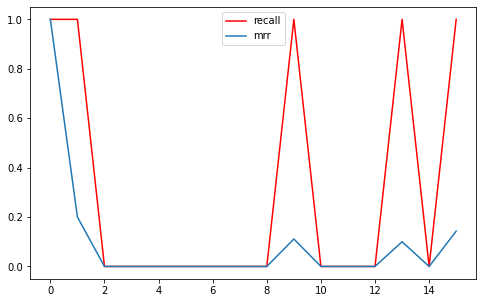

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=5.14]    

	 - Recall@10 epoch 1: 0.312500
	 - MRR@10    epoch 1: 0.097123



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.41it/s]


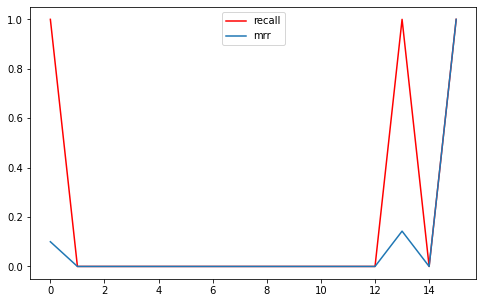

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.19] 

	 - Recall@10 epoch 2: 0.187500
	 - MRR@10    epoch 2: 0.077679



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.24it/s]


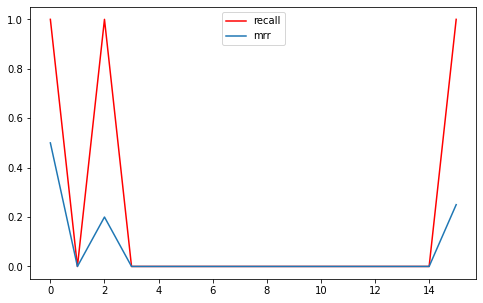

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.46]

	 - Recall@10 epoch 3: 0.187500
	 - MRR@10    epoch 3: 0.059375



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.51it/s]


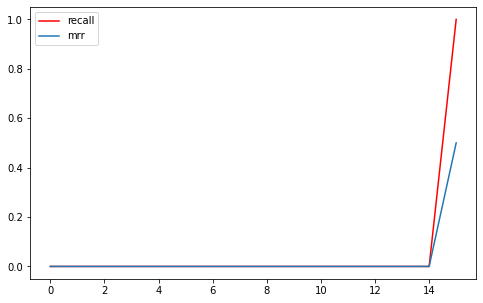

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.34]

	 - Recall@10 epoch 4: 0.062500
	 - MRR@10    epoch 4: 0.031250



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.60it/s]


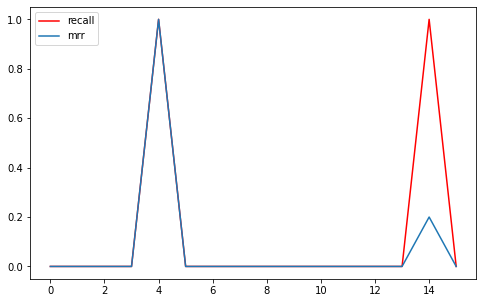

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.56]

	 - Recall@10 epoch 5: 0.125000
	 - MRR@10    epoch 5: 0.075000



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.32it/s]


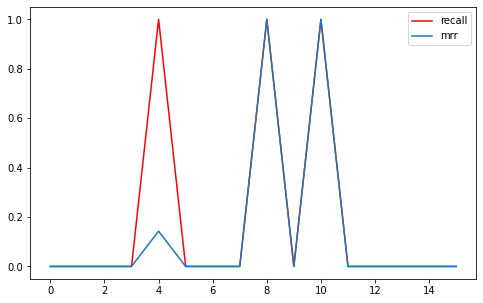

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.48]

	 - Recall@10 epoch 6: 0.187500
	 - MRR@10    epoch 6: 0.133929



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.21it/s]


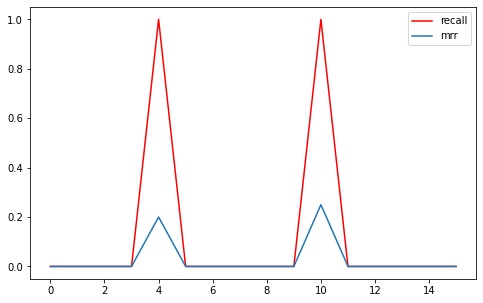

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.34]

	 - Recall@10 epoch 7: 0.125000
	 - MRR@10    epoch 7: 0.028125



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.32it/s]


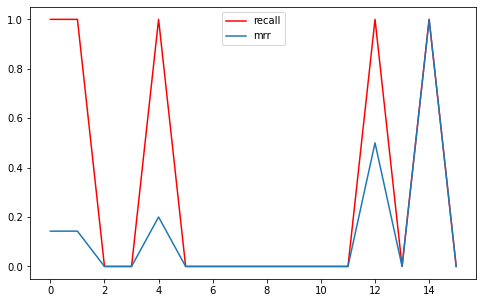

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.29]    

	 - Recall@10 epoch 8: 0.312500
	 - MRR@10    epoch 8: 0.124107



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.95it/s]


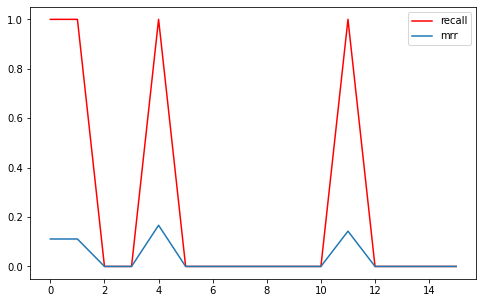

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.63] 

	 - Recall@10 epoch 9: 0.250000
	 - MRR@10    epoch 9: 0.033234



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.28it/s]


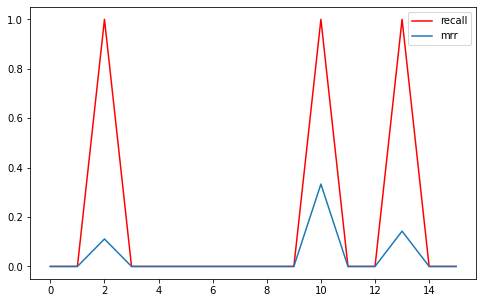

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.45]

	 - Recall@10 epoch 10: 0.187500
	 - MRR@10    epoch 10: 0.036706



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.32it/s]


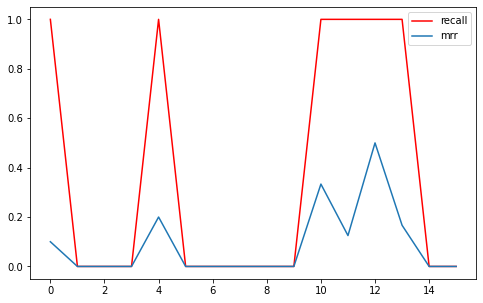

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.5] 

	 - Recall@10 epoch 11: 0.375000
	 - MRR@10    epoch 11: 0.089062



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 16.63it/s]


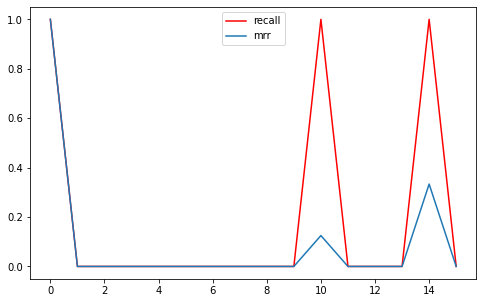

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=6.58]    

	 - Recall@10 epoch 12: 0.187500
	 - MRR@10    epoch 12: 0.091146



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.26it/s]


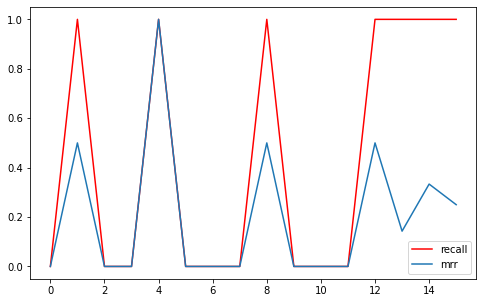

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.93] 

	 - Recall@10 epoch 13: 0.437500
	 - MRR@10    epoch 13: 0.201637



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.09it/s]


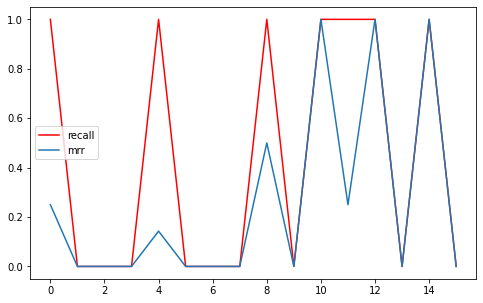

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.2] 

	 - Recall@10 epoch 14: 0.437500
	 - MRR@10    epoch 14: 0.258929



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.79it/s]


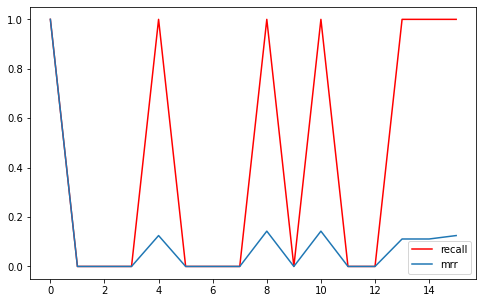

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.82] 

	 - Recall@10 epoch 15: 0.437500
	 - MRR@10    epoch 15: 0.109871



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.63it/s]


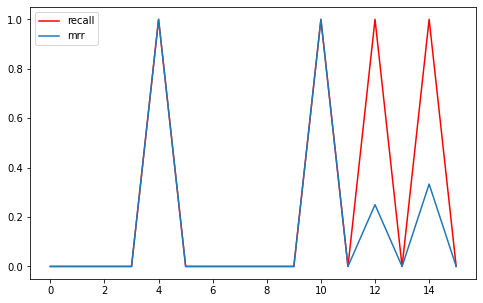

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0, train_loss=8.49]    

	 - Recall@10 epoch 16: 0.250000
	 - MRR@10    epoch 16: 0.161458



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.57it/s]


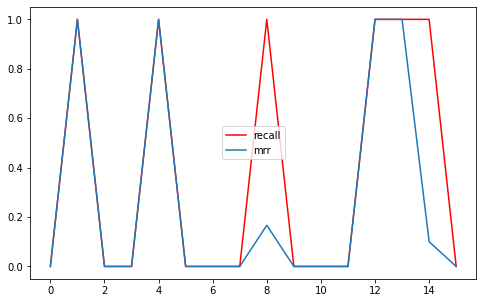

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.56]

	 - Recall@10 epoch 17: 0.375000
	 - MRR@10    epoch 17: 0.266667



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.73it/s]


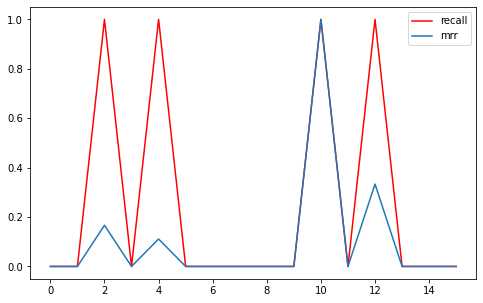

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=9.54]

	 - Recall@10 epoch 18: 0.250000
	 - MRR@10    epoch 18: 0.100694



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.91it/s]


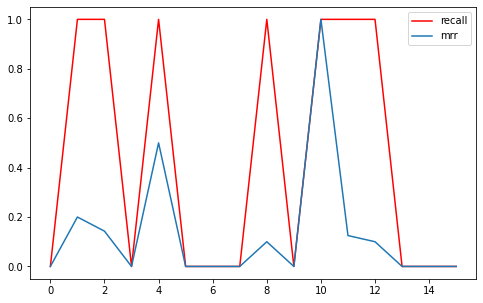

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.14]

	 - Recall@10 epoch 19: 0.437500
	 - MRR@10    epoch 19: 0.135491



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.21it/s]


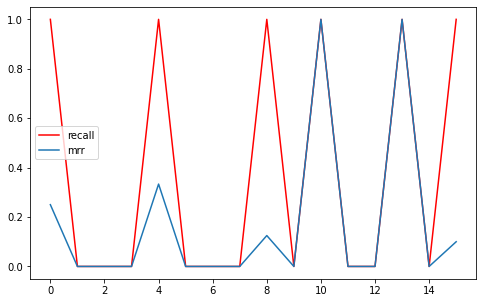

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=8.14] 

	 - Recall@10 epoch 20: 0.375000
	 - MRR@10    epoch 20: 0.175521



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.44it/s]


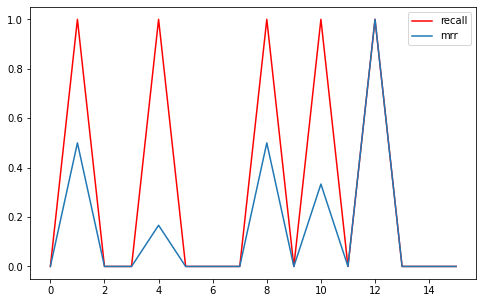

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.02] 

	 - Recall@10 epoch 21: 0.312500
	 - MRR@10    epoch 21: 0.156250



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.74it/s]


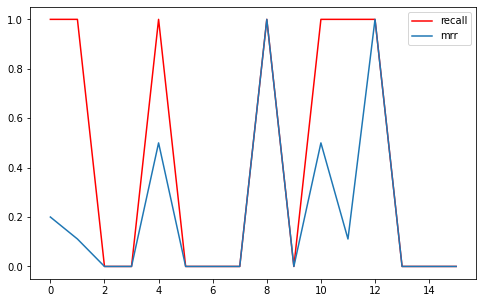

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.57] 

	 - Recall@10 epoch 22: 0.437500
	 - MRR@10    epoch 22: 0.213889



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.87it/s]


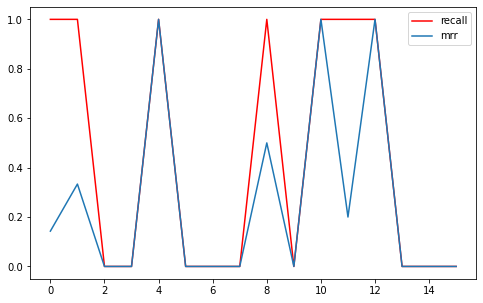

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.19]

	 - Recall@10 epoch 23: 0.437500
	 - MRR@10    epoch 23: 0.261012



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.25it/s]


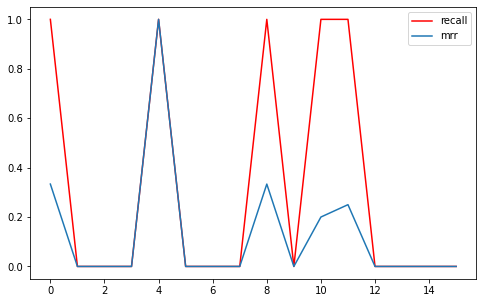

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.43]

	 - Recall@10 epoch 24: 0.312500
	 - MRR@10    epoch 24: 0.132292



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.42it/s]


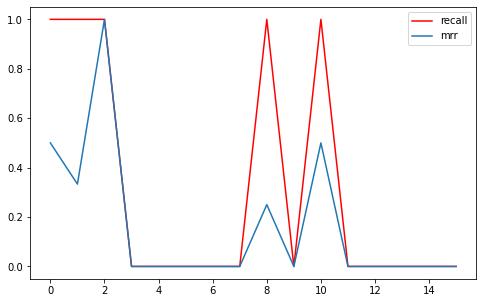

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.24]  

	 - Recall@10 epoch 25: 0.312500
	 - MRR@10    epoch 25: 0.161458



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.48it/s]


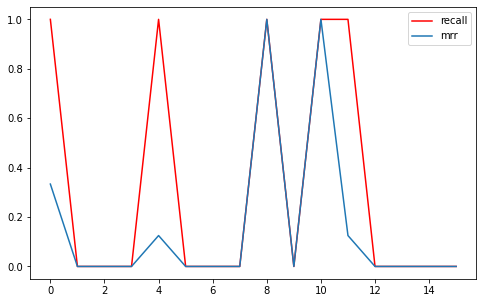

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.28] 

	 - Recall@10 epoch 26: 0.312500
	 - MRR@10    epoch 26: 0.161458



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.09it/s]


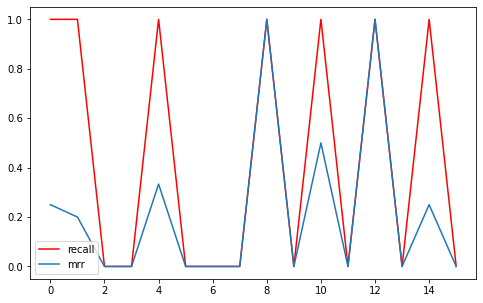

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.81]

	 - Recall@10 epoch 27: 0.437500
	 - MRR@10    epoch 27: 0.220833



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.61it/s]


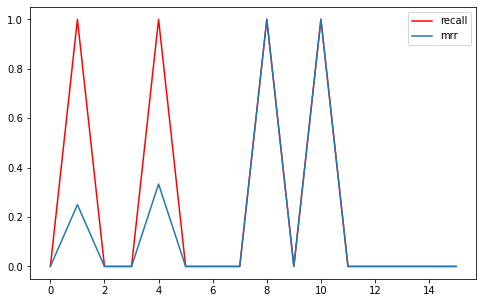

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.88]  

	 - Recall@10 epoch 28: 0.250000
	 - MRR@10    epoch 28: 0.161458



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.83it/s]


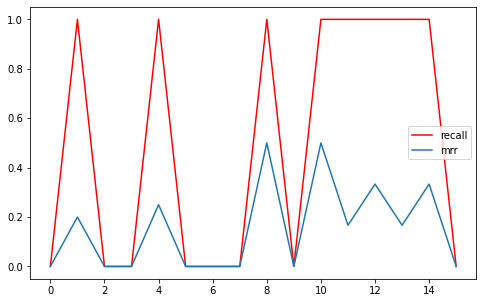

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.73]

	 - Recall@10 epoch 29: 0.500000
	 - MRR@10    epoch 29: 0.153125



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.91it/s]


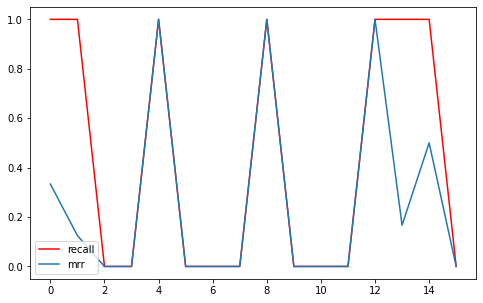

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.49] 

	 - Recall@10 epoch 30: 0.437500
	 - MRR@10    epoch 30: 0.257812



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.17it/s]


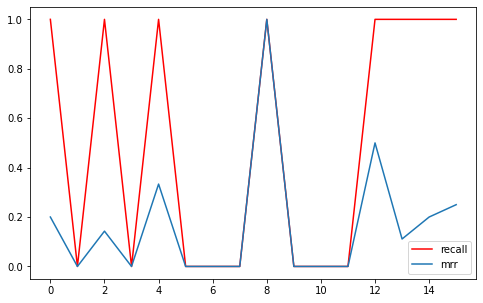

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.07]

	 - Recall@10 epoch 31: 0.500000
	 - MRR@10    epoch 31: 0.171081



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.63it/s]


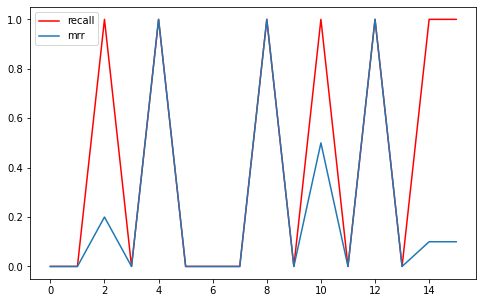

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.22] 

	 - Recall@10 epoch 32: 0.437500
	 - MRR@10    epoch 32: 0.243750



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.97it/s]


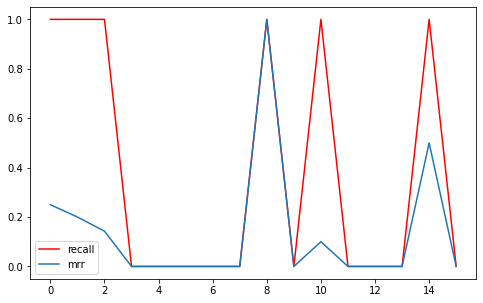

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=6.88] 

	 - Recall@10 epoch 33: 0.375000
	 - MRR@10    epoch 33: 0.137054



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.53it/s]


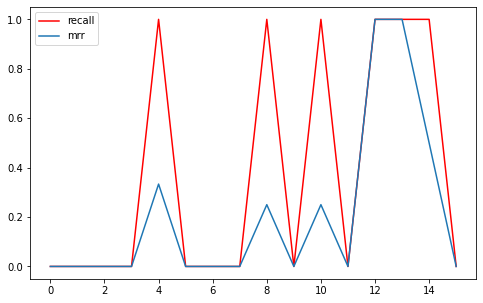

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.14]

	 - Recall@10 epoch 34: 0.375000
	 - MRR@10    epoch 34: 0.208333



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.46it/s]


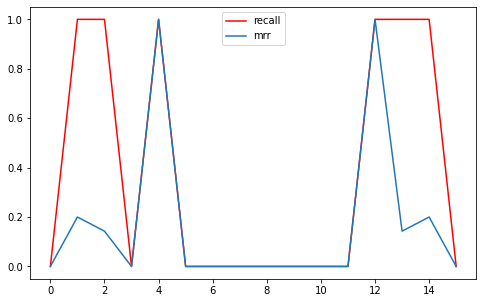

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=7.61]

	 - Recall@10 epoch 35: 0.375000
	 - MRR@10    epoch 35: 0.167857



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.61it/s]


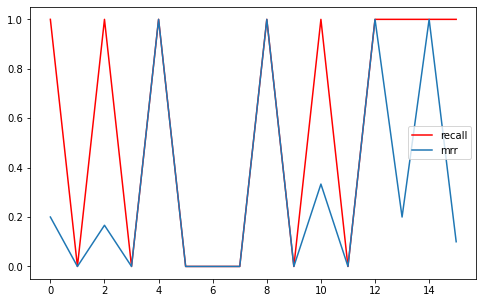

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.02]  

	 - Recall@10 epoch 36: 0.562500
	 - MRR@10    epoch 36: 0.312500



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.79it/s]


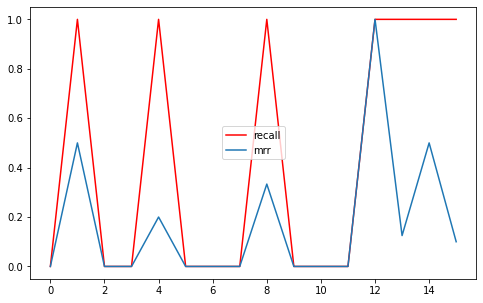

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.93]

	 - Recall@10 epoch 37: 0.437500
	 - MRR@10    epoch 37: 0.172396



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.48it/s]


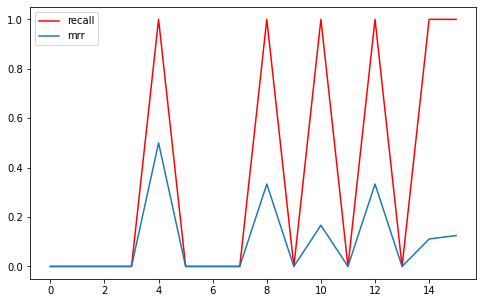

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=5.12]  

	 - Recall@10 epoch 38: 0.375000
	 - MRR@10    epoch 38: 0.098090



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 18.77it/s]


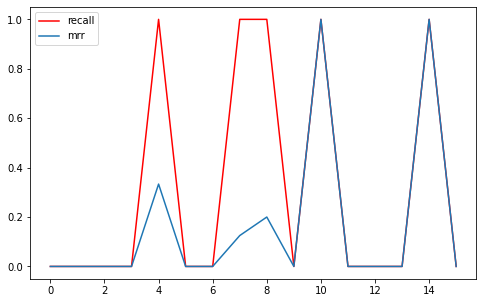

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.46]   

	 - Recall@10 epoch 39: 0.312500
	 - MRR@10    epoch 39: 0.166146



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.32it/s]


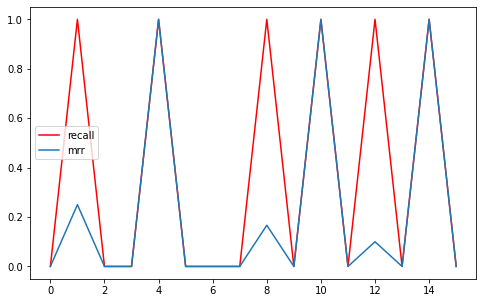

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.83]

	 - Recall@10 epoch 40: 0.375000
	 - MRR@10    epoch 40: 0.219792



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.68it/s]


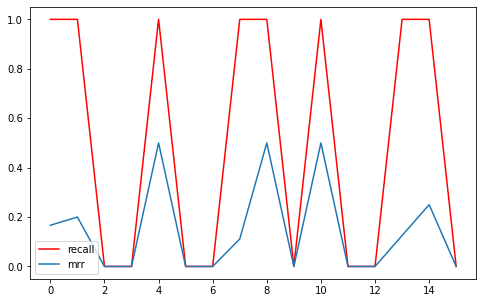

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.38]  

	 - Recall@10 epoch 41: 0.500000
	 - MRR@10    epoch 41: 0.147049



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.24it/s]


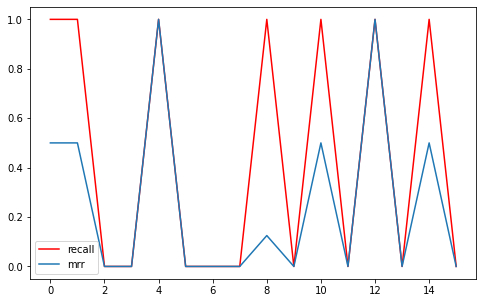

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=4.11]

	 - Recall@10 epoch 42: 0.437500
	 - MRR@10    epoch 42: 0.257812



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.26it/s]


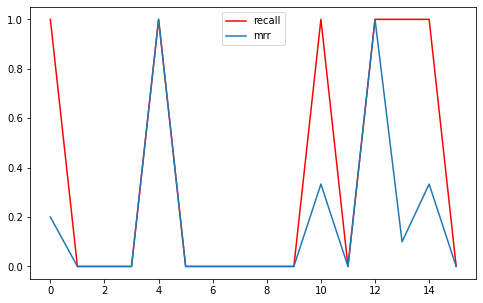

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.51]   

	 - Recall@10 epoch 43: 0.375000
	 - MRR@10    epoch 43: 0.185417



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.67it/s]


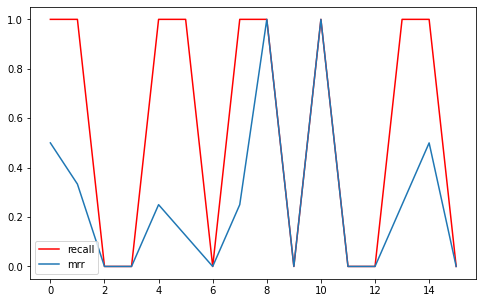

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.21]

	 - Recall@10 epoch 44: 0.562500
	 - MRR@10    epoch 44: 0.263021



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.33it/s]


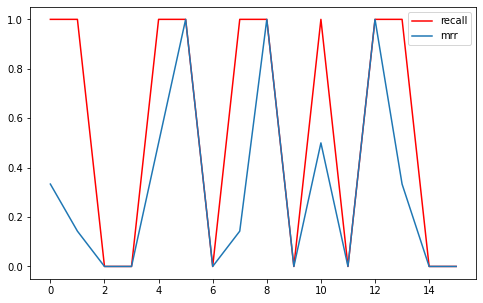

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.71]   

	 - Recall@10 epoch 45: 0.562500
	 - MRR@10    epoch 45: 0.309524



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.52it/s]


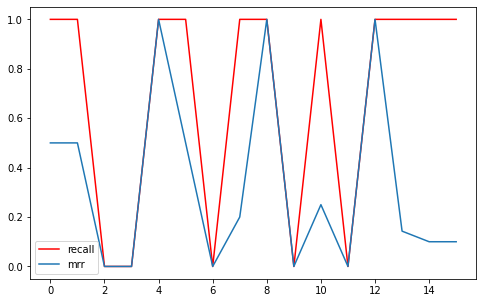

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.8] 

	 - Recall@10 epoch 46: 0.687500
	 - MRR@10    epoch 46: 0.330804



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.74it/s]


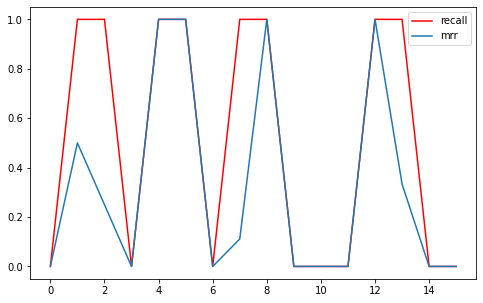

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.19]

	 - Recall@10 epoch 47: 0.500000
	 - MRR@10    epoch 47: 0.324653



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.85it/s]


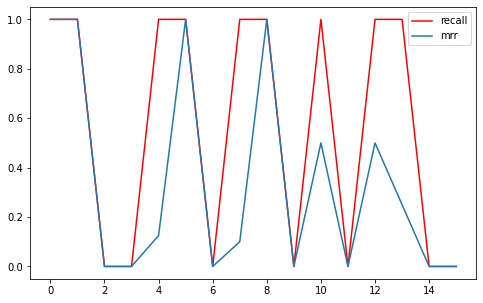

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.2]    

	 - Recall@10 epoch 48: 0.562500
	 - MRR@10    epoch 48: 0.342187



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.28it/s]


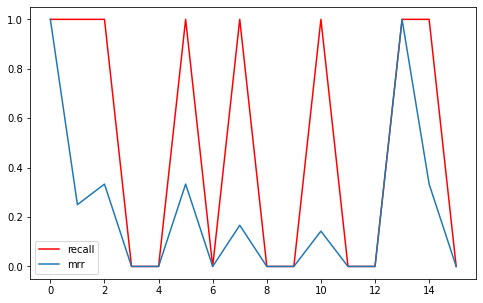

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.24]  

	 - Recall@10 epoch 49: 0.500000
	 - MRR@10    epoch 49: 0.222470



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.88it/s]


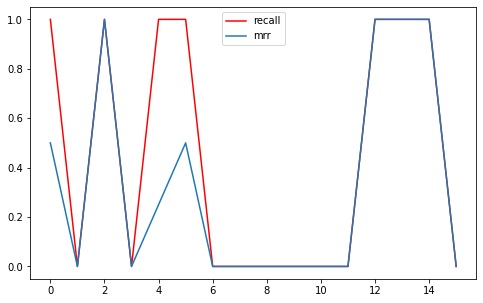

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.1] 

	 - Recall@10 epoch 50: 0.437500
	 - MRR@10    epoch 50: 0.328125



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.40it/s]


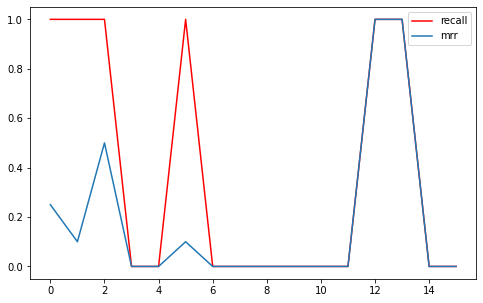

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.19]  

	 - Recall@10 epoch 51: 0.375000
	 - MRR@10    epoch 51: 0.184375



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.11it/s]


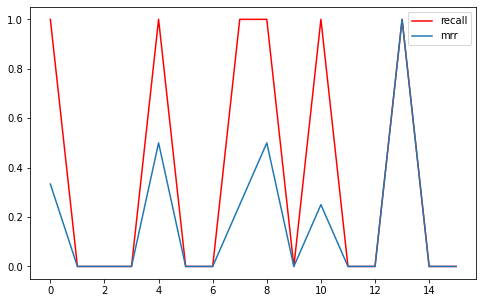

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.57] 

	 - Recall@10 epoch 52: 0.375000
	 - MRR@10    epoch 52: 0.177083



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.80it/s]


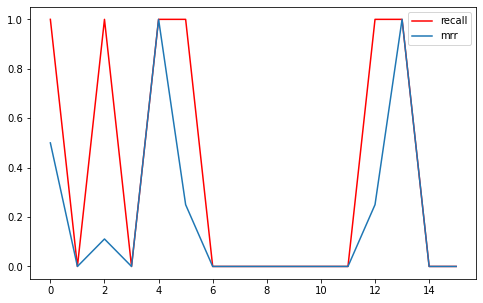

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.38] 

	 - Recall@10 epoch 53: 0.375000
	 - MRR@10    epoch 53: 0.194444



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.23it/s]


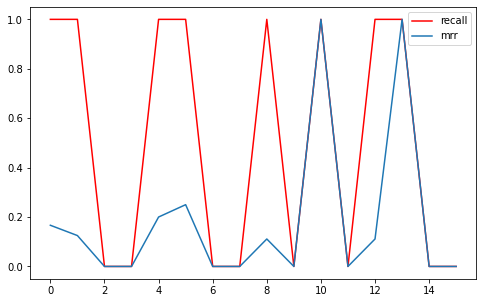

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.49]

	 - Recall@10 epoch 54: 0.500000
	 - MRR@10    epoch 54: 0.185243



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.72it/s]


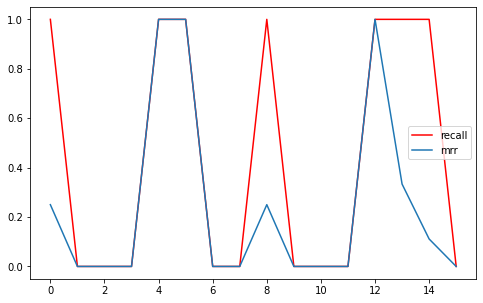

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=6.84]

	 - Recall@10 epoch 55: 0.437500
	 - MRR@10    epoch 55: 0.246528



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.02it/s]


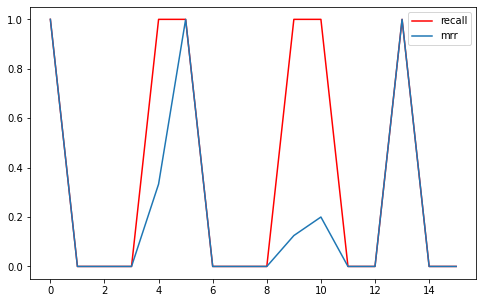

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=4.23] 

	 - Recall@10 epoch 56: 0.375000
	 - MRR@10    epoch 56: 0.228646



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.78it/s]


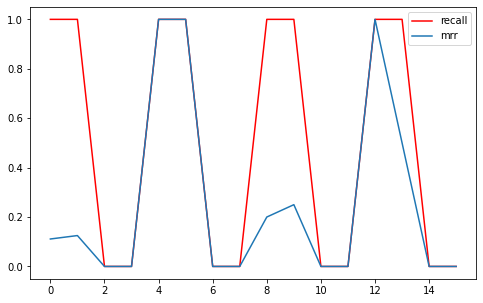

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.06]  

	 - Recall@10 epoch 57: 0.500000
	 - MRR@10    epoch 57: 0.261632



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.53it/s]


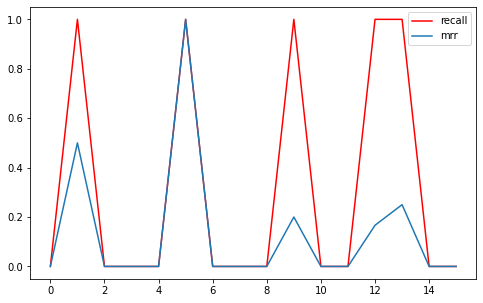

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.46]

	 - Recall@10 epoch 58: 0.312500
	 - MRR@10    epoch 58: 0.132292



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.28it/s]


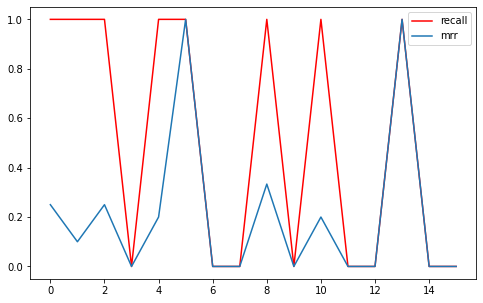

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.61]  

	 - Recall@10 epoch 59: 0.500000
	 - MRR@10    epoch 59: 0.208333



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.51it/s]


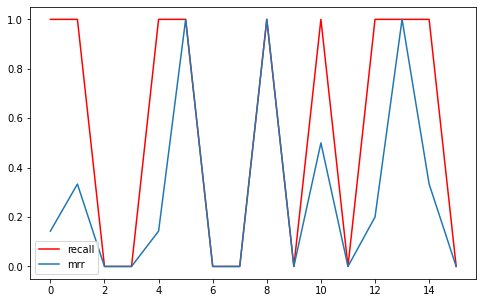

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=3.59]  

	 - Recall@10 epoch 60: 0.562500
	 - MRR@10    epoch 60: 0.290774



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.94it/s]


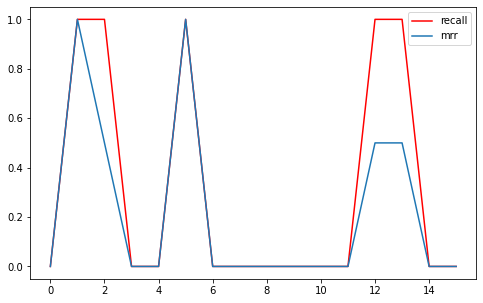

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.01]

	 - Recall@10 epoch 61: 0.312500
	 - MRR@10    epoch 61: 0.218750



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.98it/s]


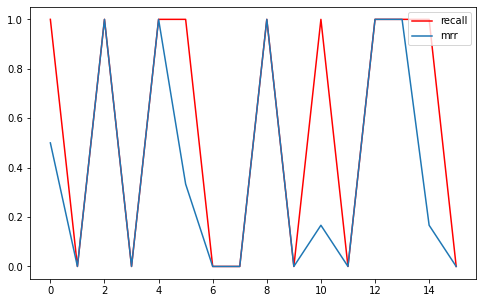

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=4.96]

	 - Recall@10 epoch 62: 0.562500
	 - MRR@10    epoch 62: 0.385417



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.40it/s]


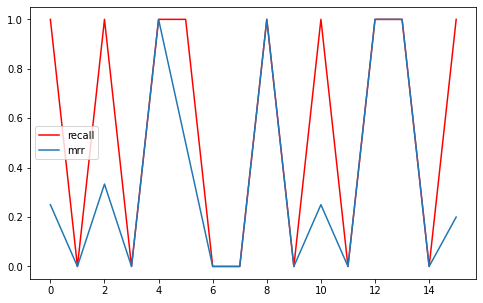

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.35] 

	 - Recall@10 epoch 63: 0.562500
	 - MRR@10    epoch 63: 0.345833



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.37it/s]


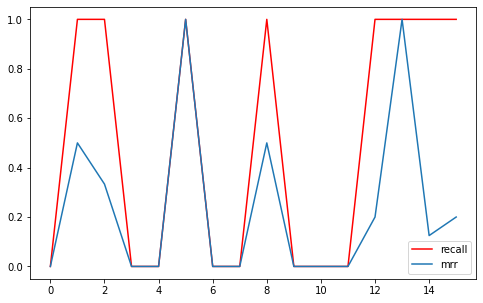

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.49]  

	 - Recall@10 epoch 64: 0.500000
	 - MRR@10    epoch 64: 0.241146



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.87it/s]


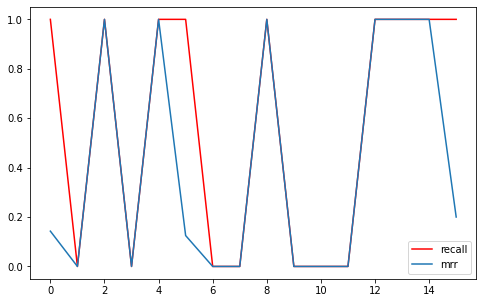

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=7.29]  

	 - Recall@10 epoch 65: 0.562500
	 - MRR@10    epoch 65: 0.404241



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.76it/s]


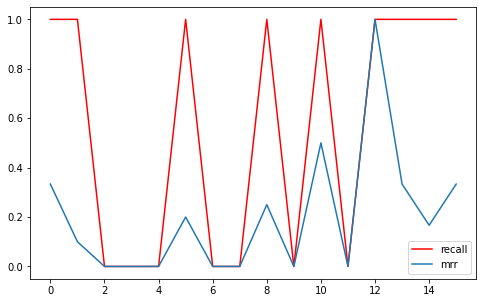

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.4] 

	 - Recall@10 epoch 66: 0.562500
	 - MRR@10    epoch 66: 0.201042



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.00it/s]


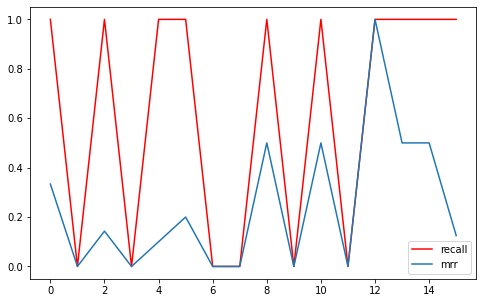

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.12]  

	 - Recall@10 epoch 67: 0.625000
	 - MRR@10    epoch 67: 0.243824



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.70it/s]


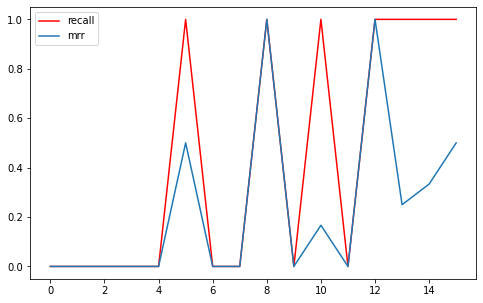

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.01]  

	 - Recall@10 epoch 68: 0.437500
	 - MRR@10    epoch 68: 0.234375



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 22.18it/s]


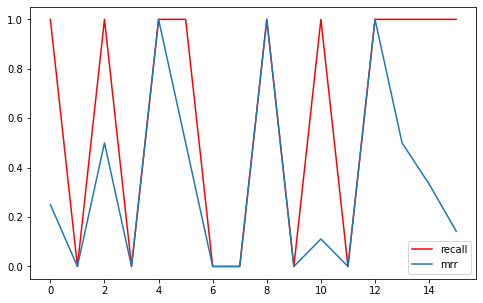

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.42]  

	 - Recall@10 epoch 69: 0.625000
	 - MRR@10    epoch 69: 0.333581



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.43it/s]


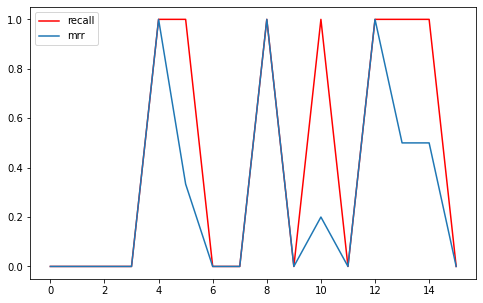

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.78] 

	 - Recall@10 epoch 70: 0.437500
	 - MRR@10    epoch 70: 0.283333



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.87it/s]


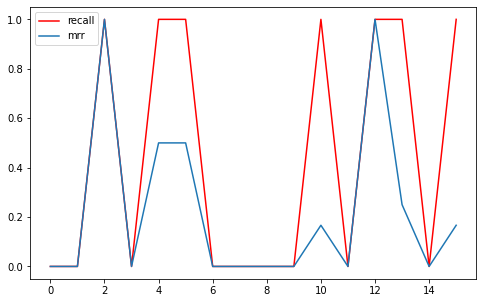

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.76]  

	 - Recall@10 epoch 71: 0.437500
	 - MRR@10    epoch 71: 0.223958



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.34it/s]


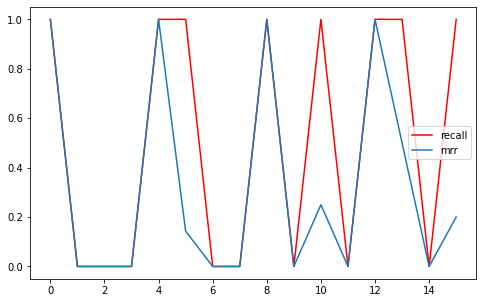

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.88]

	 - Recall@10 epoch 72: 0.500000
	 - MRR@10    epoch 72: 0.318304



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.12it/s]


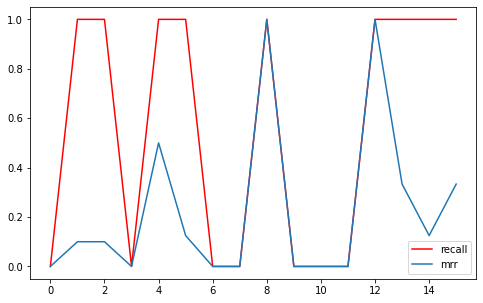

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=8.4]  

	 - Recall@10 epoch 73: 0.562500
	 - MRR@10    epoch 73: 0.226042



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.60it/s]


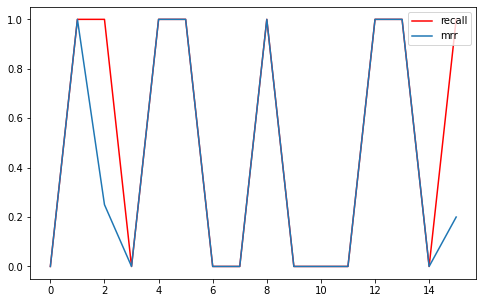

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.67]

	 - Recall@10 epoch 74: 0.500000
	 - MRR@10    epoch 74: 0.403125



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.58it/s]


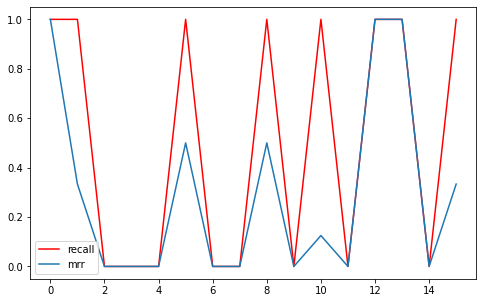

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=5.33]  

	 - Recall@10 epoch 75: 0.500000
	 - MRR@10    epoch 75: 0.299479



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.78it/s]


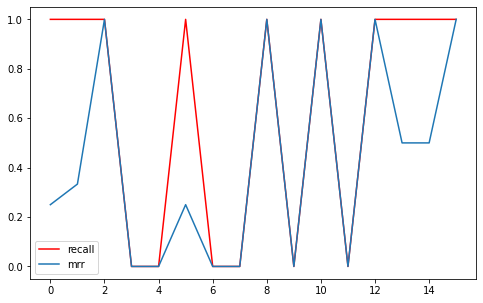

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.43] 

	 - Recall@10 epoch 76: 0.625000
	 - MRR@10    epoch 76: 0.427083



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.59it/s]


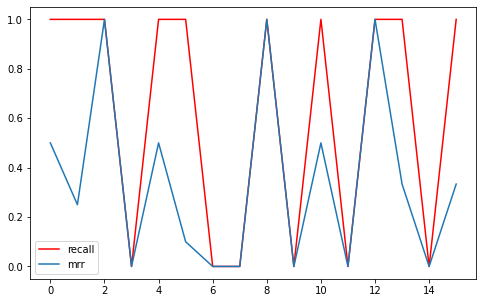

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.35]  

	 - Recall@10 epoch 77: 0.625000
	 - MRR@10    epoch 77: 0.344792



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.84it/s]


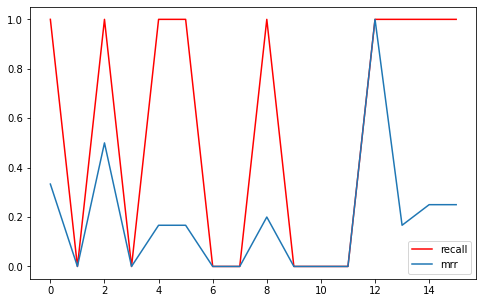

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=8.58] 

	 - Recall@10 epoch 78: 0.562500
	 - MRR@10    epoch 78: 0.189583



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 22.19it/s]


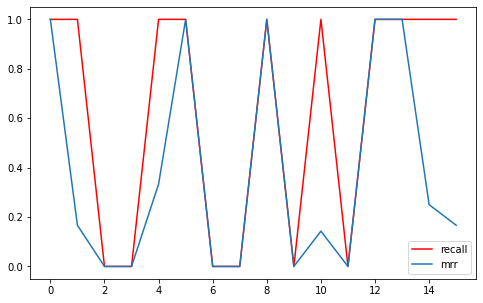

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=5.11] 

	 - Recall@10 epoch 79: 0.625000
	 - MRR@10    epoch 79: 0.378720



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.47it/s]


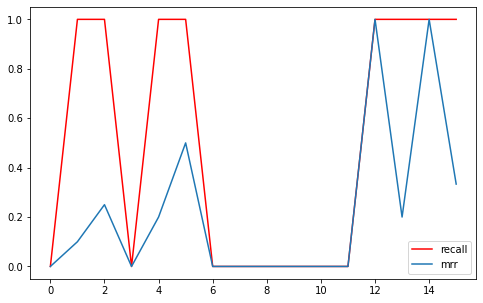

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.975]

	 - Recall@10 epoch 80: 0.500000
	 - MRR@10    epoch 80: 0.223958



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.72it/s]


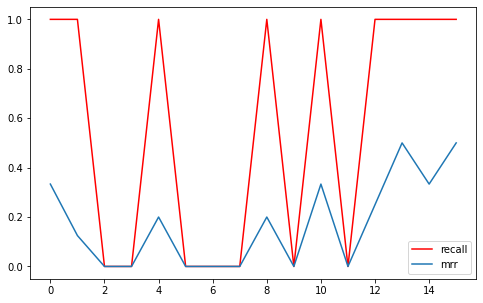

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.87]  

	 - Recall@10 epoch 81: 0.562500
	 - MRR@10    epoch 81: 0.173437



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.52it/s]


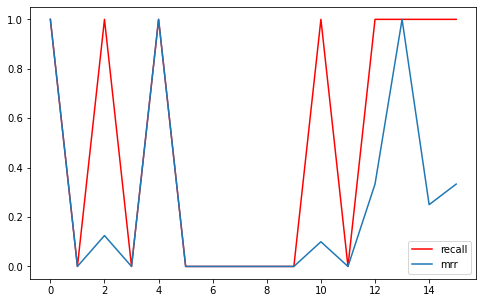

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=6.17]  

	 - Recall@10 epoch 82: 0.500000
	 - MRR@10    epoch 82: 0.258854



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.66it/s]


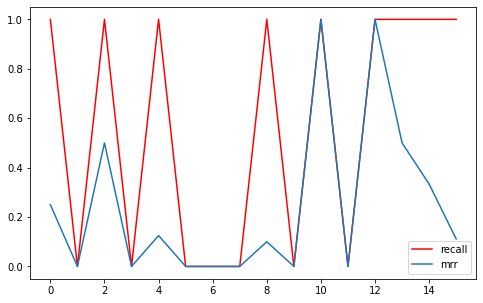

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.79]

	 - Recall@10 epoch 83: 0.562500
	 - MRR@10    epoch 83: 0.244965



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.37it/s]


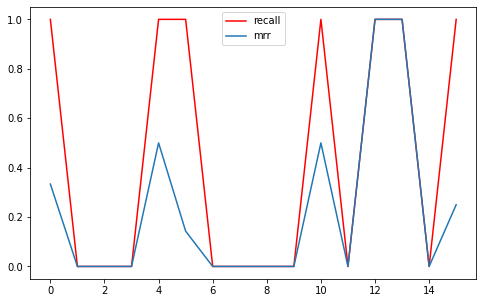

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=7.51] 

	 - Recall@10 epoch 84: 0.437500
	 - MRR@10    epoch 84: 0.232887



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.91it/s]


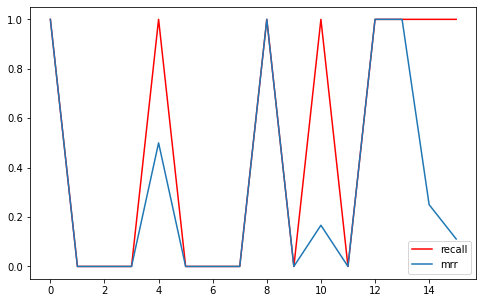

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.45]  

	 - Recall@10 epoch 85: 0.500000
	 - MRR@10    epoch 85: 0.314236



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.27it/s]


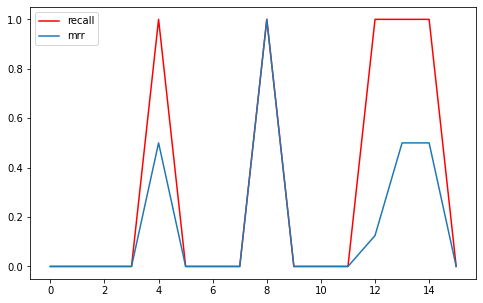

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.57]  

	 - Recall@10 epoch 86: 0.312500
	 - MRR@10    epoch 86: 0.164062



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 22.17it/s]


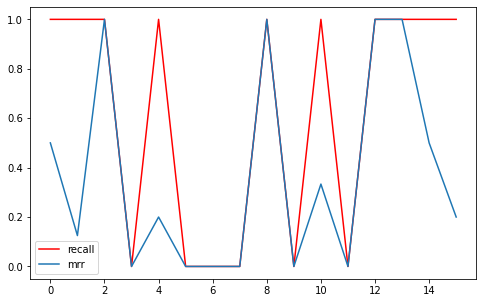

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.72]  

	 - Recall@10 epoch 87: 0.625000
	 - MRR@10    epoch 87: 0.366146



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.25it/s]


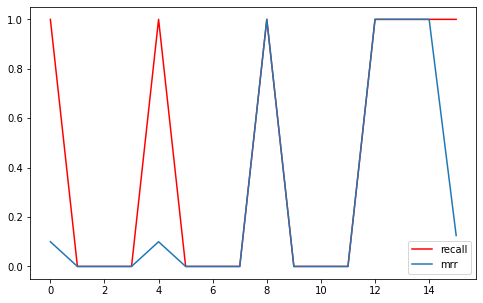

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.88] 

	 - Recall@10 epoch 88: 0.437500
	 - MRR@10    epoch 88: 0.270313



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 22.23it/s]


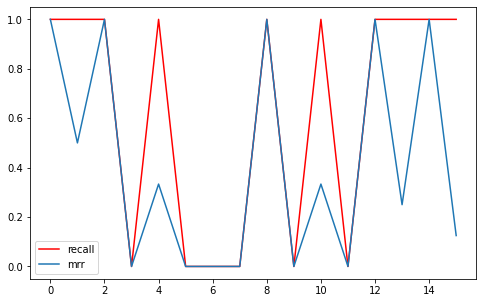

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.125, train_loss=7.07]

	 - Recall@10 epoch 89: 0.625000
	 - MRR@10    epoch 89: 0.408854



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.87it/s]


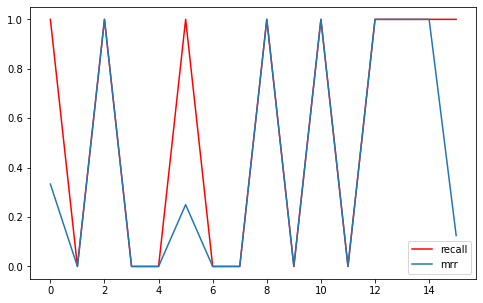

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.25, train_loss=9.41]  

	 - Recall@10 epoch 90: 0.562500
	 - MRR@10    epoch 90: 0.419271



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.36it/s]


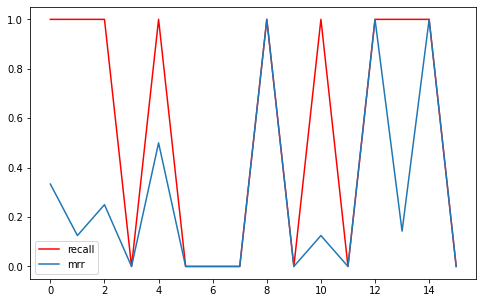

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=3.43]

	 - Recall@10 epoch 91: 0.562500
	 - MRR@10    epoch 91: 0.279762



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.28it/s]


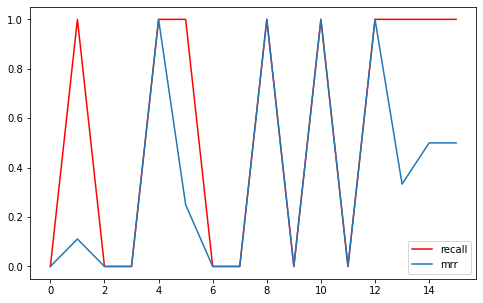

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=5.62]

	 - Recall@10 epoch 92: 0.562500
	 - MRR@10    epoch 92: 0.355903



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.43it/s]


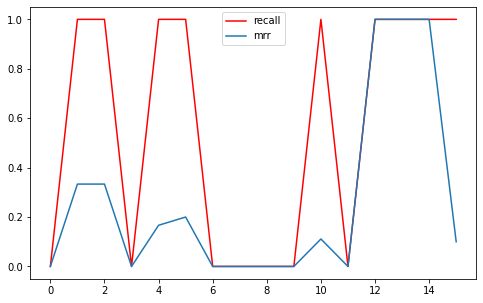

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.44]  

	 - Recall@10 epoch 93: 0.562500
	 - MRR@10    epoch 93: 0.265278



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.67it/s]


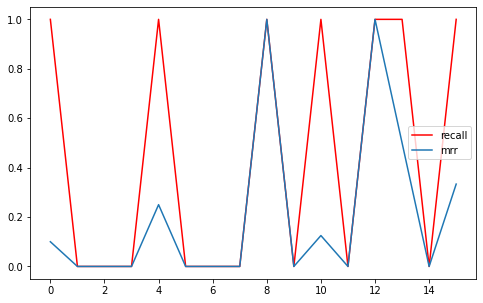

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2]    

	 - Recall@10 epoch 94: 0.437500
	 - MRR@10    epoch 94: 0.206771



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.67it/s]


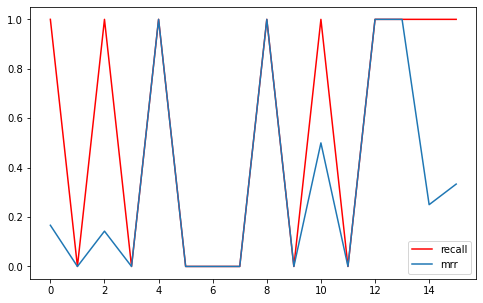

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=2.86] 

	 - Recall@10 epoch 95: 0.562500
	 - MRR@10    epoch 95: 0.337054



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.06it/s]


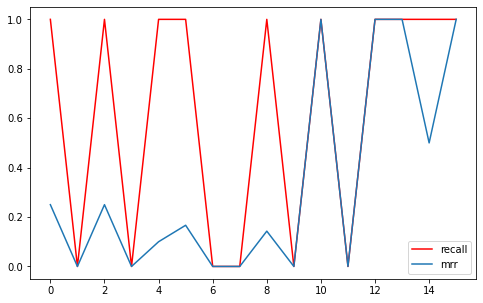

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.75, train_loss=3.12] 

	 - Recall@10 epoch 96: 0.625000
	 - MRR@10    epoch 96: 0.338095



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.93it/s]


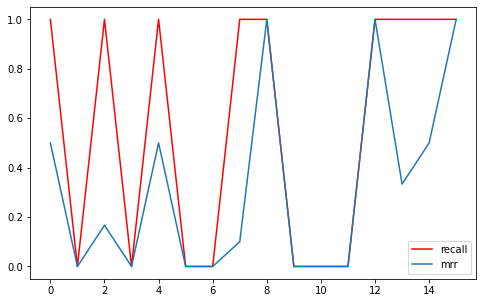

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.625, train_loss=2.78] 

	 - Recall@10 epoch 97: 0.562500
	 - MRR@10    epoch 97: 0.318750



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 19.64it/s]


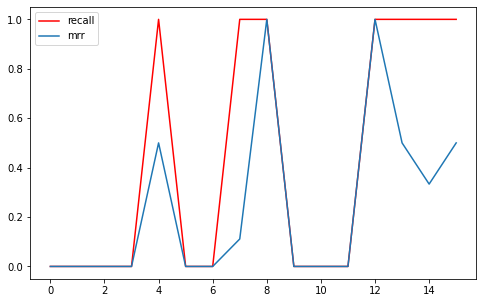

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.375, train_loss=6.64]

	 - Recall@10 epoch 98: 0.437500
	 - MRR@10    epoch 98: 0.246528



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 21.37it/s]


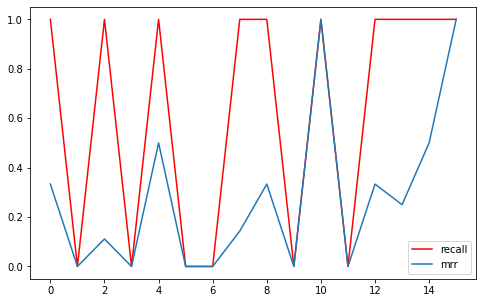

Train:   0%|          | 0/148 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.9]    

	 - Recall@10 epoch 99: 0.625000
	 - MRR@10    epoch 99: 0.281498



Evaluation:  17%|█▋        | 2/12 [00:00<00:00, 20.99it/s]


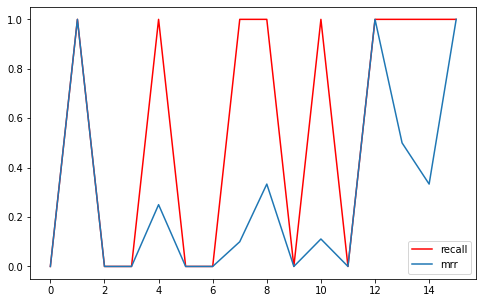

	 - Recall@10 epoch 100: 0.562500
	 - MRR@10    epoch 100: 0.289236



In [905]:
model = create_model(arg_max)
recall, mrr = train_model(model, arg_max, display_flg=True)

Evaluation:  47%|████▋     | 8/17 [00:00<00:00, 16.09it/s]


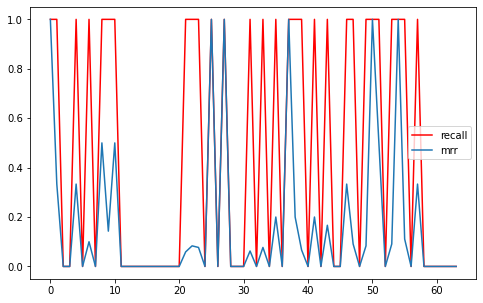

	 - Recall@10: 0.453125
	 - MRR@10: 0.166317



In [906]:
test_model(model, args, test_3)

기본으로 학습시킨 결과와 하이퍼파라미터를 찾아서 학습시킨 결과를 비교했을 때 Recall은 증가했지만 MRR은 감소한 것을 볼 수 있었다.    

# 회고
## 아쉬운 점
* Session Id를 만드는 과정을 진행하다가 그냥 주어진 UserId를 이용해서 진행했다.
* Ranking을 이용해서 더 좋은 결과를 낼 수 있을지 궁금했는데 구현을 못했다.
* 시간을 많이 들여 괜찮은 하이퍼파라미터를 실제 테스트에서는 기대했던 만큼 결과가 좋지 못했다.
* 매번 아이디어는 생각을 하지만 제출기한에 쫓겨 실현을 못하는 것 같다.

## 새롭게 알게 된 점
* RNN은 자연어처리에서 많이 쓴다고만 알고있었는데 추천시스템에서도 쓰인 다는 것이 놀라웠다.
* 이제껏 datetime 형태로 바꾸는 것을 많이 안해봤는데 이번 기회에 제대로 실습하게 된 것 같다.
* task의 주제에 따라서도 평가 방법이 많이 달라진다는 것을 알게되었다. 또, 내가 아는 평가 방법 외 여러 방법이 있다는 것도 알게되었다.

# Reference
* https://jyoondev.tistory.com/130
* https://seing.tistory.com/95
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve
* https://danthetech.netlify.app/DataScience/evaluation-metrics-for-recommendation-system